Kruschke's Doing Bayesian Data Analysis in PyMC3
==========================

The scripts from https://github.com/aloctavodia/Doing_bayesian_data_analysis collected into one IPython notebook, with minor edits:
- all imports collected into the first cell
- import scipy.special.binom so it does not overwrite scipy.stats.binom
- move csv files into cells, and read them using StringIO

Only some files import division from \_\_future__ but this does not appear to cause any bugs.

In [2]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm

import sys
from StringIO import StringIO

from scipy.stats import norm, multivariate_normal, beta, binom, stats
from scipy.stats import t as stats_t
from scipy.special import beta as beta_func
from scipy.special import binom as special_binom
from scipy.special import betaln as special_betaln
from scipy.optimize import fmin
from scipy.interpolate import spline
from mpl_toolkits.mplot3d.axes3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

:0: FutureWarning: IPython widgets are experimental and may change in the future.


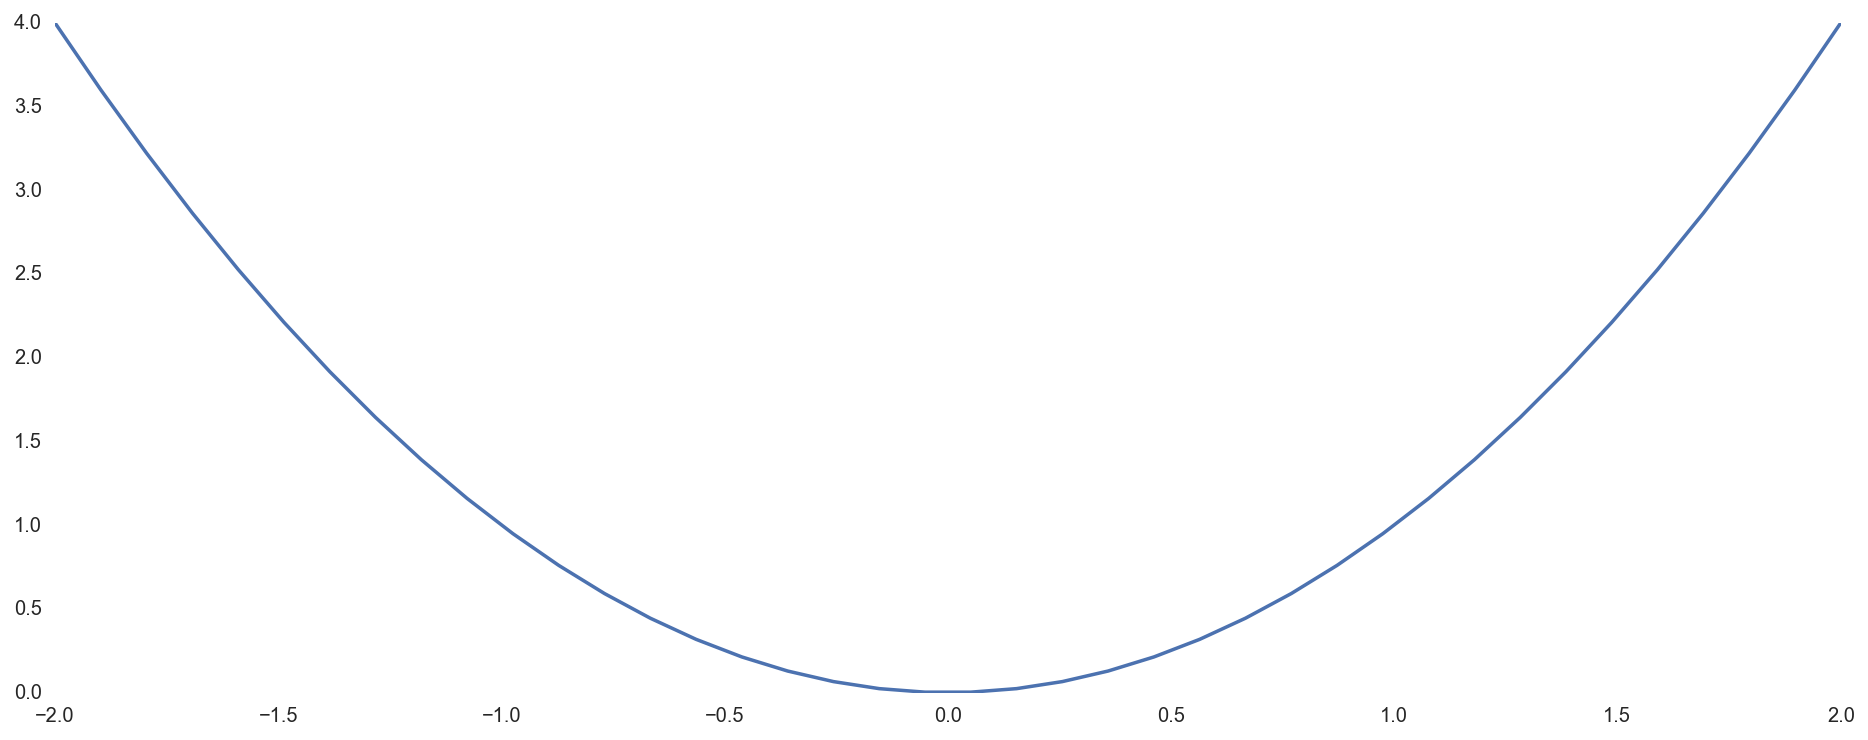

In [21]:
"""
02_SimpleGraph.py
A simple graph drawn by Python :-)
"""
x = np.linspace(-2, 2, 40)
y = x**2

plt.figure(figsize=(16,6))
plt.plot(x, y)

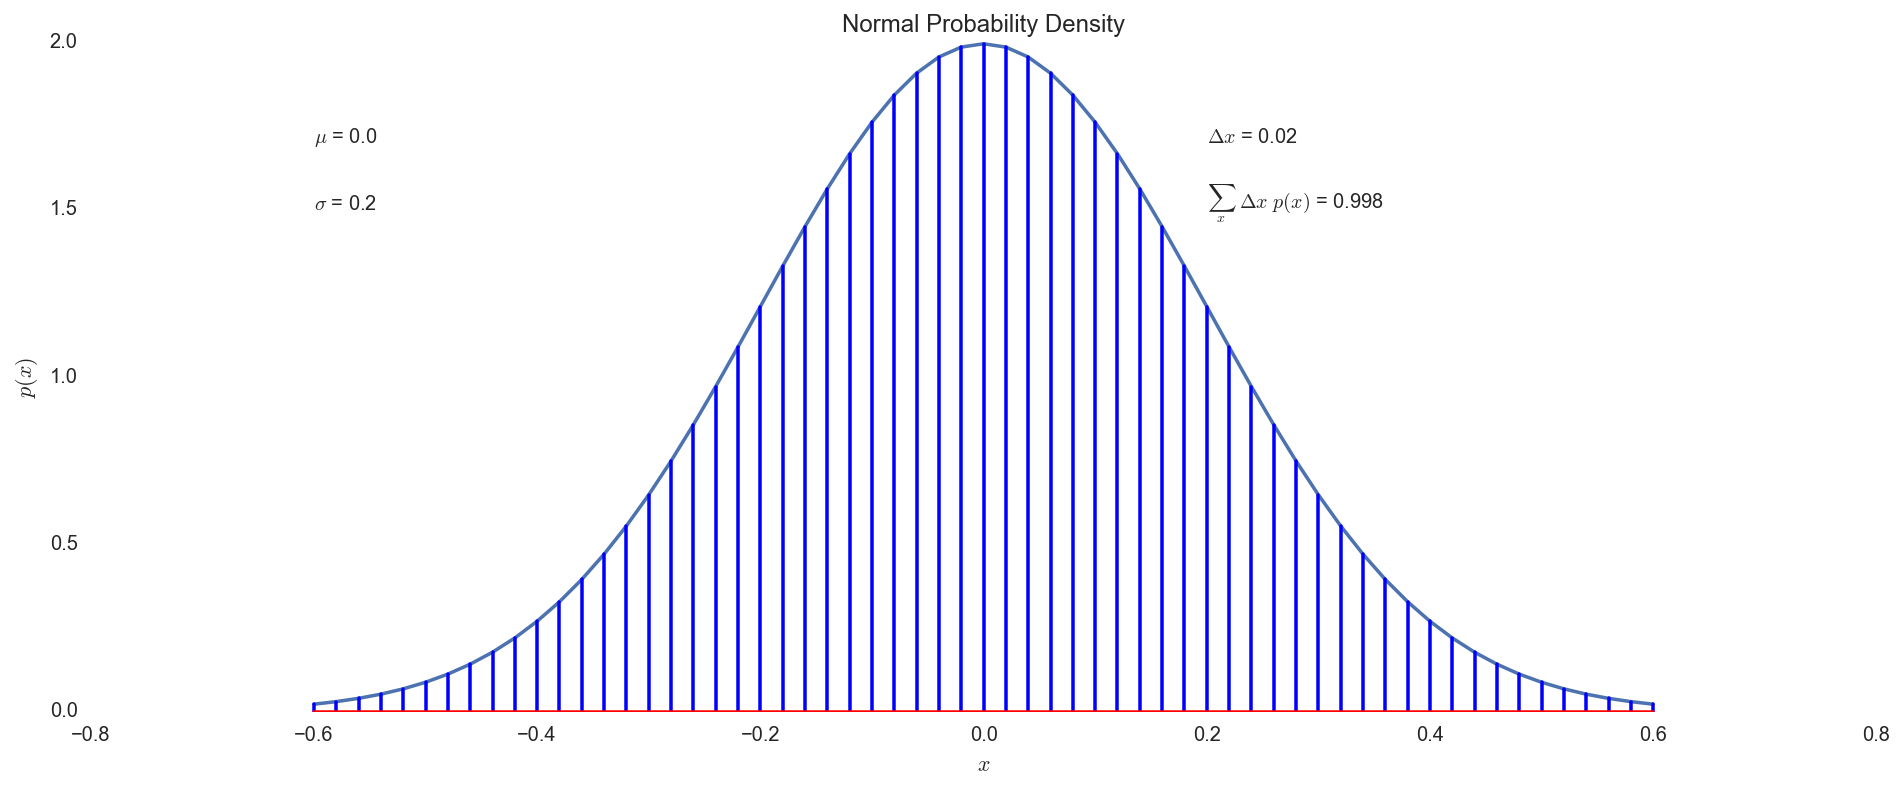

In [22]:
"""
03_IntegralOfDensity.py
Graph of normal probability density function, with comb of intervals.
"""
meanval = 0.0              # Specify mean of distribution.
sdval = 0.2                # Specify standard deviation of distribution.
xlow = meanval - 3 * sdval  # Specify low end of x-axis.
xhigh = meanval + 3 * sdval  # Specify high end of x-axis.
dx = 0.02                  # Specify interval width on x-axis
# Specify comb points along the x axis:
x = np.arange(xlow, xhigh, dx)
# Compute y values, i.e., probability density at each value of x:
y = (1/(sdval*np.sqrt(2*np.pi))) * np.exp(-.5 * ((x - meanval)/sdval)**2)
# Plot the function. "plot" draws the bell curve. "stem" draws the intervals.
plt.figure(figsize=(16,6)) # Brian added
plt.plot(x, y)
plt.stem(x, y, markerfmt=' ')

plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.title('Normal Probability Density')
# Approximate the integral as the sum of width * height for each interval.
area = np.sum(dx*y)
# Display info in the graph.
_ = plt.text(-.6, 1.7, '$\mu$ = %s' % meanval)
_ = plt.text(-.6, 1.5, '$\sigma$ = %s' % sdval)
_ = plt.text(.2, 1.7, '$\Delta x$ = %s' % dx)
_ = plt.text(.2, 1.5, '$\sum_{x}$ $\Delta x$ $p(x)$ = %5.3f' % area)

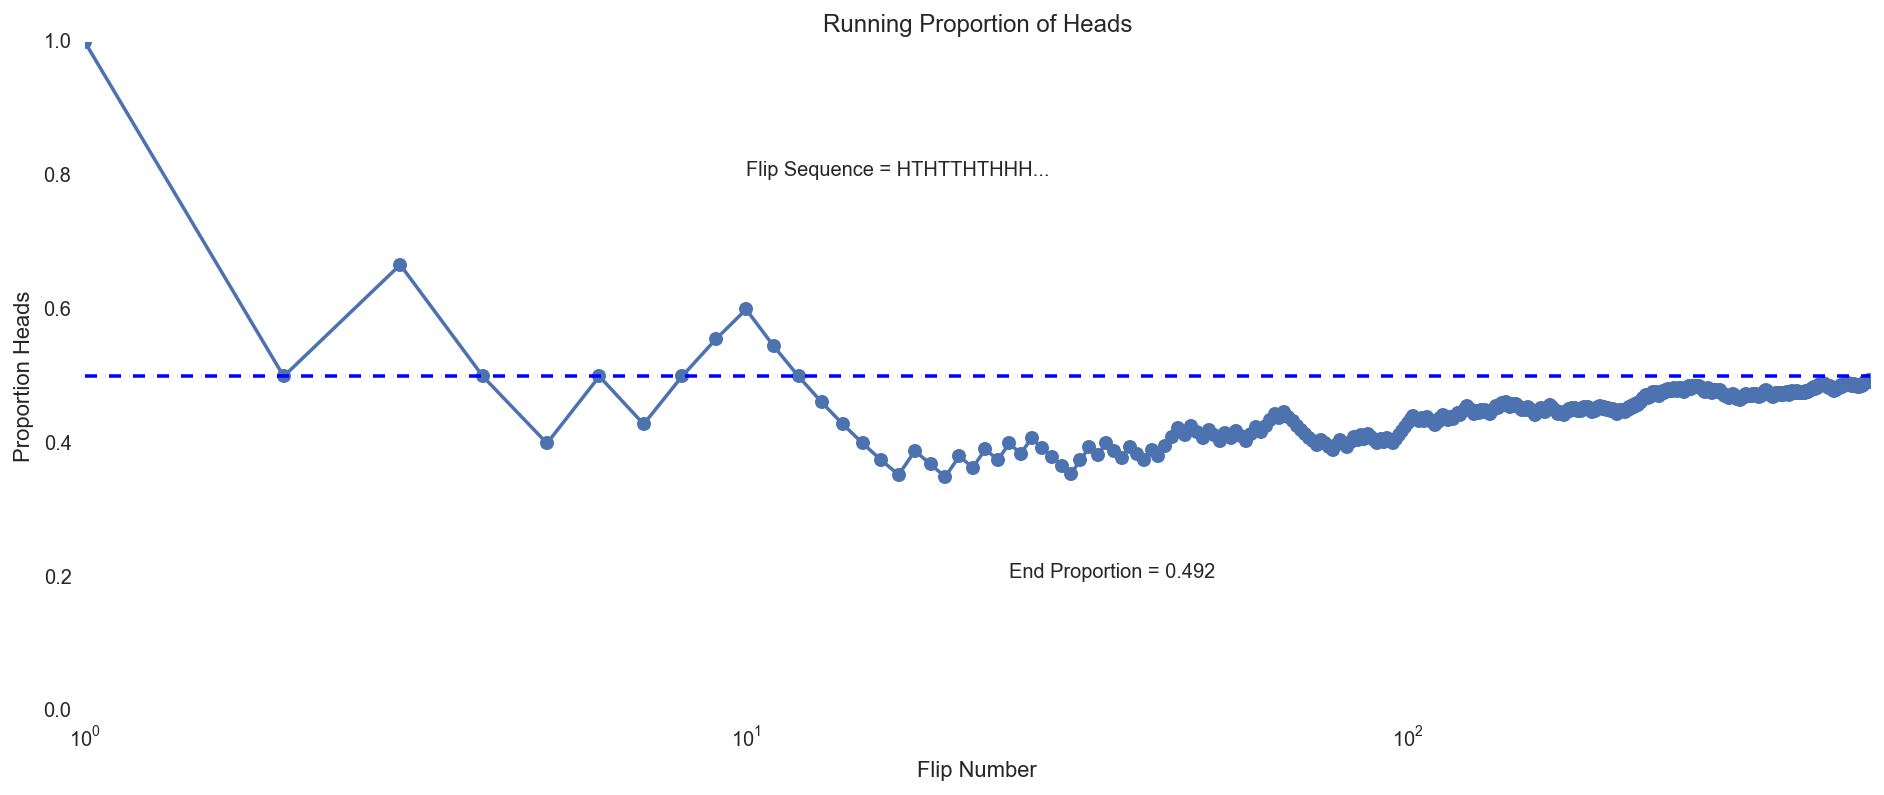

In [5]:
"""
03_RunningProportion.py
Goal: Toss a coin N times and compute the running proportion of heads.
"""

# Specify the total number of flips, denoted N.
N = 500
# Generate a random sample of N flips for a fair coin (heads=1, tails=0);
np.random.seed(47405)
flip_sequence = np.random.choice(a=(0, 1), p=(.5, .5), size=N, replace=True)
# Compute the running proportion of heads:
r = np.cumsum(flip_sequence)
n = np.linspace(1, N, N)  # n is a vector.
run_prop = r/n  # component by component division.

# Graph the running proportion:
plt.figure(figsize=(16,6)) # Brian added
plt.plot(n, run_prop, '-o', )
plt.xscale('log')  # an alternative to plot() and xscale() is semilogx()
plt.xlim(1, N)
plt.ylim(0, 1)
plt.xlabel('Flip Number')
plt.ylabel('Proportion Heads')
plt.title('Running Proportion of Heads')
# Plot a dotted horizontal line at y=.5, just as a reference line:
plt.axhline(y=.5, ls='dashed')

# Display the beginning of the flip sequence.
flipletters = ''.join(["T","H"][flip] for flip in flip_sequence[:10])

_ = plt.text(10, 0.8, 'Flip Sequence = %s...' % flipletters)
# Display the relative frequency at the end of the sequence.
_ = plt.text(25, 0.2, 'End Proportion = %s' % run_prop[-1])

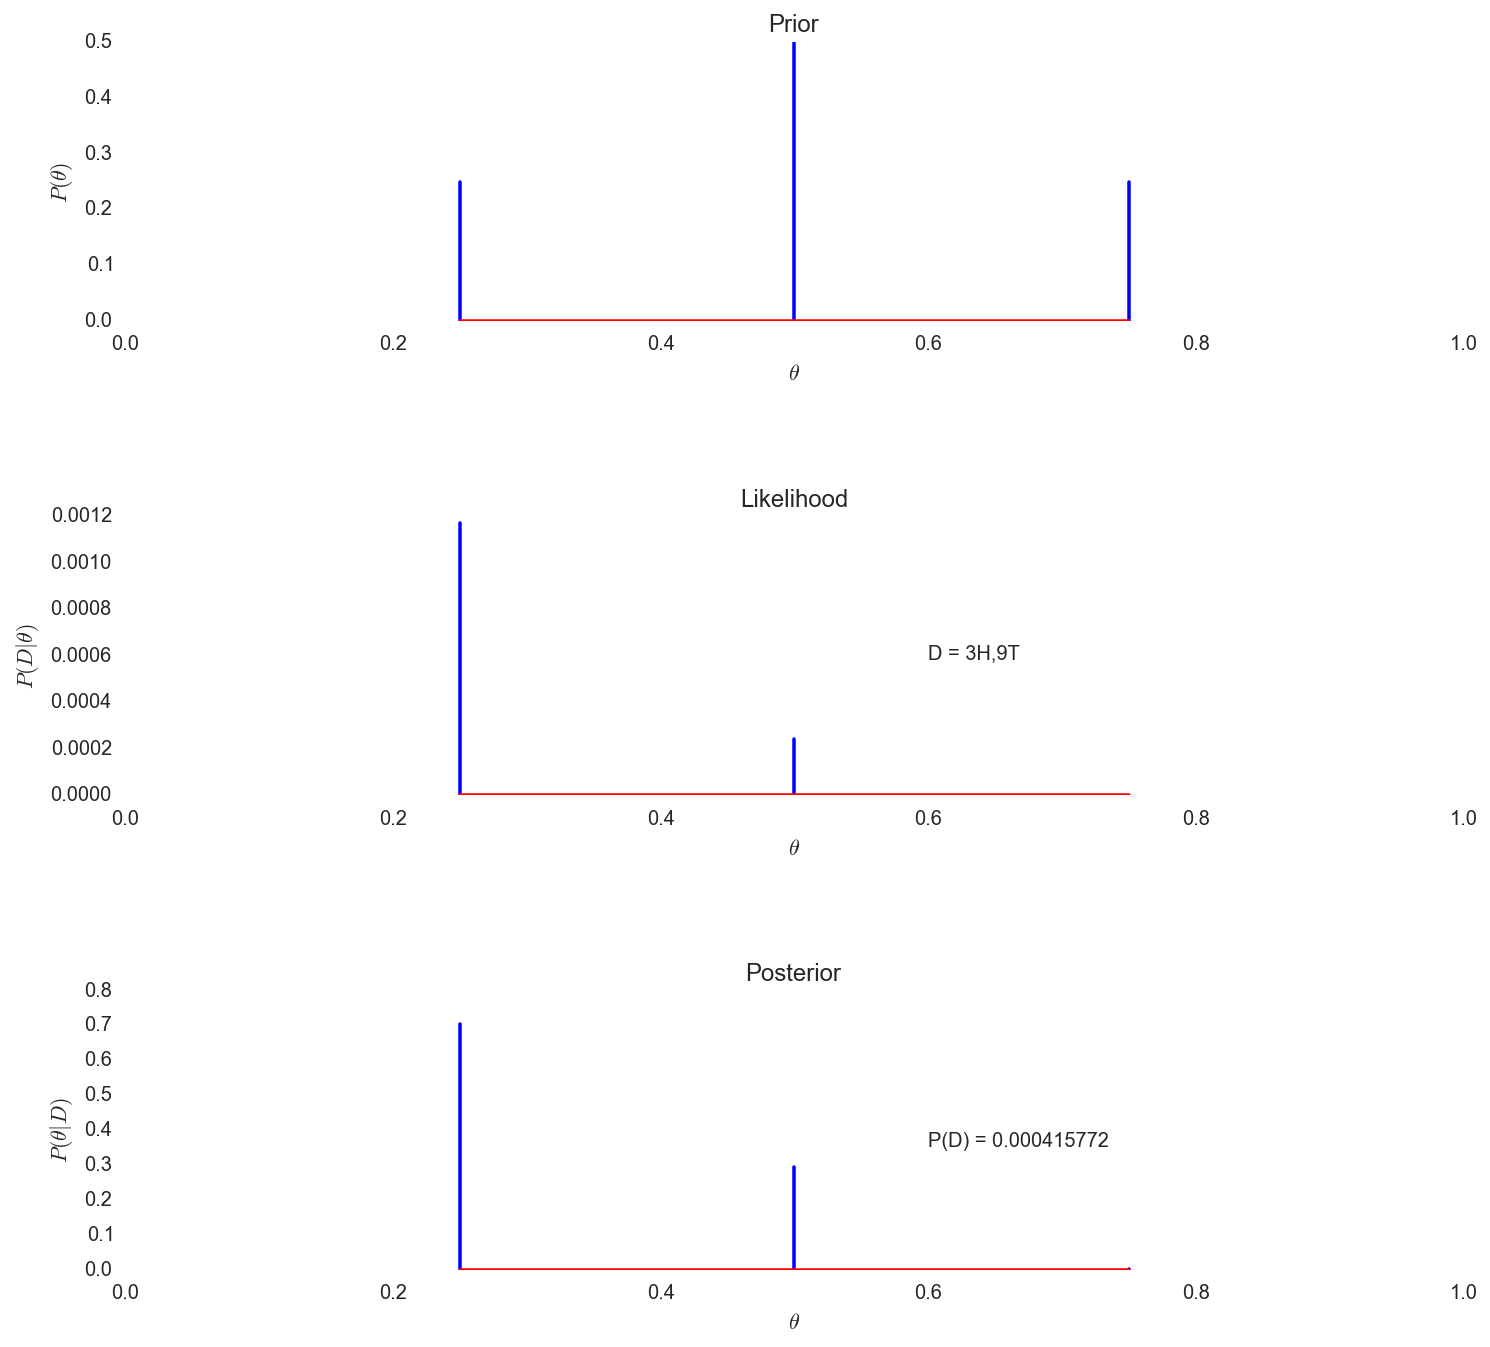

In [24]:
"""
04_BayesUpdate.py
Bayesian updating of beliefs about the bias of a coin. The prior and posterior
distributions indicate probability masses at discrete candidate values of theta.
"""

# theta is the vector of candidate values for the parameter theta.
# n_theta_vals is the number of candidate theta values.
# To produce the examples in the book, set n_theta_vals to either 3 or 63.
n_theta_vals = 3.
# Now make the vector of theta values:
theta = np.linspace(1/(n_theta_vals +1), n_theta_vals /(n_theta_vals +1), n_theta_vals )

# p_theta is the vector of prior probabilities on the theta values.
p_theta = np.minimum(theta, 1-theta)  # Makes a triangular belief distribution.
p_theta = p_theta / np.sum(p_theta)     # Makes sure that beliefs sum to 1.

# Specify the data. To produce the examples in the book, use either
# data = np.repeat([1,0], [3, 9]) or data = np.repeat([1,0], [1, 11])
data = np.repeat([1, 0], [3, 9])
n_heads = np.sum(data)
n_tails = len(data) - n_heads

# Compute the likelihood of the data for each value of theta:
p_data_given_theta = theta**n_heads * (1-theta)**n_tails

# Compute the posterior:
p_data = np.sum(p_data_given_theta * p_theta)
p_theta_given_data = p_data_given_theta * p_theta / p_data   # This is Bayes' rule!

# Plot the results.
plt.figure(figsize=(12, 11))
plt.subplots_adjust(hspace=0.7)

# Plot the prior:
plt.subplot(3, 1, 1)
plt.stem(theta, p_theta, markerfmt=' ')
plt.xlim(0, 1)
plt.xlabel('$\\theta$')
plt.ylabel('$P(\\theta)$')
plt.title('Prior')
# Plot the likelihood:
plt.subplot(3, 1, 2)
plt.stem(theta, p_data_given_theta, markerfmt=' ')
plt.xlim(0, 1)
plt.xlabel('$\\theta$')
plt.ylabel('$P(D|\\theta)$')
plt.title('Likelihood')
plt.text(0.6, np.max(p_data_given_theta)/2, 'D = %sH,%sT' % (n_heads, n_tails))
# Plot the posterior:
plt.subplot(3, 1, 3)
plt.stem(theta, p_theta_given_data, markerfmt=' ')
plt.xlim(0, 1)
plt.xlabel('$\\theta$')
plt.ylabel('$P(\\theta|D)$')
plt.title('Posterior')
_ = plt.text(0.6, np.max(p_theta_given_data)/2, 'P(D) = %g' % p_data)

In [25]:
"""
HIDofICDF.py
This program finds the HDI of a probability density function that is specified 
mathematically in Python.
"""

def HDIofICDF(dist_name, credMass=0.95, **args):
    # freeze distribution with given arguments
    distri = dist_name(**args)
    # initial guess for HDIlowTailPr
    incredMass =  1.0 - credMass

    def intervalWidth(lowTailPr):
        return distri.ppf(credMass + lowTailPr) - distri.ppf(lowTailPr)

    # find lowTailPr that minimizes intervalWidth
    HDIlowTailPr = fmin(intervalWidth, incredMass, ftol=1e-8, disp=False)[0]
    # return interval as array([low, high])
    return distri.ppf([HDIlowTailPr, credMass + HDIlowTailPr])

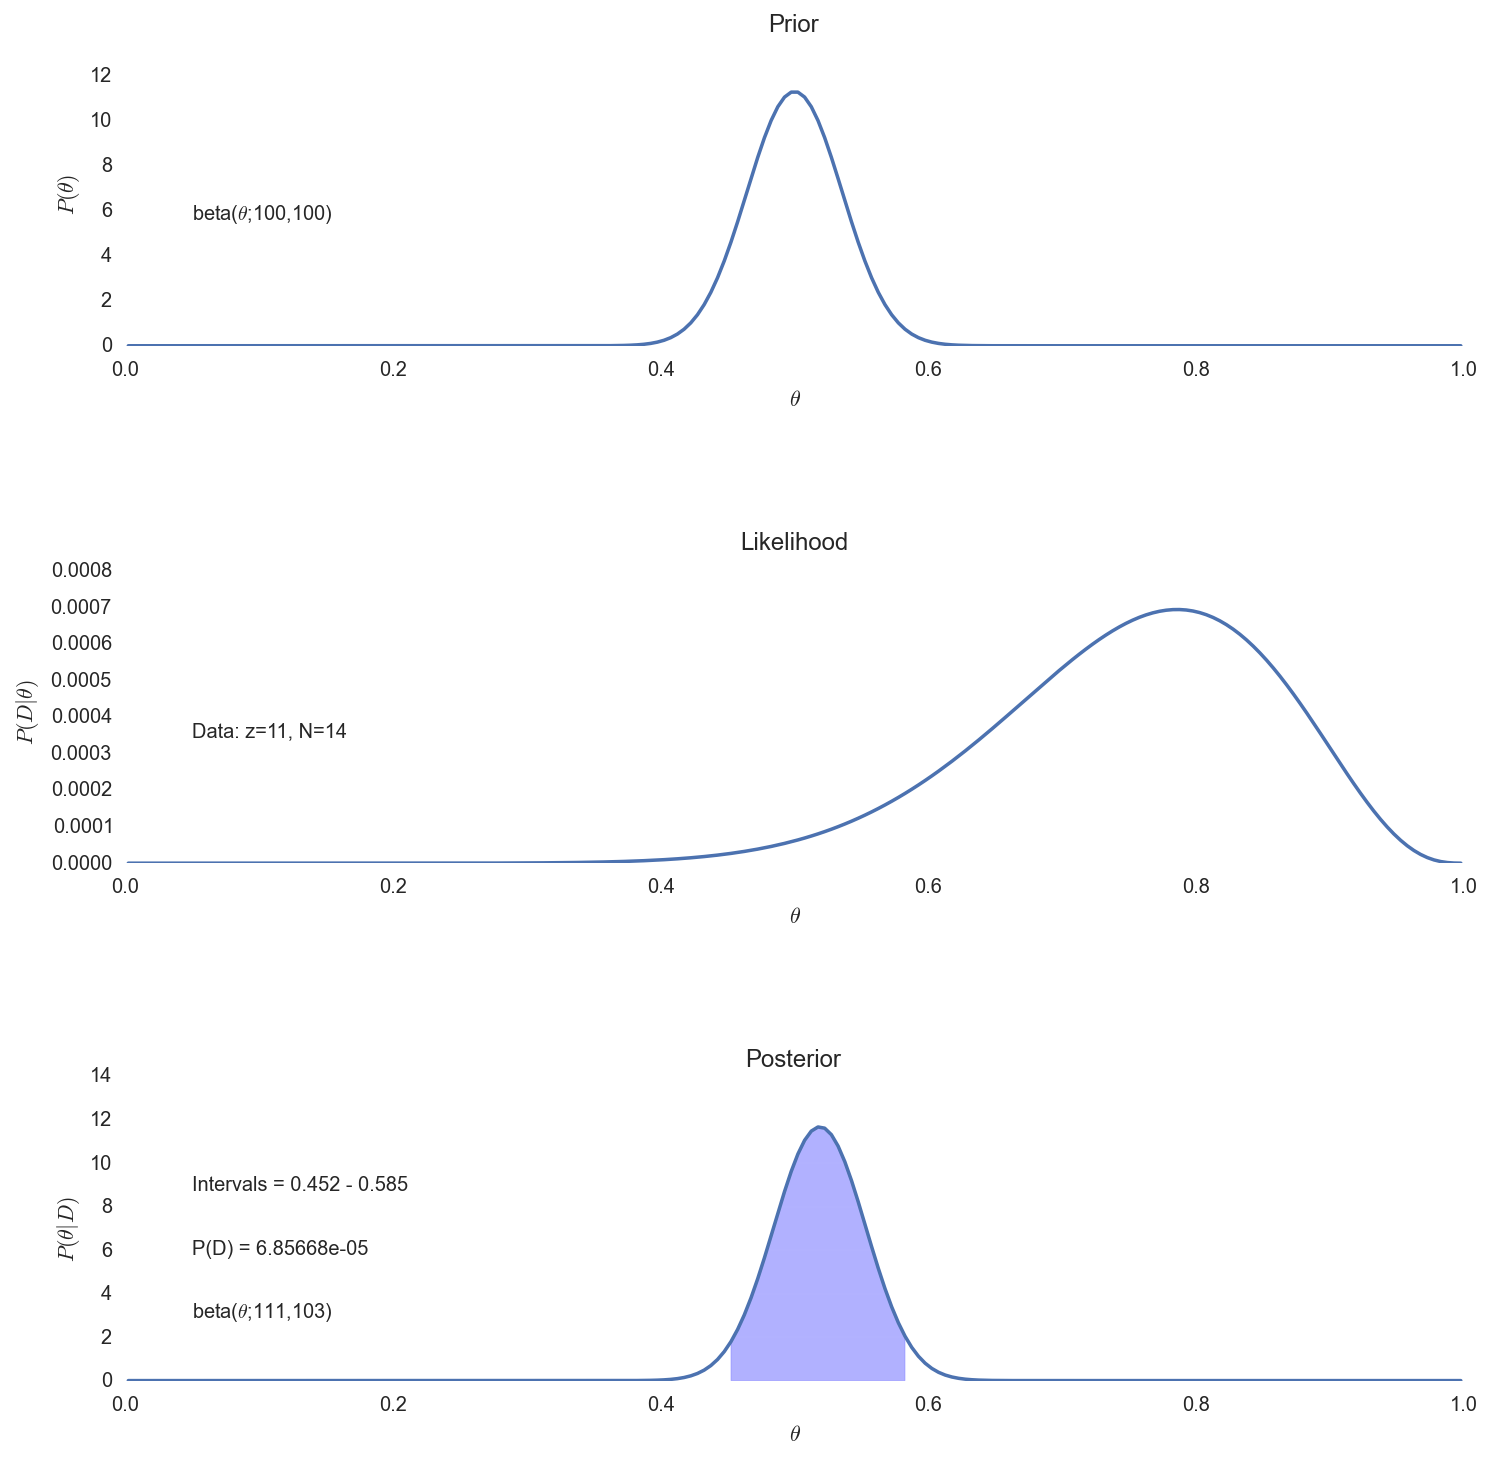

In [26]:
"""
05_BernBeta.py
Inferring a binomial proportion via exact mathematical analysis.
"""

def bern_beta(prior_shape, data_vec, cred_mass=0.95):
    """Bayesian updating for Bernoulli likelihood and beta prior.
     Input arguments:
       prior_shape
         vector of parameter values for the prior beta distribution.
       data_vec
         vector of 1's and 0's.
       cred_mass
         the probability mass of the HDI.
     Output:
       post_shape
         vector of parameter values for the posterior beta distribution.
     Graphics:
       Creates a three-panel graph of prior, likelihood, and posterior
       with highest posterior density interval.
     Example of use:
     post_shape = bern_beta(prior_shape=[1,1] , data_vec=[1,0,0,1,1])"""

    # Check for errors in input arguments:
    if len(prior_shape) != 2:
        sys.exit('prior_shape must have two components.')
    if any([i < 0 for i in prior_shape]):
        sys.exit('prior_shape components must be positive.')
    if any([i != 0 and i != 1 for i in data_vec]):
        sys.exit('data_vec must be a vector of 1s and 0s.')
    if cred_mass <= 0 or cred_mass >= 1.0:
        sys.exit('cred_mass must be between 0 and 1.')

    # Rename the prior shape parameters, for convenience:
    a = prior_shape[0]
    b = prior_shape[1]
    # Create summary values of the data:
    z = sum(data_vec[data_vec == 1])  # number of 1's in data_vec
    N = len(data_vec)   # number of flips in data_vec
    # Compute the posterior shape parameters:
    post_shape = [a+z, b+N-z]
    # Compute the evidence, p(D):
    p_data = beta_func(z+a, N-z+b)/beta_func(a, b)
    # Construct grid of theta values, used for graphing.
    bin_width = 0.005  # Arbitrary small value for comb on theta.
    theta = np.arange(bin_width/2, 1-(bin_width/2)+bin_width, bin_width)
    # Compute the prior at each value of theta.
    p_theta = beta.pdf(theta, a, b)
    # Compute the likelihood of the data at each value of theta.
    p_data_given_theta = theta**z * (1-theta)**(N-z)
    # Compute the posterior at each value of theta.
    post_a = a + z
    post_b = b+N-z
    p_theta_given_data = beta.pdf(theta, a+z, b+N-z)
    # Determine the limits of the highest density interval
    intervals = HDIofICDF(beta, cred_mass, a=post_shape[0], b=post_shape[1])

    # Plot the results.
    plt.figure(figsize=(12, 12))
    plt.subplots_adjust(hspace=0.7)

    # Plot the prior.
    locx = 0.05
    plt.subplot(3, 1, 1)
    plt.plot(theta, p_theta)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_theta)*1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(\theta)$')
    plt.title('Prior')
    plt.text(locx, np.max(p_theta)/2, r'beta($\theta$;%s,%s)' % (a, b))
    # Plot the likelihood:
    plt.subplot(3, 1, 2)
    plt.plot(theta, p_data_given_theta)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_data_given_theta)*1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(D|\theta)$')
    plt.title('Likelihood')
    plt.text(locx, np.max(p_data_given_theta)/2, 'Data: z=%s, N=%s' % (z, N))
    # Plot the posterior:
    plt.subplot(3, 1, 3)
    plt.plot(theta, p_theta_given_data)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_theta_given_data)*1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(\theta|D)$')
    plt.title('Posterior')
    locy = np.linspace(0, np.max(p_theta_given_data), 5)
    plt.text(locx, locy[1], r'beta($\theta$;%s,%s)' % (post_a, post_b))
    plt.text(locx, locy[2], 'P(D) = %g' % p_data)
    # Plot the HDI
    plt.text(locx, locy[3],
             'Intervals = %.3f - %.3f' % (intervals[0], intervals[1]))
    plt.fill_between(theta, 0, p_theta_given_data,
                    where=np.logical_and(theta > intervals[0],
                    theta < intervals[1]),
                        color='blue', alpha=0.3)
    return intervals

data_vec = np.repeat([1, 0], [11, 3])  # 11 heads, 3 tail
intervals = bern_beta(prior_shape=[100, 100], data_vec=data_vec)

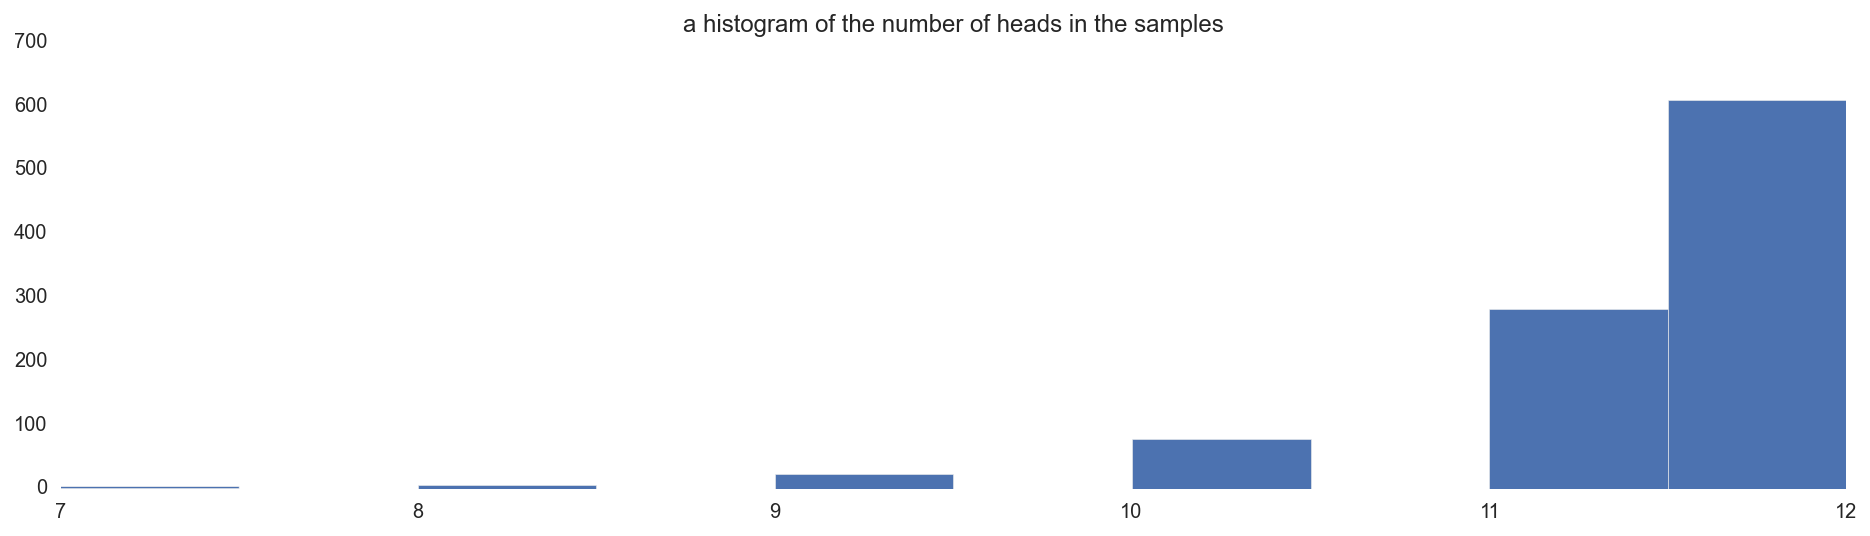

In [27]:
"""
05_BetaPosteriorPredictions.py
Posterior predictive check. Examine the veracity of the winning model by
simulating data sampled from the winning model and see if the simulated data
'look like' the actual data.
"""
# Specify known values of prior and actual data.
prior_a = 100
prior_b = 1
actual_data_Z = 8
actual_data_N = 12
# Compute posterior parameter values.
post_a = prior_a + actual_data_Z
post_b = prior_b + actual_data_N - actual_data_Z
# Number of flips in a simulated sample should match the actual sample size:
sim_sample_size = actual_data_N
# Designate an arbitrarily large number of simulated samples.
n_sim_samples = 1000
# Set aside a vector in which to store the simulation results.
sim_sample_Z_record = np.zeros(n_sim_samples)
# Now generate samples from the posterior.
for sample_idx in range(0, n_sim_samples):
    # Generate a theta value for the new sample from the posterior.
    sample_theta = beta.rvs(post_a, post_b)
    # Generate a sample, using sample_theta.
    sample_data = np.random.choice([0, 1], p=[1-sample_theta, sample_theta],
                                  size=sim_sample_size, replace=True)
    sim_sample_Z_record[sample_idx] = sum(sample_data)


## Make a histogram of the number of heads in the samples.
plt.figure(figsize=(16,4))
plt.title("a histogram of the number of heads in the samples")
plt.hist(sim_sample_Z_record)

In [6]:
"""HPD.py
This code was taken form the PyMC library https://github.com/pymc-devs/pymc
"""

def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd(x, alpha=0.05):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))

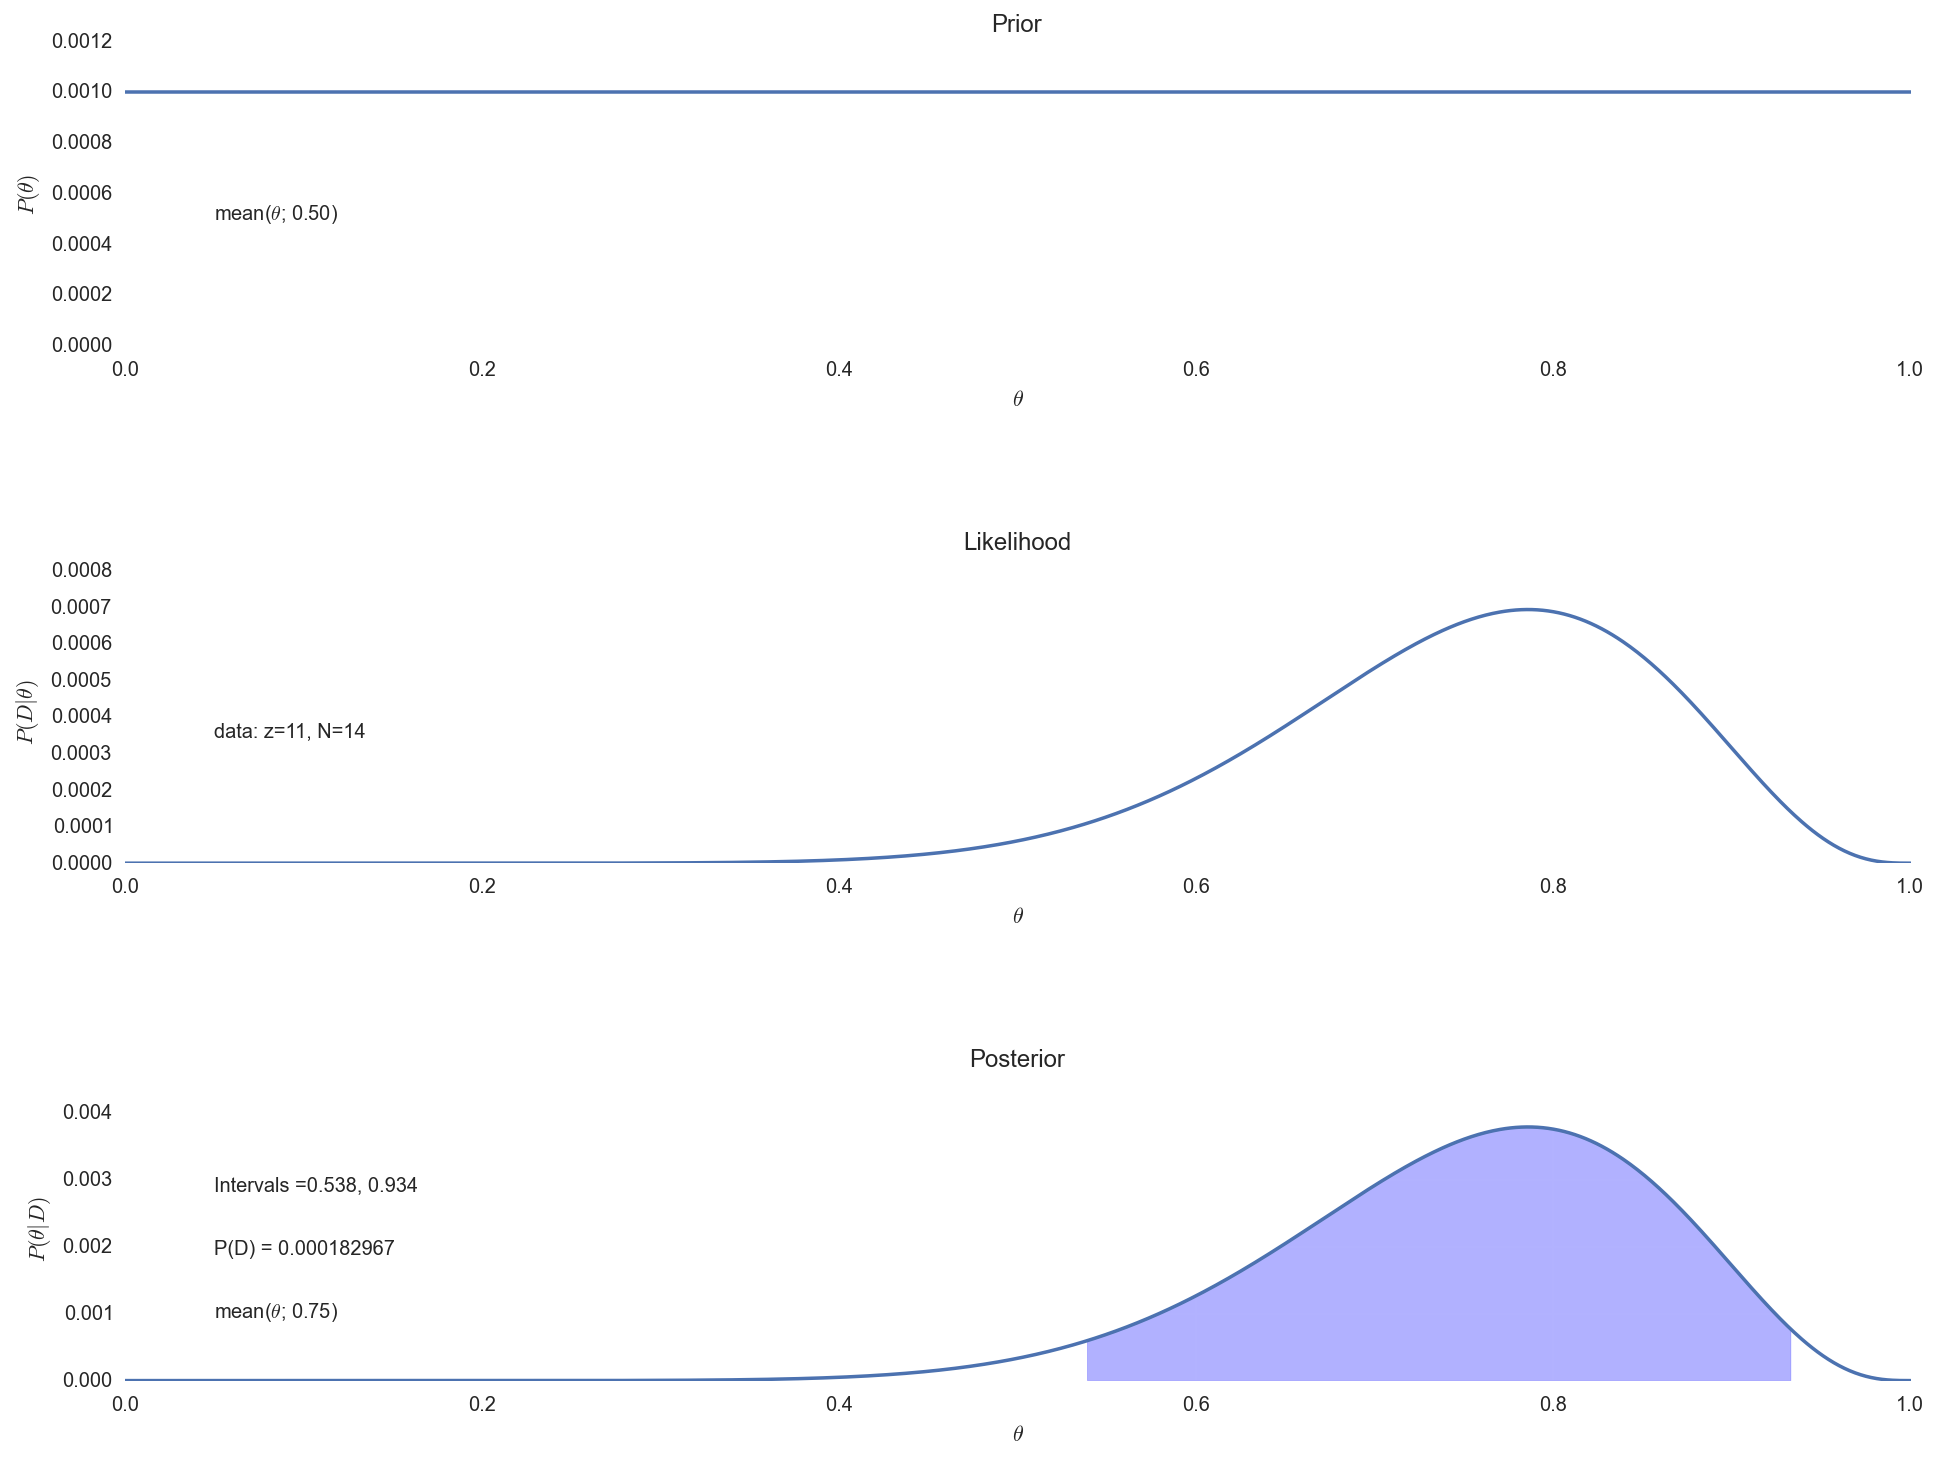

In [29]:
"""
06_BernGrid.py
Inferring a binomial proportion via grid aproximation.
"""

def bern_grid(theta, p_theta, data, credib=.95):
    """
    Bayesian updating for Bernoulli likelihood and prior specified on a grid.
    Input arguments:
     theta is a vector of theta values, all between 0 and 1.
     p_theta is a vector of corresponding probability _masses_.
     data is a vector of 1's and 0's, where 1 corresponds to a and 0 to b.
     credib is the probability mass of the credible interval, default is 0.95.
    Output:
     p_theta_given_data is a vector of posterior probability masses over theta.
     Also creates a three-panel graph of prior, likelihood, and posterior
     probability masses with credible interval.
    Example of use:
     Create vector of theta values.
     bin_width = 1/1000 
     theta_grid = np.arange(0, 1+bin_width, bin_width)
     Specify probability mass at each theta value.
     > rel_prob = np.minimum(theta_grid, 1-theta_grid) relative prob at each theta
     > prior = rel_prob / sum(rel_prob) probability mass at each theta
     Specify the data vector.
     data_vec = np.repeat([1, 0], [11, 3])  # 3 heads, 1 tail
     Call the function.
     > posterior = bern_grid( theta=theta_grid , p_theta=prior , data=data_vec )
    """

# Create summary values of data
    z = sum(data[data == 1])  # number of 1's in data
    N = len(data)  # number of flips in data
# Compute the likelihood of the data for each value of theta.
    p_data_given_theta = theta**z * (1 - theta)**(N - z)
# Compute the evidence and the posterior.
    p_data = sum(p_data_given_theta * p_theta)
    p_theta_given_data = p_data_given_theta * p_theta / p_data
    # Determine the limits of the highest density interval
    x = np.random.choice(theta, size=5000, replace=True, p=p_theta_given_data)
    intervals = hpd(x, alpha=1-credib)

# Plot the results.
    plt.figure(figsize=(16, 12)) # Brian edited
    plt.subplots_adjust(hspace=0.7)

#    # Plot the prior.
    locx = 0.05
    mean_theta = sum(theta * p_theta)  # mean of prior, for plotting
    plt.subplot(3, 1, 1)
    plt.plot(theta, p_theta)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_theta)*1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(\theta)$')
    plt.title('Prior')
    plt.text(locx, np.max(p_theta)/2, r'mean($\theta$;%5.2f)' % mean_theta)
    # Plot the likelihood:
    plt.subplot(3, 1, 2)
    plt.plot(theta, p_data_given_theta)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_data_given_theta)*1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(D|\theta)$')
    plt.title('Likelihood')
    plt.text(locx, np.max(p_data_given_theta)/2, 'data: z=%s, N=%s' % (z, N))
    # Plot the posterior:
    mean_theta_given_data = sum(theta * p_theta_given_data)
    plt.subplot(3, 1, 3)
    plt.plot(theta, p_theta_given_data)
    plt.xlim(0, 1)
    plt.ylim(0, np.max(p_theta_given_data)*1.2)
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$P(\theta|D)$')
    plt.title('Posterior')
    loc = np.linspace(0, np.max(p_theta_given_data), 5)
    plt.text(locx, loc[1], r'mean($\theta$;%5.2f)' % mean_theta_given_data)
    plt.text(locx, loc[2], 'P(D) = %g' % p_data)
    # Plot the HDI
    plt.text(locx, loc[3],
             'Intervals =%s' % ', '.join('%.3f' % x for x in intervals))
    for i in range(0, len(intervals), 2):
        plt.fill_between(theta, 0, p_theta_given_data,
                         where=np.logical_and(theta > intervals[i],
                                              theta < intervals[i+1]),
                         color='blue', alpha=0.3)
    return p_theta_given_data


###Create vector of theta values.
bin_width = 1/1000.
theta_grid = np.arange(0, 1+bin_width, bin_width)
##Specify probability mass at each theta value.
rel_prob = np.array([0.1] * len(theta_grid))  # uniform prior
rel_prob = np.array([0.1] * len(theta_grid))  # uniform prior
prior = rel_prob / sum(rel_prob)  # probability mass at each theta


#### figure 6.2 ###
#np.random.seed(123)
#a = [0.1] * 50
#b = np.linspace(0.1, 1, 50)
#c = np.linspace(1, 0.1, 50)
#d = [0.1] * 50
#p_theta = np.concatenate((a, b, c, d))
#prior = np.where(p_theta != 0 , p_theta / sum(p_theta), 0.)
#width = 1. / len(p_theta)
#theta_grid = np.arange(width/2 , (1-width/2)+width, width)

### figure 6.3 ###
#np.random.seed(123)
#a = np.repeat([0], [50])
#b = np.linspace(0, 1, 50)
#c = (np.linspace(1, 0, 20))**2
#d = np.random.uniform(size=3)
#e = np.repeat([1], [20])
#p_theta = np.concatenate((a, b, c, d, e))
#prior = np.where(p_theta != 0 , p_theta / sum(p_theta), 0.)
#width = 1. / len(p_theta)
#theta_grid = np.arange(width/2 , (1-width/2)+width, width)

###Specify the data vector.
data_vec = np.repeat([1, 0], [11, 3])  # 3 heads, 1 tail
###Call the function.
posterior = bern_grid(theta=theta_grid, p_theta=prior, data=data_vec)

In [4]:
"""plot_post.py"""

def plot_post(param_sample_vec, cred_mass=0.95, comp_val=False,
              ROPE=False, ylab='', xlab='parameter', fontsize=14, labelsize=14,
              title='', framealpha=1, facecolor='skyblue', edgecolor='white',
              show_mode=True, bins=50):
    
    #compute HDI
    HDI = hpd(param_sample_vec, 1-cred_mass)

    post_summary = {'mean':0,'median':0,'mode':0, 'hdi_mass':0,'hdi_low':0,
                   'hdi_high':0, 'comp_val':0, 'pc_gt_comp_val':0, 'ROPE_low':0,
                   'ROPE_high':0, 'pc_in_ROPE':0}
    post_summary['mean'] = np.mean(param_sample_vec)
    post_summary['median'] = np.median(param_sample_vec)
    post_summary['mode'] = stats.mode(param_sample_vec)[0]
    post_summary['hdi_mass'] = cred_mass
    post_summary['hdi_low'] = HDI[0]
    post_summary['hdi_high'] = HDI[1]

    # Plot histogram.
    n, bins, patches = plt.hist(param_sample_vec, normed=True, bins=bins,
                                edgecolor=edgecolor, facecolor=facecolor)
    plt.xlabel(xlab, fontsize=fontsize)
    plt.ylabel(ylab, fontsize=fontsize)
    plt.title(title, fontsize=fontsize)

    cv_ht = 0.75*np.max(n)
    cen_tend_ht = 0.9 * cv_ht
    ROPE_text_ht = 0.55 * cv_ht
#    # Display mean or mode:
    if show_mode:
        plt.plot(0, label='mode = %.2f' % post_summary['mode'], alpha=0)
    else:
        plt.plot(0, label='mean = %.2f' % post_summary['mean'], alpha=0)
    # Display the comparison value.

    if comp_val is not False:
        pc_gt_comp_val = 100 * np.sum(param_sample_vec > comp_val)/len(param_sample_vec)
        pc_lt_comp_val = 100 - pc_gt_comp_val
        plt.plot([comp_val, comp_val], [0, cv_ht], color='darkgreen',
                 linestyle='--', linewidth=2,
                 label='%.1f%% <%.1f < %.1f%%'
                 % (pc_lt_comp_val, comp_val, pc_gt_comp_val))
        post_summary['comp_val'] = comp_val
        post_summary['pc_gt_comp_val'] = pc_gt_comp_val
#    # Display the ROPE.
    if ROPE is not False:
        rope_col = 'darkred'
        pc_in_ROPE = round(np.sum((param_sample_vec > ROPE[0]) & (param_sample_vec < ROPE[1]))/len(param_sample_vec)*100)
        plt.plot([ROPE[0], ROPE[0]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4,
                label='%.1f%% in ROPE' % pc_in_ROPE)
        plt.plot([ROPE[1], ROPE[1]], [0, 0.96*ROPE_text_ht], color=rope_col,
                linestyle=':', linewidth=4)
        post_summary['ROPE_low'] = ROPE[0] 
        post_summary['ROPE_high'] = ROPE[1] 
        post_summary['pc_in_ROPE'] = pc_in_ROPE
#    # Display the HDI.
    plt.plot(HDI, [0, 0], linewidth=6, color='k', label='HDI %.1f%% %.3f-%.3f' % (cred_mass*100, HDI[0], HDI[1]))
    plt.legend(loc='upper left', fontsize=labelsize, framealpha=framealpha)
    return post_summary

theta_sample [ 0.5         0.5         0.5        ...,  0.80979487  0.80979487
  0.80979487]


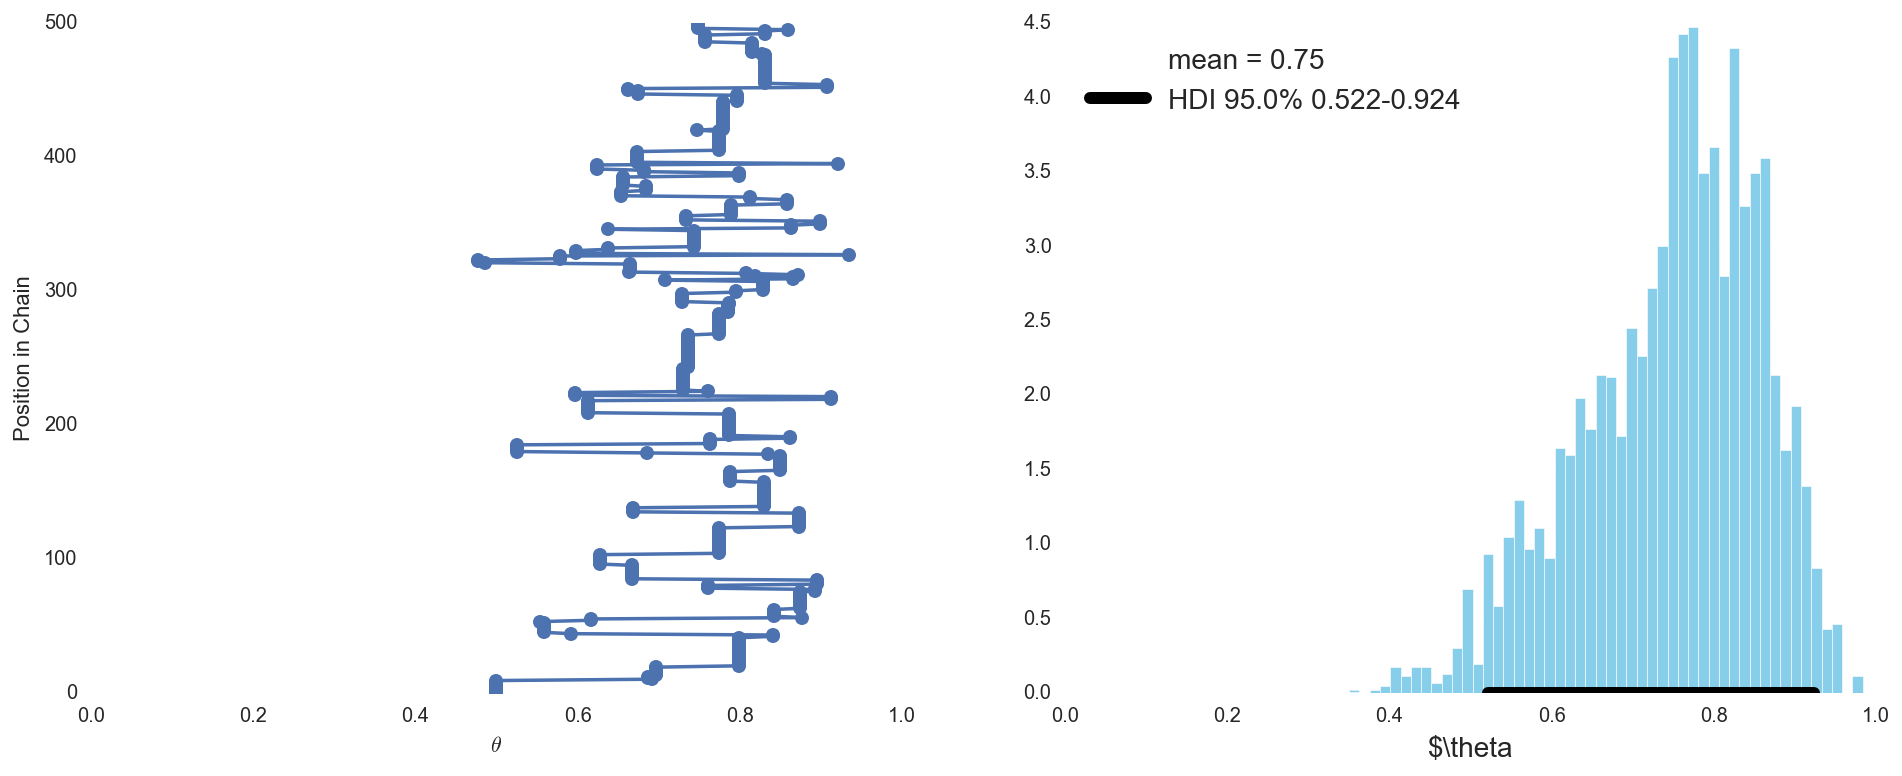

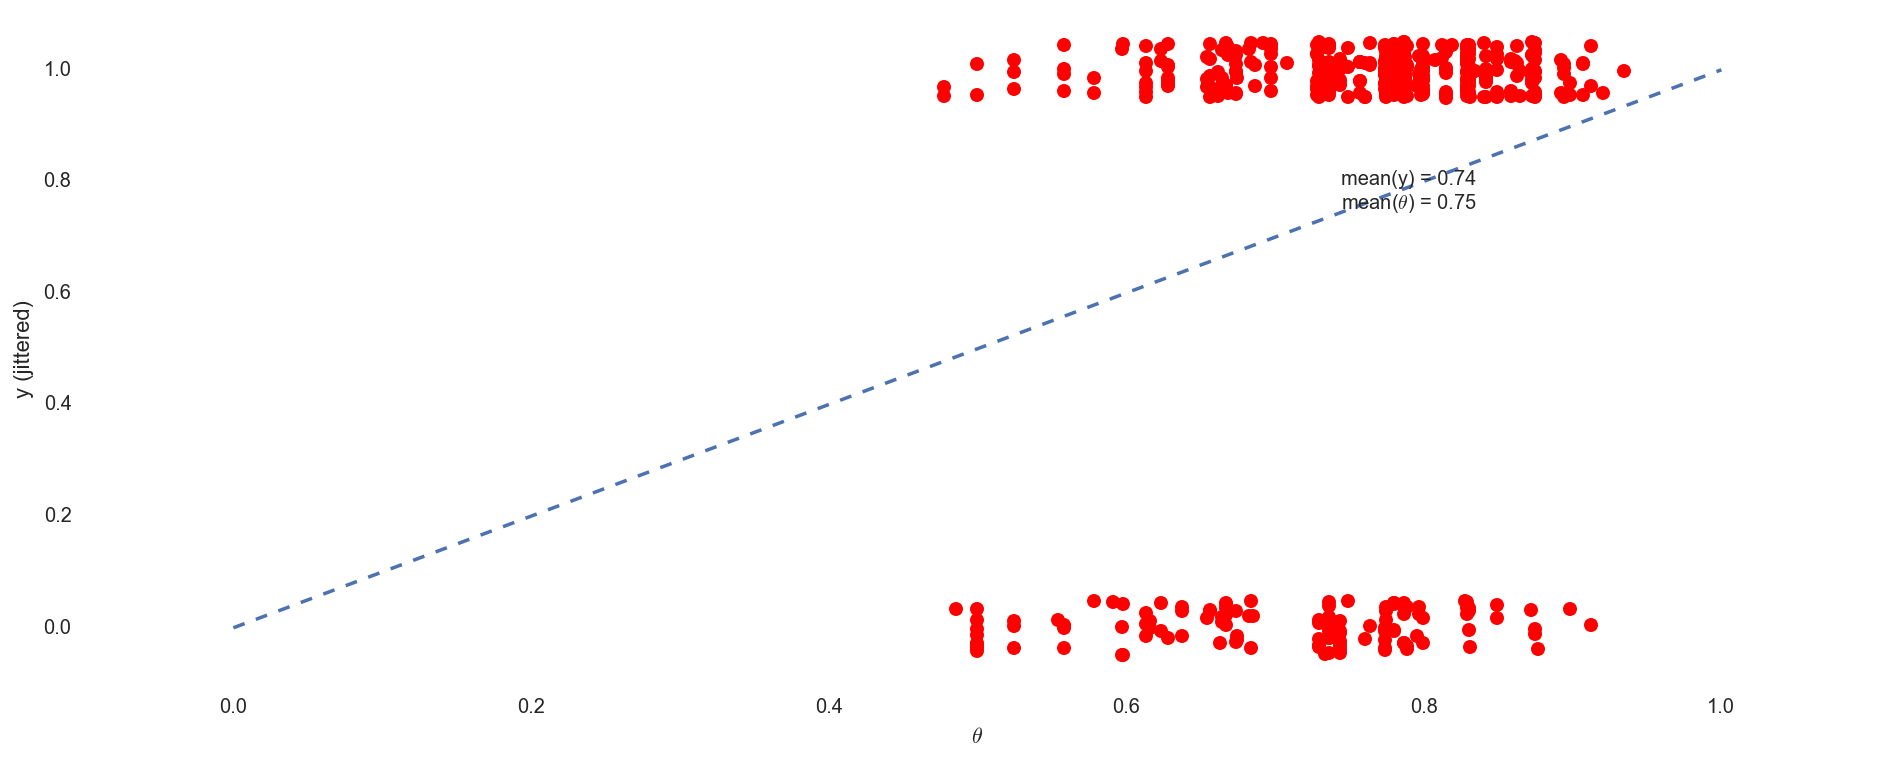

In [31]:
"""
07_BernBetaPyMCFull.py
Inferring a binomial proportion using PyMC.
"""
# Generate the data
y = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0])  # 11 heads and 3 tails


with pm.Model() as model:
    # define the prior
    theta = pm.Beta('theta', 1, 1)  # prior
    # define the likelihood
    y = pm.Bernoulli('y', p=theta, observed=y)

    # Generate a MCMC chain
    trace = pm.sample(5000, pm.Metropolis(),
                      progressbar=False)  # Use Metropolis sampling
#    start = pm.find_MAP()  # Find starting value by optimization
#    step = pm.NUTS()  # Instantiate NUTS sampler
#    trace = pm.sample(5000, step, start=start, progressbar=False)

# create an array with the posterior sample
theta_sample = trace['theta']

print "theta_sample", theta_sample
plt.figure(figsize=(16,6)) # Brian added

plt.subplot(1, 2, 1)
plt.plot(theta_sample[:500], np.arange(500), marker='o')
plt.xlim(0, 1)
plt.xlabel(r'$\theta$')
plt.ylabel('Position in Chain')

plt.subplot(1, 2, 2)
mcmc_info = plot_post(theta_sample, xlab=r'$\theta', show_mode=False)

# Posterior prediction:
# For each step in the chain, use posterior theta to flip a coin:
y_pred = np.zeros(len(theta_sample))
for i, p_head in enumerate(theta_sample):
    y_pred[i] = np.random.choice([0, 1], p=[1 - p_head, p_head])

# Jitter the 0,1 y values for plotting purposes:
y_pred_jittered = y_pred + np.random.uniform(-.05, .05, size=len(theta_sample))

# Now plot the jittered values:
plt.figure(figsize=(16,6)) # Brian added

plt.plot(theta_sample[:500], y_pred_jittered[:500], 'ro')
plt.xlim(-.1, 1.1)
plt.ylim(-.1, 1.1)
plt.xlabel(r'$\theta$')
plt.ylabel('y (jittered)')

mean_y = np.mean(y_pred)
mean_theta = np.mean(theta_sample)

plt.plot(mean_y, mean_theta, 'k+', markersize=15)
plt.annotate('mean(y) = %.2f\nmean($\\theta$) = %.2f' %
    (mean_y, mean_theta), xy=(mean_y, mean_theta))
plt.plot([0, 1], [0, 1], linestyle='--')

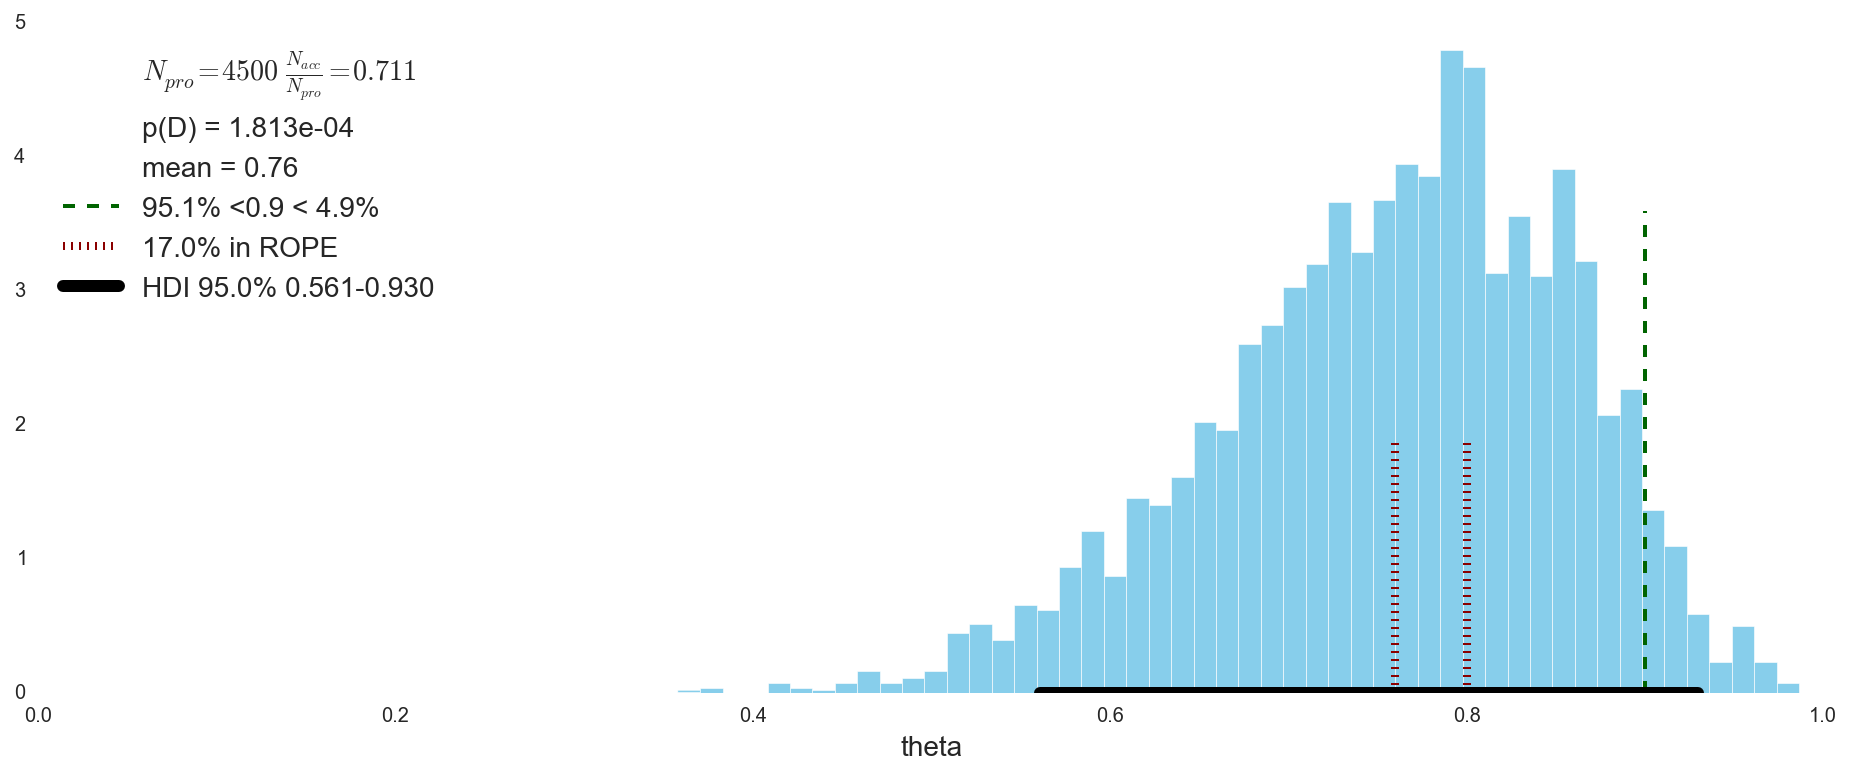

In [32]:
"""
07_BernMetropolisTemplate.py
Use this program as a template for experimenting with the Metropolis algorithm
applied to a single parameter called theta, defined on the interval [0,1].
"""

# Specify the data, to be used in the likelihood function.
# This is a vector with one component per flip,
# in which 1 means a "head" and 0 means a "tail".
my_data = np.repeat([1, 0], [11, 3])  # 11 heads, 2 tail

# Define the Bernoulli likelihood function, p(D|theta).
# The argument theta could be a vector, not just a scalar.
def likelihood(theta, data):
    theta = np.array(theta) # ensure you have an array
    z = sum(data[data == 1])  # number of 1's in Data
    N = len(data)  # number of flips in Data
# Compute the likelihood of the Data for each value of Theta.
    if np.size(theta) == 1:  # if theta is an scalar
        p_data_given_theta = 0
        if theta < 1 and theta > 0:
            p_data_given_theta = theta**z * (1-theta)**(N-z)
    else: # if theta is an array
        p_data_given_theta = theta**z * (1-theta)**(N-z)
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        p_data_given_theta[(theta > 1) | (theta < 0)] = 0
    return p_data_given_theta


# Define the prior density function. For purposes of computing p(D),
# at the end of this program, we want this prior to be a proper density.
# The argument theta could be a vector, not just a scalar.
def prior(theta):
    theta = np.array(theta) # ensure you have an array
# For kicks, here's a bimodal prior. To try it, uncomment the next 2 lines.
    #from scipy.stats import beta
    #prior = dbeta(np.minium(2*theta, 2*(1-theta)), 2, 2)
    if np.size(theta) == 1:  # if theta is an scalar
        prior = 0
        if theta < 1 and theta > 0:
            prior = 1
    else: # if theta is an array
        prior = np.ones(len(theta))  # uniform density over [0,1]
        # The theta values passed into this function are generated at random,
        # and therefore might be inadvertently greater than 1 or less than 0.
        # The likelihood for theta > 1 or for theta < 0 is zero:
        prior[(theta > 1) | (theta < 0)] = 0
    return prior



# Define the relative probability of the target distribution, 
# as a function of vector theta. For our application, this
# target distribution is the unnormalized posterior distribution.
def target_rel_prob(theta, data):
    target_rel_prob = likelihood(theta , data) * prior(theta)
    return target_rel_prob

# Specify the length of the trajectory, i.e., the number of jumps to try:
traj_length = 5000 # arbitrary large number
# Initialize the vector that will store the results:
trajectory = np.zeros(traj_length)
# Specify where to start the trajectory:
trajectory[0] = 0.50 # arbitrary value
# Specify the burn-in period:
burn_in = np.ceil(0.1 * traj_length) # arbitrary number, less than traj_length
# Initialize accepted, rejected counters, just to monitor performance:
n_accepted = 0
n_rejected = 0
# Specify seed to reproduce same random walk:
np.random.seed(4745)

# Now generate the random walk. The 't' index is time or trial in the walk.
for t in range(traj_length-1):
    current_position = trajectory[t]
    # Use the proposal distribution to generate a proposed jump.
    # The shape and variance of the proposal distribution can be changed
    # to whatever you think is appropriate for the target distribution.
    proposed_jump = np.random.normal(loc=0 , scale=0.1, size=1)
    
#    # Compute the probability of accepting the proposed jump.
    prob_accept = np.minimum(1, 
                            target_rel_prob(current_position + proposed_jump, my_data)
                            / target_rel_prob(current_position, my_data))
#    # Generate a random uniform value from the interval [0,1] to
#    # decide whether or not to accept the proposed jump.
    if np.random.rand() < prob_accept:
        # accept the proposed jump
        trajectory[t+1] = current_position + proposed_jump
        # increment the accepted counter, just to monitor performance
        if t > burn_in:
            n_accepted += 1
    else:
        # reject the proposed jump, stay at current position
        trajectory[t+1] = current_position
        # increment the rejected counter, just to monitor performance
        if t > burn_in:
            n_rejected += 1


# Extract the post-burn_in portion of the trajectory.
accepted_traj = trajectory[burn_in:]
# End of Metropolis algorithm.



# Display rejected/accepted ratio in the plot.
mean_traj = np.mean(accepted_traj)
std_traj = np.std(accepted_traj)

plt.figure(figsize=(16,6)) # Brian added

plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)

# Evidence for model, p(D).

# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is Bernoulli.
a = mean_traj * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)
b = (1 - mean_traj) * ((mean_traj*(1 - mean_traj)/std_traj**2) - 1)

# For every theta value in the posterior sample, compute 
# dbeta(theta,a,b) / likelihood(theta)*prior(theta)
# This computation assumes that likelihood and prior are proper densities,
# i.e., not just relative probabilities. This computation also assumes that
# the likelihood and prior functions were defined to accept a vector argument,
# not just a single-component scalar argument.
wtd_evid = beta.pdf(accepted_traj, a, b) / (likelihood(accepted_traj, my_data) * prior(accepted_traj))
p_data = 1 / np.mean(wtd_evid)


# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)

# Display the posterior.
ROPE = np.array([0.76, 0.8])
mcmc_info = plot_post(accepted_traj, xlab='theta', show_mode=False, comp_val=0.9, ROPE=ROPE)


In [33]:
"""
HDI_of_grid.py
Arguments:
probMassVec is a vector of probability masses at each grid point.
credMass is the desired mass of the HDI region.
Return a dictionary with:
indices is a vector of indices that are in the HDI
mass is the total mass of the included indices
height is the smallest component probability mass in the HDI
"""

def HDI_of_grid(probMassVec, credMass=0.95):
    sortedProbMass = np.sort(probMassVec, axis=None)[::-1]
    HDIheightIdx = np.min(np.where(np.cumsum(sortedProbMass) >= credMass))
    HDIheight = sortedProbMass[HDIheightIdx]
    HDImass = np.sum(probMassVec[probMassVec >= HDIheight])
    idx = np.where(probMassVec >= HDIheight)
    return {'indices':idx, 'mass':HDImass, 'height':HDIheight}

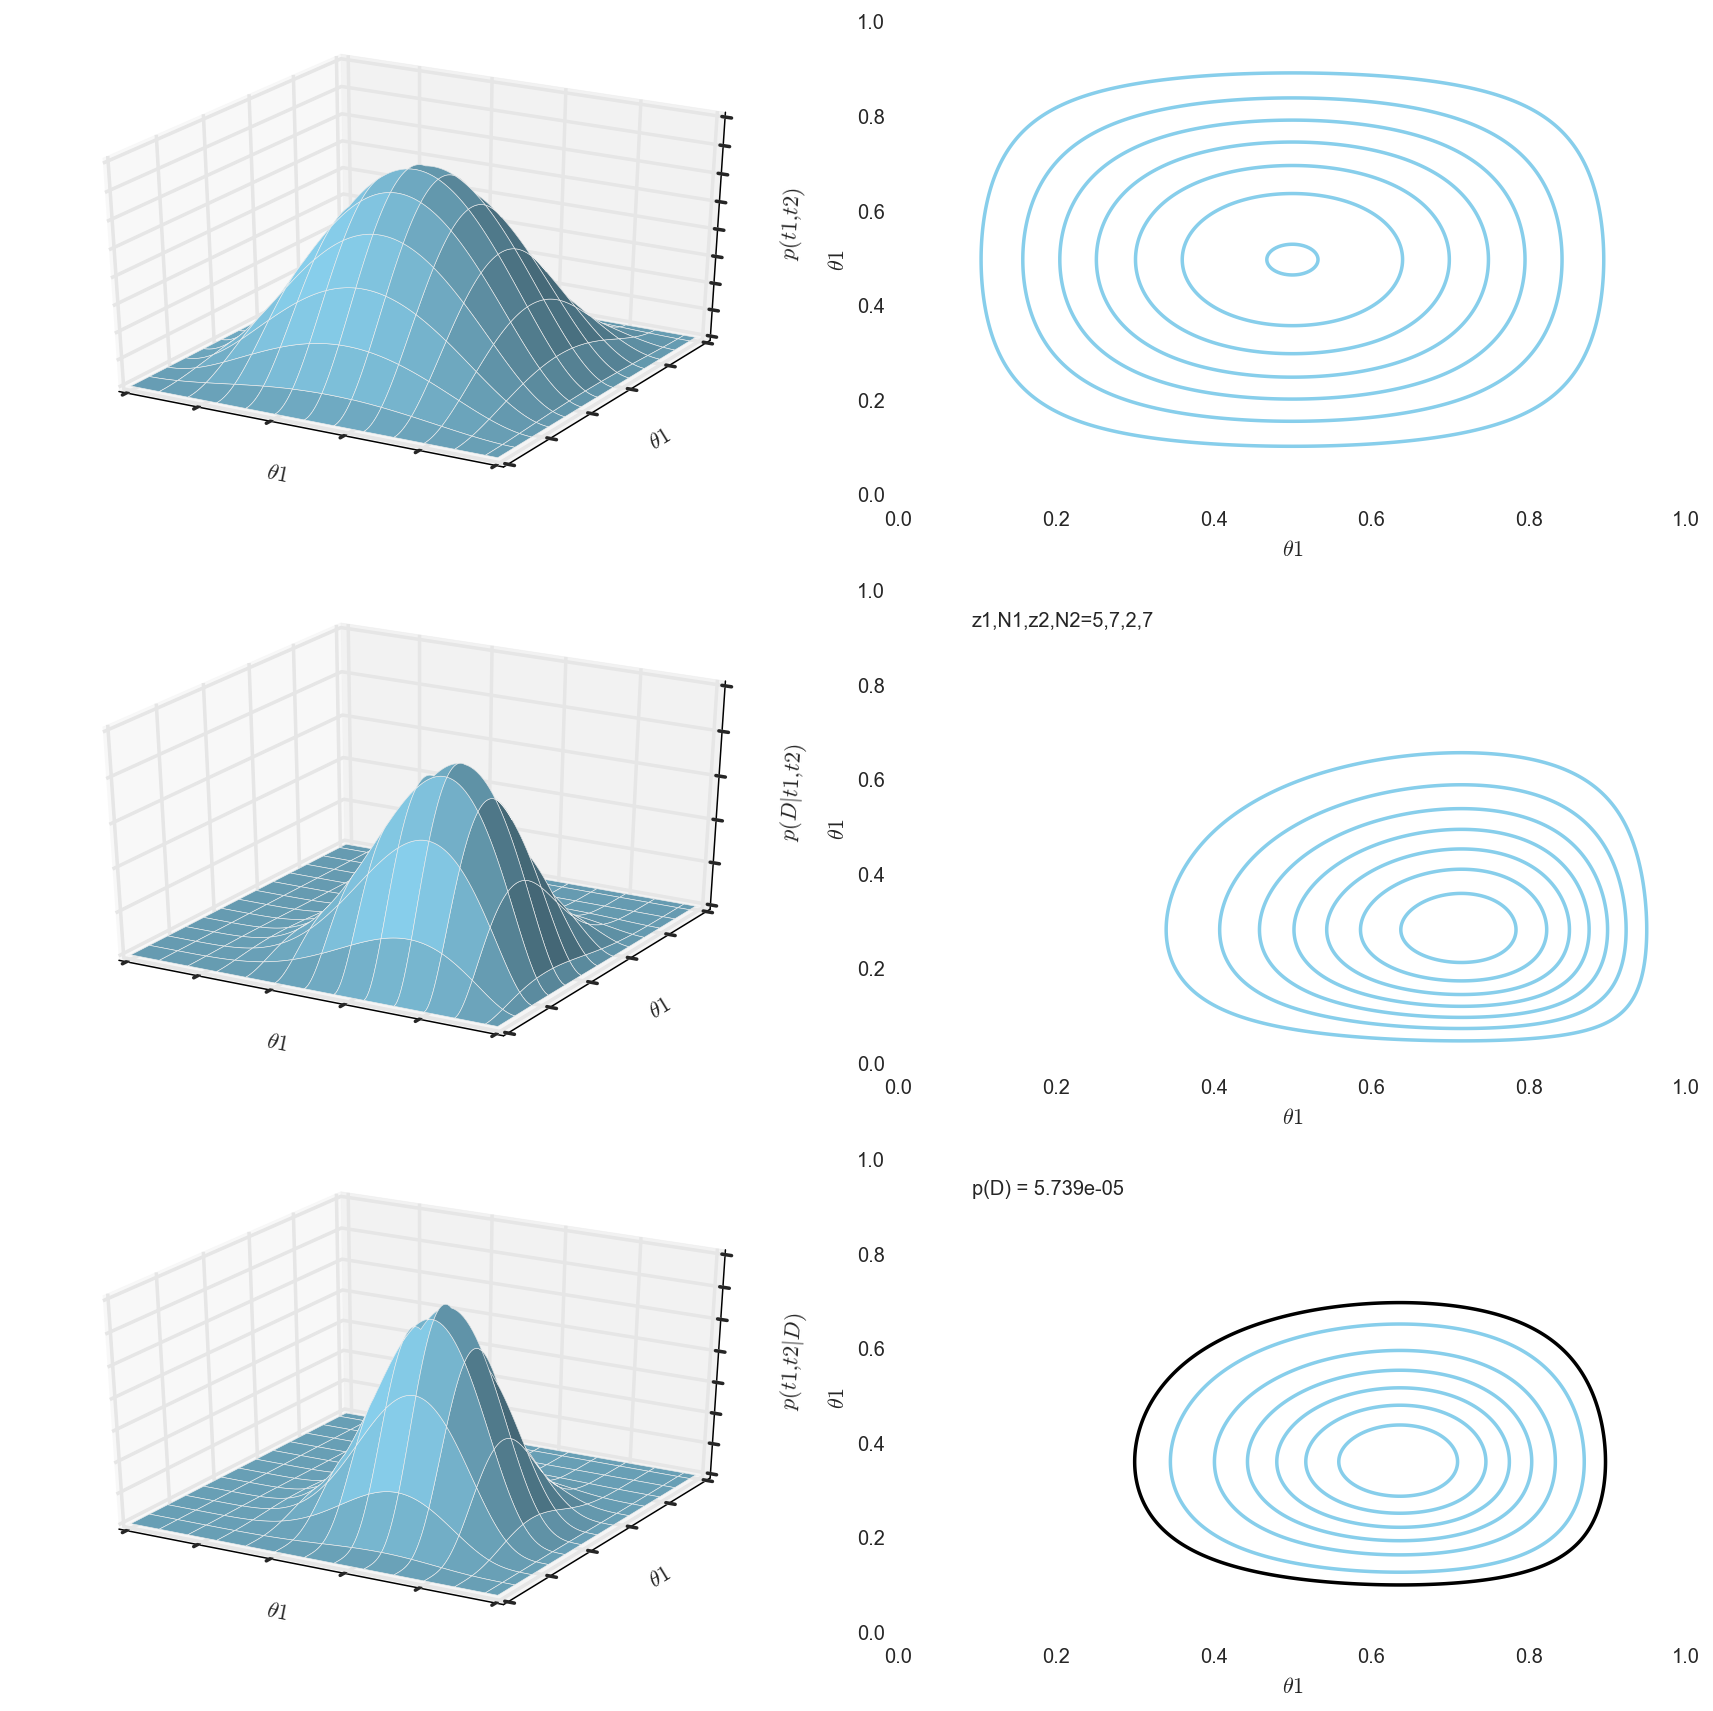

In [34]:
"""
08_BernTwoGrid.py
Inferring two binomial proportions via grid aproximation.
"""

# Specify the grid on theta1,theta2 parameter space.
n_int = 500  # arbitrary number of intervals for grid on theta.
theta1 = np.linspace(0, 1, n_int)
theta2 = theta1

theta1_grid, theta2_grid = np.meshgrid(theta1, theta2)

# Specify the prior probability _masses_ on the grid.
prior_name = ("Beta","Ripples","Null","Alt")[0]  # or define your own.
if prior_name == "Beta":
    a1, b1, a2, b2 = 3, 3, 3, 3
    prior1 = beta.pdf(theta1_grid, a1, b1)
    prior2 = beta.pdf(theta2_grid, a1, b1)
    prior = prior1 * prior2
    prior = prior / np.sum(prior)

if prior_name == "Ripples":
    m1, m2, k = 0, 1, 0.75 * np.pi
    prior = np.sin((k*(theta1_grid-m1))**2 + (k*(theta2_grid-m2))**2)**2
    prior = prior / np.sum(prior)

if prior_name == "Null":
    # 1's at theta1=theta2, 0's everywhere else:
    prior = np.eye(len(theta1_grid), len(theta2_grid))
    prior = prior / np.sum(prior)

if prior_name == "Alt":
#    # Uniform:
    prior = np.ones((len(theta1_grid), len(theta2_grid)))
    prior = prior / np.sum(prior)

# Specify likelihood
z1, N1, z2, N2 = 5, 7, 2, 7  # data are specified here
likelihood = theta1_grid**z1 * (1-theta1_grid)**(N1-z1) * theta2_grid**z2 * (1-theta2_grid)**(N2-z2)

# Compute posterior from point-by-point multiplication and normalizing:
p_data = np.sum(prior * likelihood)
posterior = (prior * likelihood) / p_data

# Specify the probability mass for the HDI region
credib = .95
thin = 4
color = 'skyblue'

fig = plt.figure(figsize=(12,12))

# prior
ax = fig.add_subplot(3, 2, 1, projection='3d')
ax.plot_surface(theta1_grid[::thin,::thin], theta2_grid[::thin,::thin], prior[::thin,::thin], color=color)
ax.set_xlabel(r'$\theta1$')
ax.set_ylabel(r'$\theta1$')
ax.set_zlabel(r'$p(t1,t2)$')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.subplot(3, 2, 2)
plt.contour(theta1_grid, theta2_grid, prior, colors=color)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\theta1$')

# likelihood
ax = fig.add_subplot(3, 2, 3, projection='3d')
ax.plot_surface(theta1_grid[::thin,::thin], theta2_grid[::thin,::thin], likelihood[::thin,::thin], color=color)
ax.set_xlabel(r'$\theta1$')
ax.set_ylabel(r'$\theta1$')
ax.set_zlabel(r'$p(D|t1,t2)$')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.subplot(3, 2, 4)
plt.contour(theta1_grid, theta2_grid, likelihood, colors=color)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\theta1$')
plt.plot(0, label='z1,N1,z2,N2=%s,%s,%s,%s' % (z1, N1, z2, N2), alpha=0)
plt.legend(loc='upper left')

# posterior
ax = fig.add_subplot(3, 2, 5, projection='3d')
ax.plot_surface(theta1_grid[::thin,::thin], theta2_grid[::thin,::thin],posterior[::thin,::thin], color=color)
ax.set_xlabel(r'$\theta1$')
ax.set_ylabel(r'$\theta1$')
ax.set_zlabel(r'$p(t1,t2|D)$')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

plt.subplot(3, 2, 6)
plt.contour(theta1_grid, theta2_grid, posterior, colors=color)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\theta1$')
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)
plt.legend(loc='upper left')

# Mark the highest posterior density region
HDI_height = HDI_of_grid(posterior)['height']
plt.contour(theta1_grid, theta2_grid, posterior, levels=[HDI_height], colors='k')

plt.tight_layout()

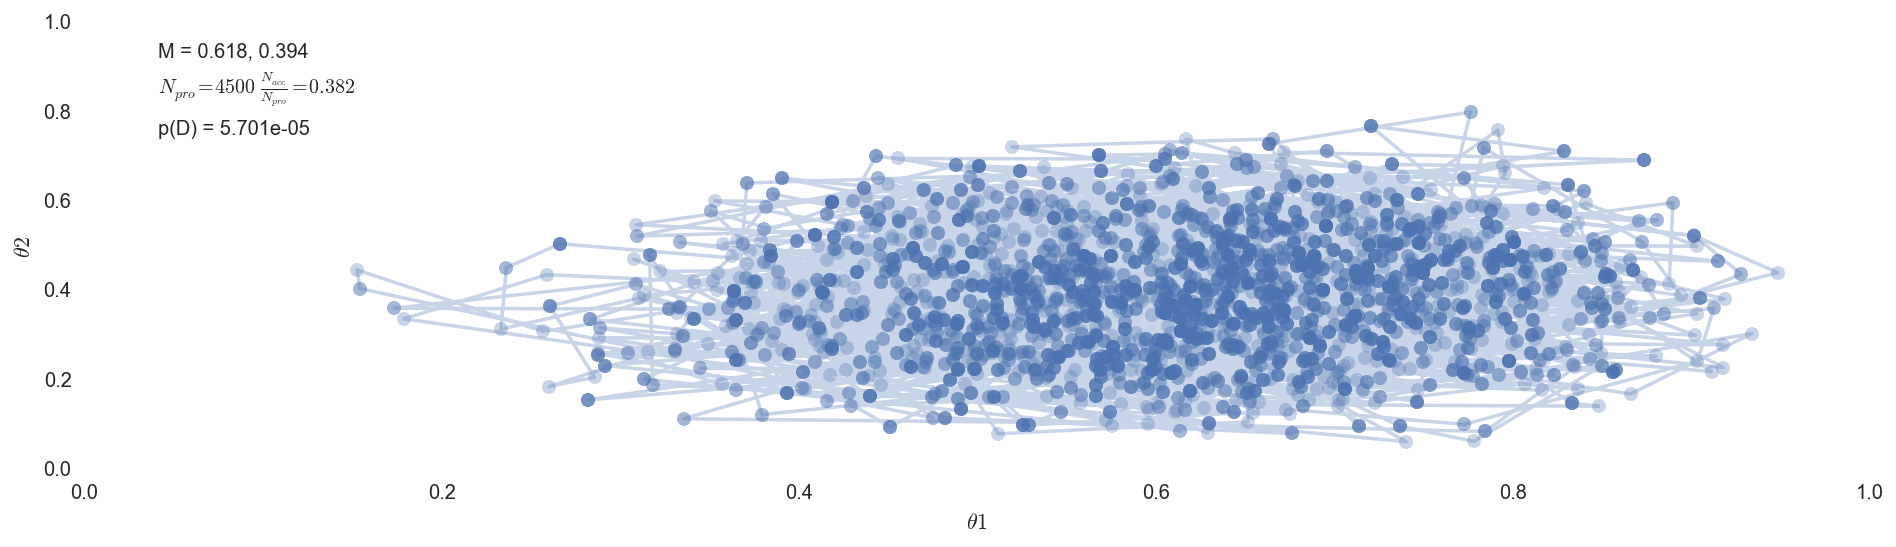

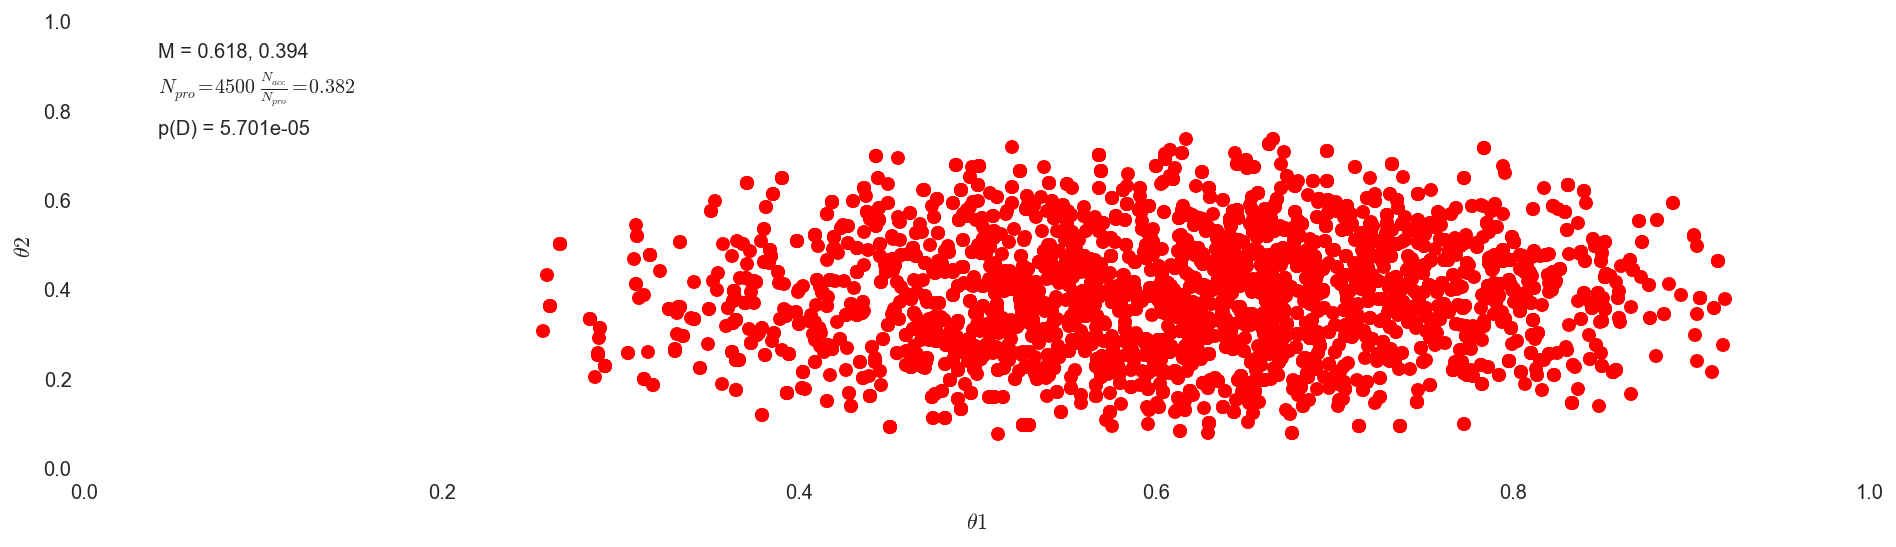

In [6]:
"""
08_BernTwoMetropolis.py
Use this program as a template for experimenting with the Metropolis algorithm
applied to 2 parameters called theta1,theta2 defined on the domain [0,1]x[0,1].
"""

# Define the likelihood function.
# The input argument is a vector: theta = [theta1 , theta2]

def likelihood(theta):
    # Data are constants, specified here:
    z1, N1, z2, N2 = 5, 7, 2, 7
    likelihood = (theta[0]**z1 * (1-theta[0])**(N1-z1)
                 * theta[1]**z2 * (1-theta[1])**(N2-z2))
    return likelihood


# Define the prior density function.
# The input argument is a vector: theta = [theta1 , theta2]
def prior(theta):
    # Here's a beta-beta prior:
    a1, b1, a2, b2 = 3, 3, 3, 3
    prior = beta.pdf(theta[0], a1, b1) * beta.pdf(theta[1], a2, b2) 
    return prior


# Define the relative probability of the target distribution, as a function 
# of theta.  The input argument is a vector: theta = [theta1 , theta2].
# For our purposes, the value returned is the UNnormalized posterior prob.
def target_rel_prob(theta):
    if ((theta >= 0.0).all() & (theta <= 1.0).all()):
        target_rel_probVal =  likelihood(theta) * prior(theta)
    else:
        # This part is important so that the Metropolis algorithm
        # never accepts a jump to an invalid parameter value.
        target_rel_probVal = 0.0
    return target_rel_probVal
#    if ( all( theta >= 0.0 ) & all( theta <= 1.0 ) ) {
#        target_rel_probVal =  likelihood( theta ) * prior( theta )


# Specify the length of the trajectory, i.e., the number of jumps to try:
traj_length = 5000 # arbitrary large number
# Initialize the vector that will store the results.
trajectory = np.zeros((traj_length, 2))
# Specify where to start the trajectory
trajectory[0, ] = [0.50, 0.50] # arbitrary start values of the two param's
# Specify the burn-in period.
burn_in = np.ceil(.1 * traj_length) # arbitrary number
# Initialize accepted, rejected counters, just to monitor performance.
n_accepted = 0
n_rejected = 0
# Specify the seed, so the trajectory can be reproduced.
np.random.seed(47405)
# Specify the covariance matrix for multivariate normal proposal distribution.
n_dim, sd1, sd2 = 2, 0.2, 0.2
covar_mat = [[sd1**2, 0], [0, sd2**2]]

# Now generate the random walk. step is the step in the walk.
for step in range(traj_length-1):
    current_position = trajectory[step, ]
    # Use the proposal distribution to generate a proposed jump.
    # The shape and variance of the proposal distribution can be changed
    # to whatever you think is appropriate for the target distribution.
    proposed_jump = np.random.multivariate_normal(mean=np.zeros((n_dim)),
                                                 cov=covar_mat)
    # Compute the probability of accepting the proposed jump.
    prob_accept = np.minimum(1, target_rel_prob(current_position + proposed_jump)
                            / target_rel_prob(current_position))
    # Generate a random uniform value from the interval [0,1] to
    # decide whether or not to accept the proposed jump.
    if np.random.rand() < prob_accept:
        # accept the proposed jump
        trajectory[step+1, ] = current_position + proposed_jump
        # increment the accepted counter, just to monitor performance
        if step > burn_in:
            n_accepted += 1
    else:
        # reject the proposed jump, stay at current position
        trajectory[step+1, ] = current_position
        # increment the rejected counter, just to monitor performance
        if step > burn_in:
            n_rejected += 1

# End of Metropolis algorithm.

#-----------------------------------------------------------------------
# Begin making inferences by using the sample generated by the
# Metropolis algorithm.

# Extract just the post-burnIn portion of the trajectory.
accepted_traj = trajectory[burn_in:]

# Compute the means of the accepted points.
mean_traj =  np.mean(accepted_traj, axis=0)
# Compute the standard deviations of the accepted points.
stdTraj =  np.std(accepted_traj, axis=0)

# Plot the trajectory of the last 500 sampled values.
plt.figure(figsize=(16,4))
plt.plot(accepted_traj[:,0], accepted_traj[:,1], marker='o', alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\theta2$')

# Display means in plot.
plt.plot(0, label='M = %.3f, %.3f' % (mean_traj[0], mean_traj[1]), alpha=0.0)
# Display rejected/accepted ratio in the plot.
plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)

# Evidence for model, p(D).
# Compute a,b parameters for beta distribution that has the same mean
# and stdev as the sample from the posterior. This is a useful choice
# when the likelihood function is binomial.
a =   mean_traj * ((mean_traj*(1-mean_traj)/stdTraj**2) - np.ones(n_dim))
b = (1-mean_traj) * ( (mean_traj*(1-mean_traj)/stdTraj**2) - np.ones(n_dim))
# For every theta value in the posterior sample, compute 
# beta.pdf(theta, a, b) / likelihood(theta) * prior(theta)
# This computation assumes that likelihood and prior are properly normalized,
# i.e., not just relative probabilities.

wtd_evid = np.zeros(np.shape(accepted_traj)[0])
for idx in range(np.shape(accepted_traj)[0]):
    wtd_evid[idx] = (beta.pdf(accepted_traj[idx,0],a[0],b[0] )
        * beta.pdf(accepted_traj[idx,1],a[1],b[1]) /
        (likelihood(accepted_traj[idx,]) * prior(accepted_traj[idx,])))

p_data = 1 / np.mean(wtd_evid)
# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)
plt.legend(loc='upper left')

# Estimate highest density region by evaluating posterior at each point.
accepted_traj = trajectory[burn_in:]
npts = np.shape(accepted_traj)[0] 
post_prob = np.zeros((npts))
for ptIdx in range(npts):
    post_prob[ptIdx] = target_rel_prob(accepted_traj[ptIdx,])

# Determine the level at which credmass points are above:
credmass = 0.95
waterline = np.percentile(post_prob, (credmass))

HDI_points = accepted_traj[post_prob > waterline, ]

plt.figure(figsize=(16,4))
plt.plot(HDI_points[:,0], HDI_points[:,1], 'ro')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\theta2$')

# Display means in plot.
plt.plot(0, label='M = %.3f, %.3f' % (mean_traj[0], mean_traj[1]), alpha=0.0)
# Display rejected/accepted ratio in the plot.
plt.plot(0, label=r'$N_{pro}=%s$ $\frac{N_{acc}}{N_{pro}} = %.3f$' % (len(accepted_traj), (n_accepted/len(accepted_traj))), alpha=0)
# Display p(D) in the graph
plt.plot(0, label='p(D) = %.3e' % p_data, alpha=0)
plt.legend(loc='upper left')

Exercise 8.5:	P(Y1==1, Y2==0) 0.382


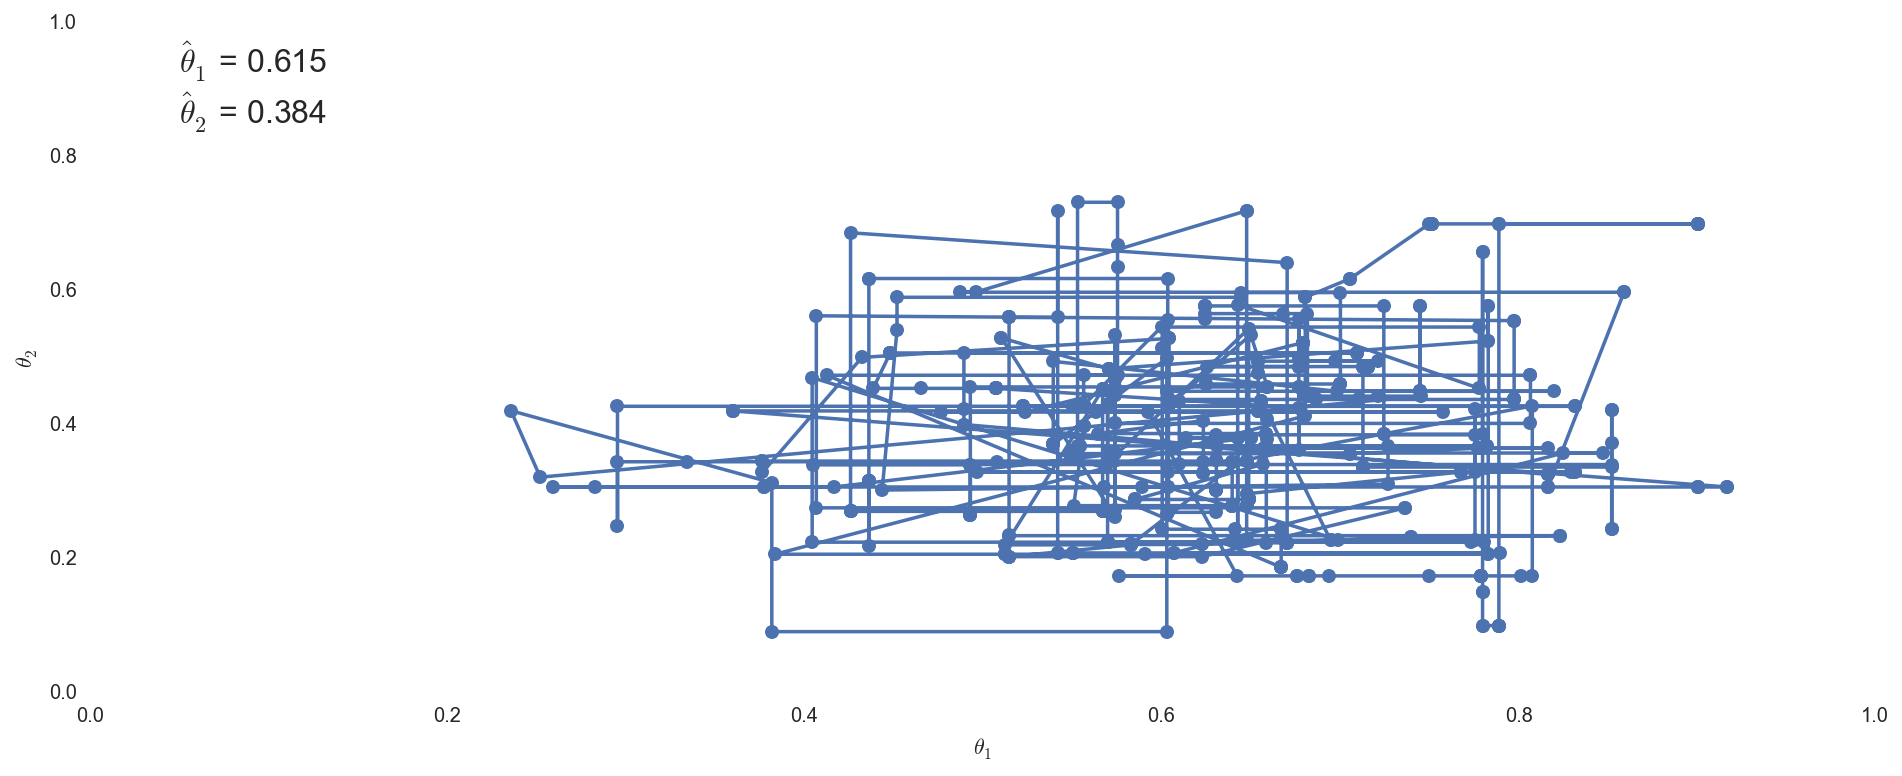

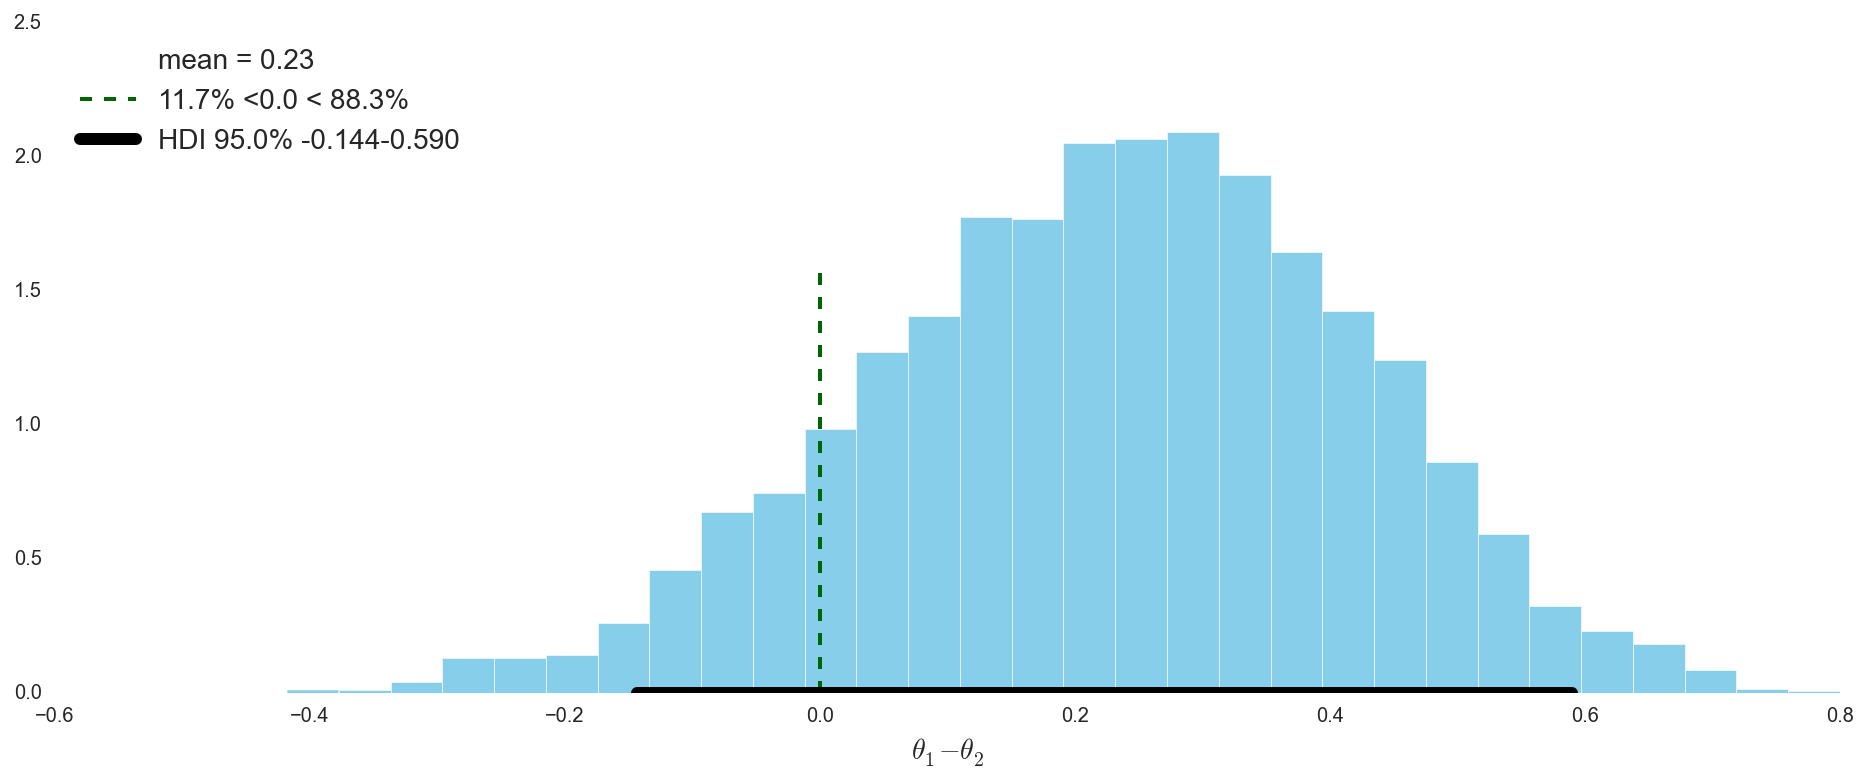

In [67]:
"""
08_BernTwoPyMC.py
Inferring two binomial proportions using PyMC.
"""

burnin_len, chain_len = 500, 9500

# Generate the data, 5 heads and 2 tails and vice versa
TAIL, HEAD = 0, 1
y1_data = np.array([HEAD]*5 + [TAIL]*2)
y2_data = np.array([HEAD]*2 + [TAIL]*5)

with pm.Model() as model:
    # define the prior
    theta1 = pm.Beta('theta1', 3, 3) # P(HEAD)
    theta2 = pm.Beta('theta2', 3, 3) # P(HEAD)
    # define the likelihood
    y1 = pm.Bernoulli('y1', p=theta1, observed=y1_data)
    y2 = pm.Bernoulli('y2', p=theta2, observed=y2_data)
    # Generate an MCMC chain
    step = [pm.Metropolis(), pm.NUTS()][0]
    start = pm.find_MAP()  # Find starting value by optimization
    trace = pm.sample(burnin_len + chain_len, step, start=start, progressbar=False)

# create an array with the posterior sample
theta1_sample = trace['theta1'][burnin_len:]
theta2_sample = trace['theta2'][burnin_len:]

# Plot the trajectory of the last 500 sampled values.
plt.figure(figsize=(16,6))
plt.plot(theta1_sample[-500:], theta2_sample[-500:], marker='o')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')

# Display means in plot.
plt.text(0.05, 0.85, r'$\hat{\theta}_1$ = %.3f' % np.mean(theta1_sample) + '\n' + \
                     r'$\hat{\theta}_2$ = %.3f' % np.mean(theta2_sample), fontsize=16)

# Plot a histogram of the posterior differences of theta values.
plt.figure(figsize=(16,6))
theta_diff = theta1_sample - theta2_sample
plot_post(theta_diff, xlab=r'$\theta_1-\theta_2$', comp_val=0.0, show_mode=False, bins=30)

# For Exercise 8.5:
# Posterior prediction. For each step in the chain, use the posterior thetas 
# to flip the coins.
pY1eq1andY2eq0 = np.sum((np.random.random(chain_len) <= theta1_sample) &
                        (np.random.random(chain_len) > theta2_sample)) / chain_len

print "Exercise 8.5:\tP(Y1==1, Y2==0) %.3f" % pY1eq1andY2eq0

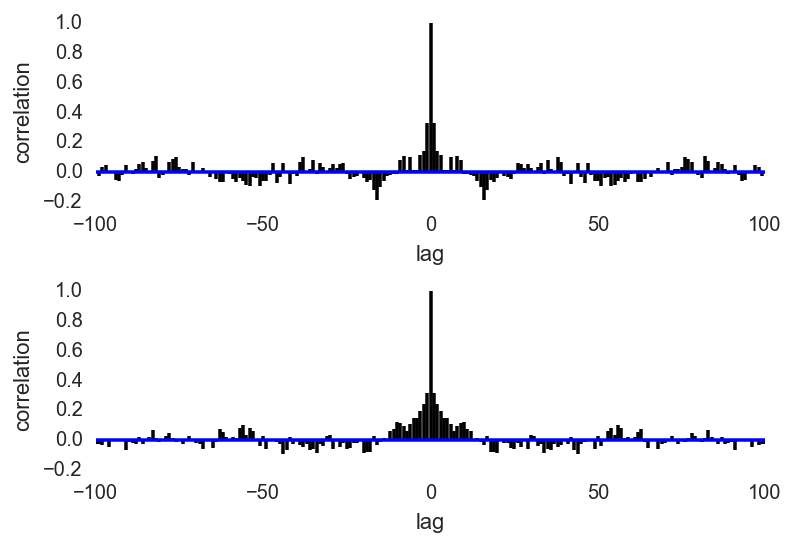

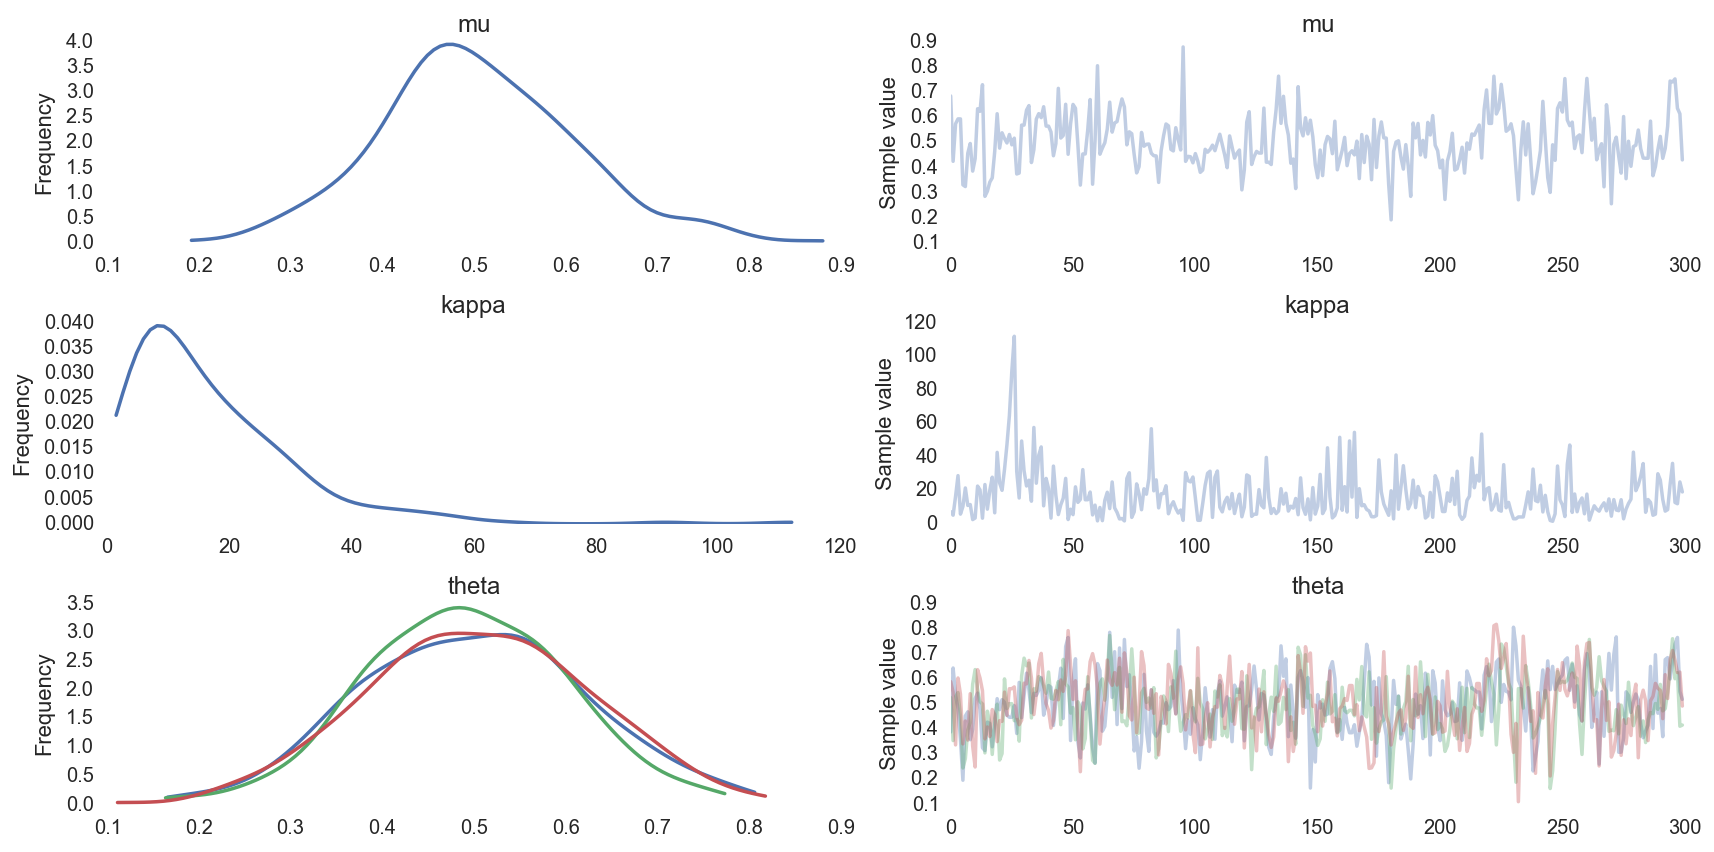

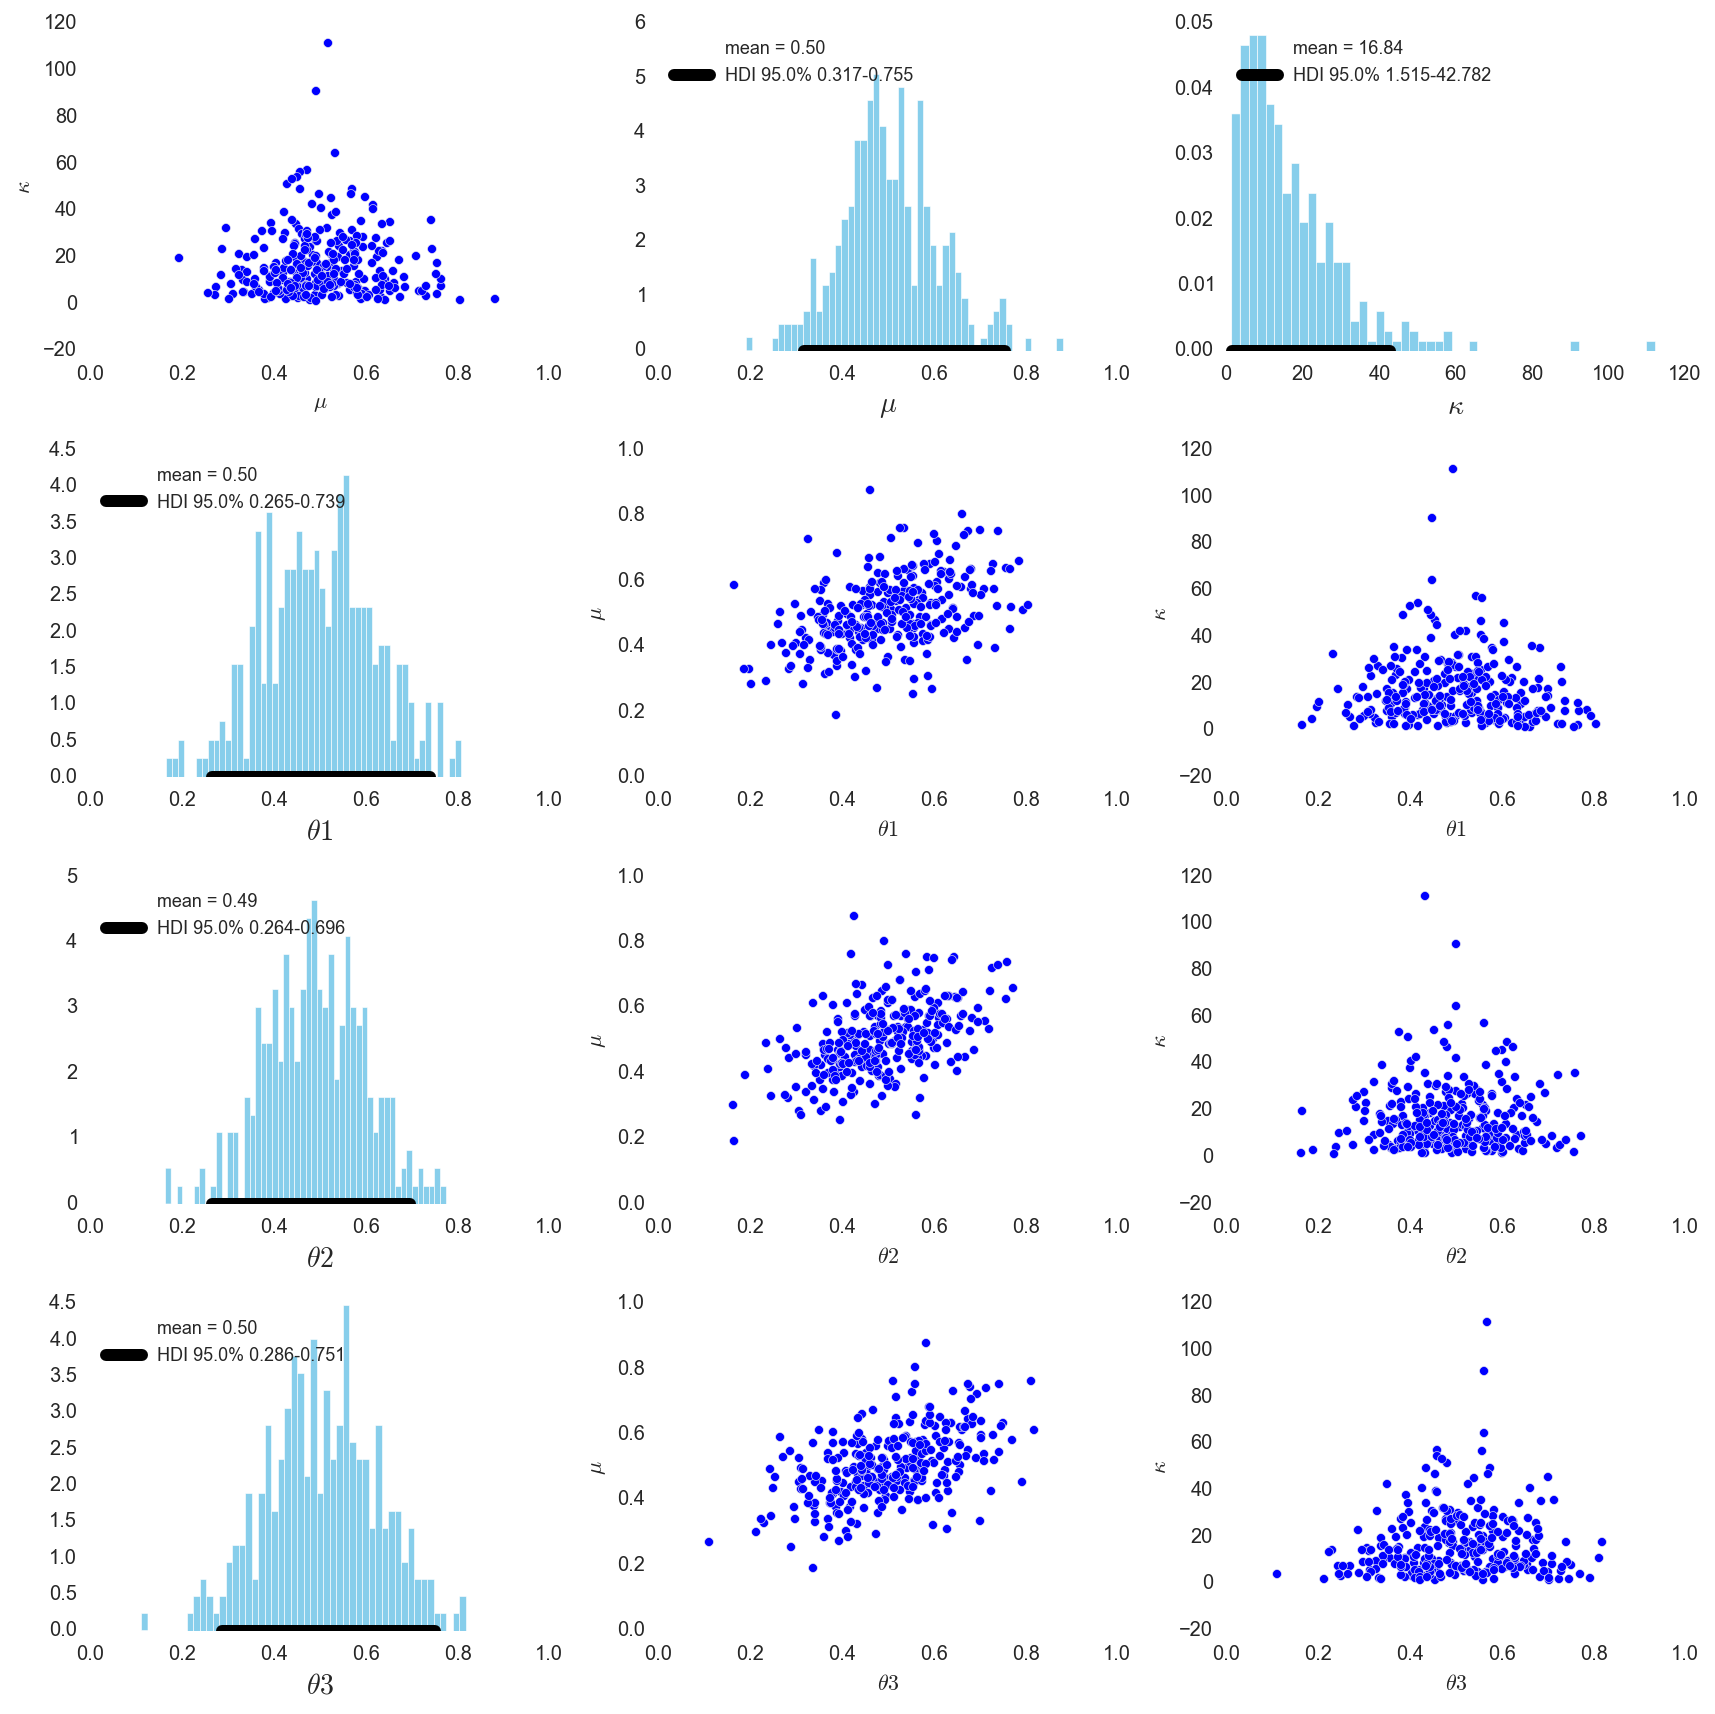

In [37]:
"""
09_BernBetaMuKappaPyMC.py
Bernoulli Likelihood with Hierarchical Prior!
"""

# Data for figure 9.11
N =  [10, 10, 10]  # Number of flips per coin
z =  [5, 5, 5]  # Number of heads per coin
## Data for figure 9.12
#N =  [10, 10, 10]  # Number of flips per coin
#z =  [1, 5, 9]  # Number of heads per coin

## Data for exercise 9.1
#ncoins = 50
#nflipspercoin = 5
#mu_act = .7
#kappa_act = 20
#theta_act = beta.rvs(mu_act*kappa_act+1, (1-mu_act)*kappa_act+1, size=ncoins)
#z = binom.rvs(n=nflipspercoin, p=theta_act, size=ncoins)
#N = [nflipspercoin] * ncoins


# Arrange the data into a more convenient way to feed the PyMC model.
coin = []  # list/vector index for each coins (from 0 to number of coins)
y = []  # list/vector with head (1) or tails (0) for each flip.
for i, flips in enumerate(N):
    heads = z[i]
    if  heads > flips:
        sys.exit("The number of heads can't be greater than the number of flips")
    else:
        y = y + [1] * heads + [0] * (flips-heads)
        coin = coin + [i] * flips


# Specify the model in PyMC
with pm.Model() as model:
# define the hyperparameters
    mu = pm.Beta('mu', 2, 2)
    kappa = pm.Gamma('kappa', 1, 0.1)
    # define the prior
    theta = pm.Beta('theta', mu * kappa, (1 - mu) * kappa, shape=len(N))
    # define the likelihood
    y = pm.Bernoulli('y', p=theta[coin], observed=y)

#   Generate a MCMC chain
    step = pm.Metropolis()
    trace = pm.sample(5000, step, progressbar=False)
#   Restricted models like this could be difficult to sample. This is related 
#   to the censoring comment in the book. One way to detect that something is 
#   wrong with the sampling is to compare the autocorrelation plot and the 
#   sampled values under different sampler, or you can try combinations of 
#   sampler like this

#    step1 = pm.Metropolis([theta, mu])
#    step2 = pm.Slice([kappa])
#    trace = pm.sample(5000, [step1, step2], progressbar=False)

#    or this (this combination was used to generate the figures)

#    start = pm.find_MAP()
#    step1 = pm.Metropolis([theta, mu])
#    step2 = pm.NUTS([kappa])
#    trace = pm.sample(5000, [step1, step2], start=start, progressbar=False)

## Check the results.
burnin = 2000  # posterior samples to discard
thin = 10  # posterior samples to discard

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
pm.autocorrplot(trace[burnin::thin], vars =[mu, kappa])
#pm.autocorrplot(trace, vars =[mu, kappa])

## Plot KDE and sampled values for each parameter.
pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)

# Create arrays with the posterior sample
theta1_sample = trace['theta'][:,0][burnin::thin]
theta2_sample = trace['theta'][:,1][burnin::thin]
theta3_sample = trace['theta'][:,2][burnin::thin]
mu_sample = trace['mu'][burnin::thin]
kappa_sample = trace['kappa'][burnin::thin]

fig = plt.figure(figsize=(12,12))

# Scatter plot hyper-parameters
plt.subplot(4, 3, 1)
plt.scatter(mu_sample, kappa_sample, marker='o')
plt.xlim(0,1)
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\kappa$')

# Plot mu histogram
plt.subplot(4, 3, 2)
plot_post(mu_sample, xlab=r'$\mu$', show_mode=False, labelsize=9, framealpha=0.5)
plt.xlim(0,1)

# Plot kappa histogram
plt.subplot(4, 3, 3)
plot_post(kappa_sample, xlab=r'$\kappa$', show_mode=False, labelsize=9, framealpha=0.5)

# Plot theta 1
plt.subplot(4, 3, 4)
plot_post(theta1_sample, xlab=r'$\theta1$', show_mode=False, labelsize=9, framealpha=0.5)
plt.xlim(0,1)

# Scatter theta 1 vs mu
plt.subplot(4, 3, 5)
plt.scatter(theta1_sample, mu_sample, marker='o')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\mu$')

# Scatter theta 1 vs kappa
plt.subplot(4, 3, 6)
plt.scatter(theta1_sample, kappa_sample, marker='o')
plt.xlim(0,1)
plt.xlabel(r'$\theta1$')
plt.ylabel(r'$\kappa$')

# Plot theta 2
plt.subplot(4, 3, 7)
plot_post(theta2_sample, xlab=r'$\theta2$', show_mode=False, labelsize=9, framealpha=0.5)
plt.xlim(0,1)

# Scatter theta 2 vs mu
plt.subplot(4, 3, 8)
plt.scatter(theta2_sample, mu_sample, marker='o')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r'$\theta2$')
plt.ylabel(r'$\mu$')

# Scatter theta 2 vs kappa
plt.subplot(4, 3, 9)
plt.scatter(theta2_sample, kappa_sample, marker='o')
plt.xlim(0,1)
plt.xlabel(r'$\theta2$')
plt.ylabel(r'$\kappa$')

# Plot theta 3
plt.subplot(4, 3, 10)
plot_post(theta3_sample, xlab=r'$\theta3$', show_mode=False, labelsize=9, framealpha=0.5)
plt.xlim(0,1)

# Scatter theta 3 vs mu
plt.subplot(4, 3, 11)
plt.scatter(theta3_sample, mu_sample, marker='o')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel(r'$\theta3$')
plt.ylabel(r'$\mu$')

# Scatter theta 3 vs kappa
plt.subplot(4, 3, 12)
plt.scatter(theta3_sample, kappa_sample, marker='o')
plt.xlim(0,1)
plt.xlabel(r'$\theta3$')
plt.ylabel(r'$\kappa$')

plt.tight_layout()

/Users/briann/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


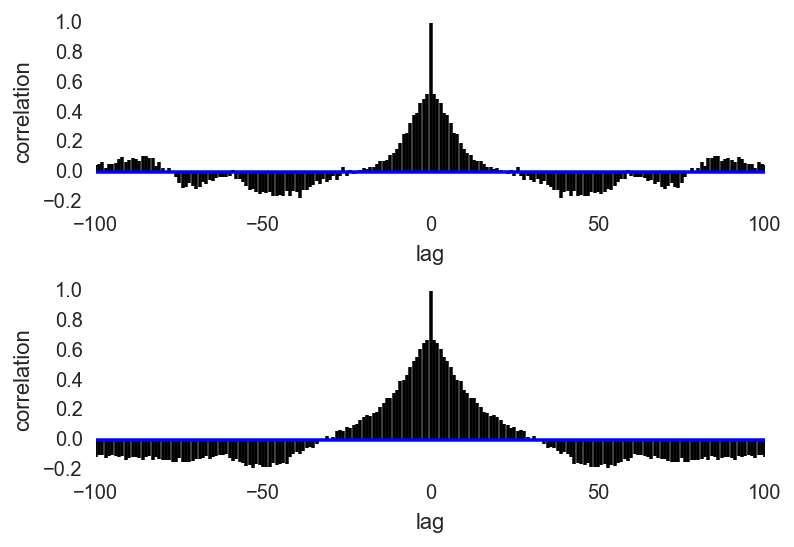

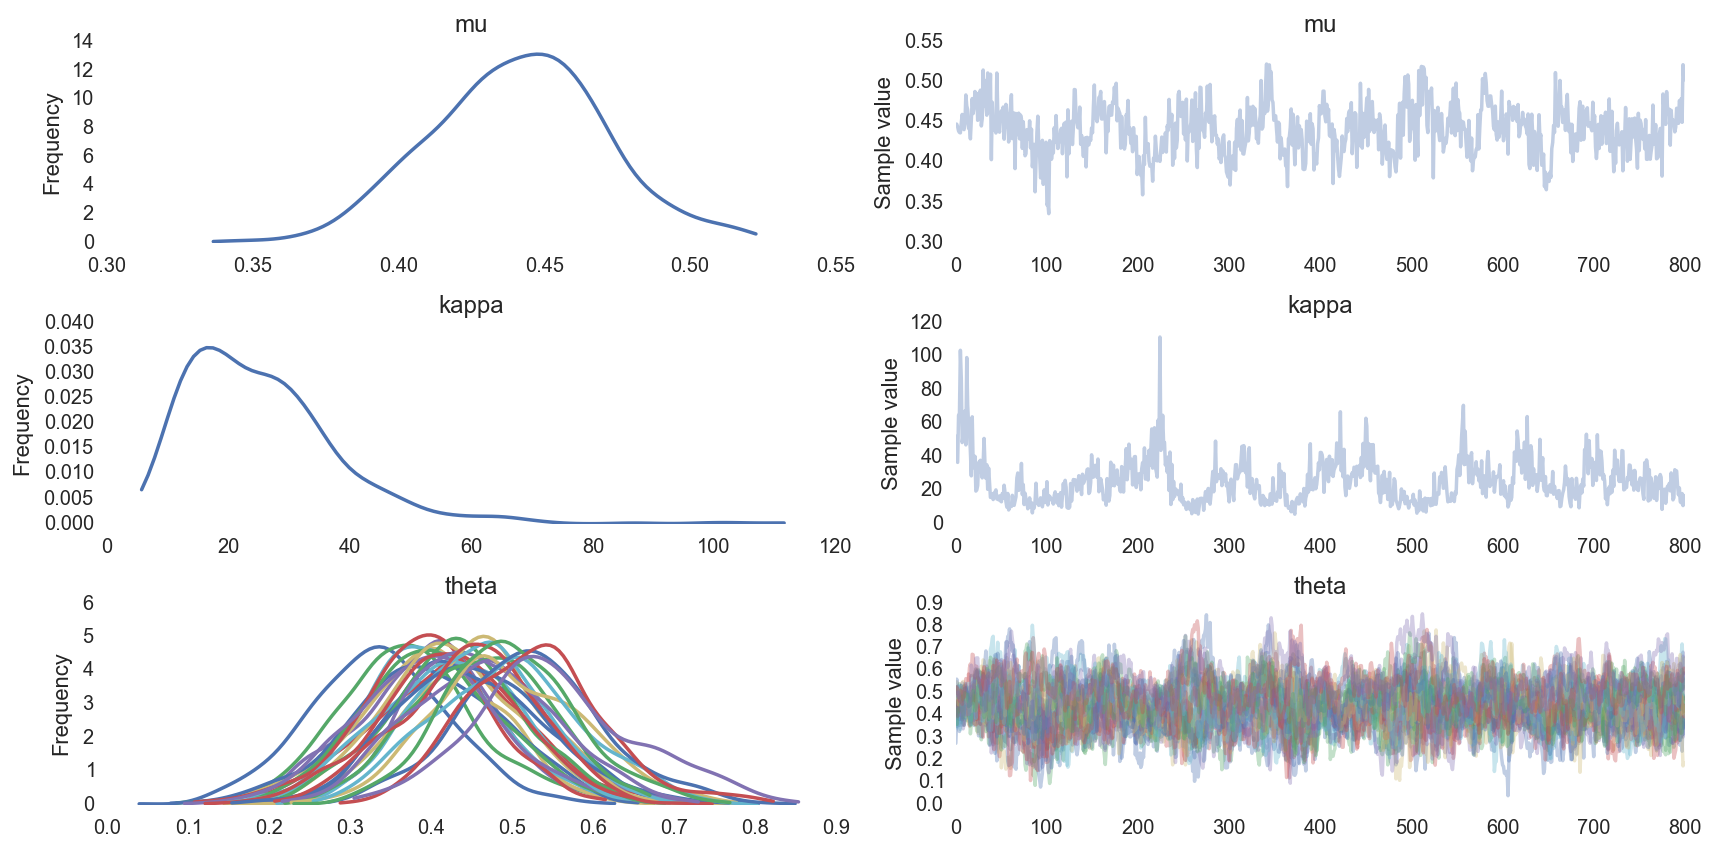

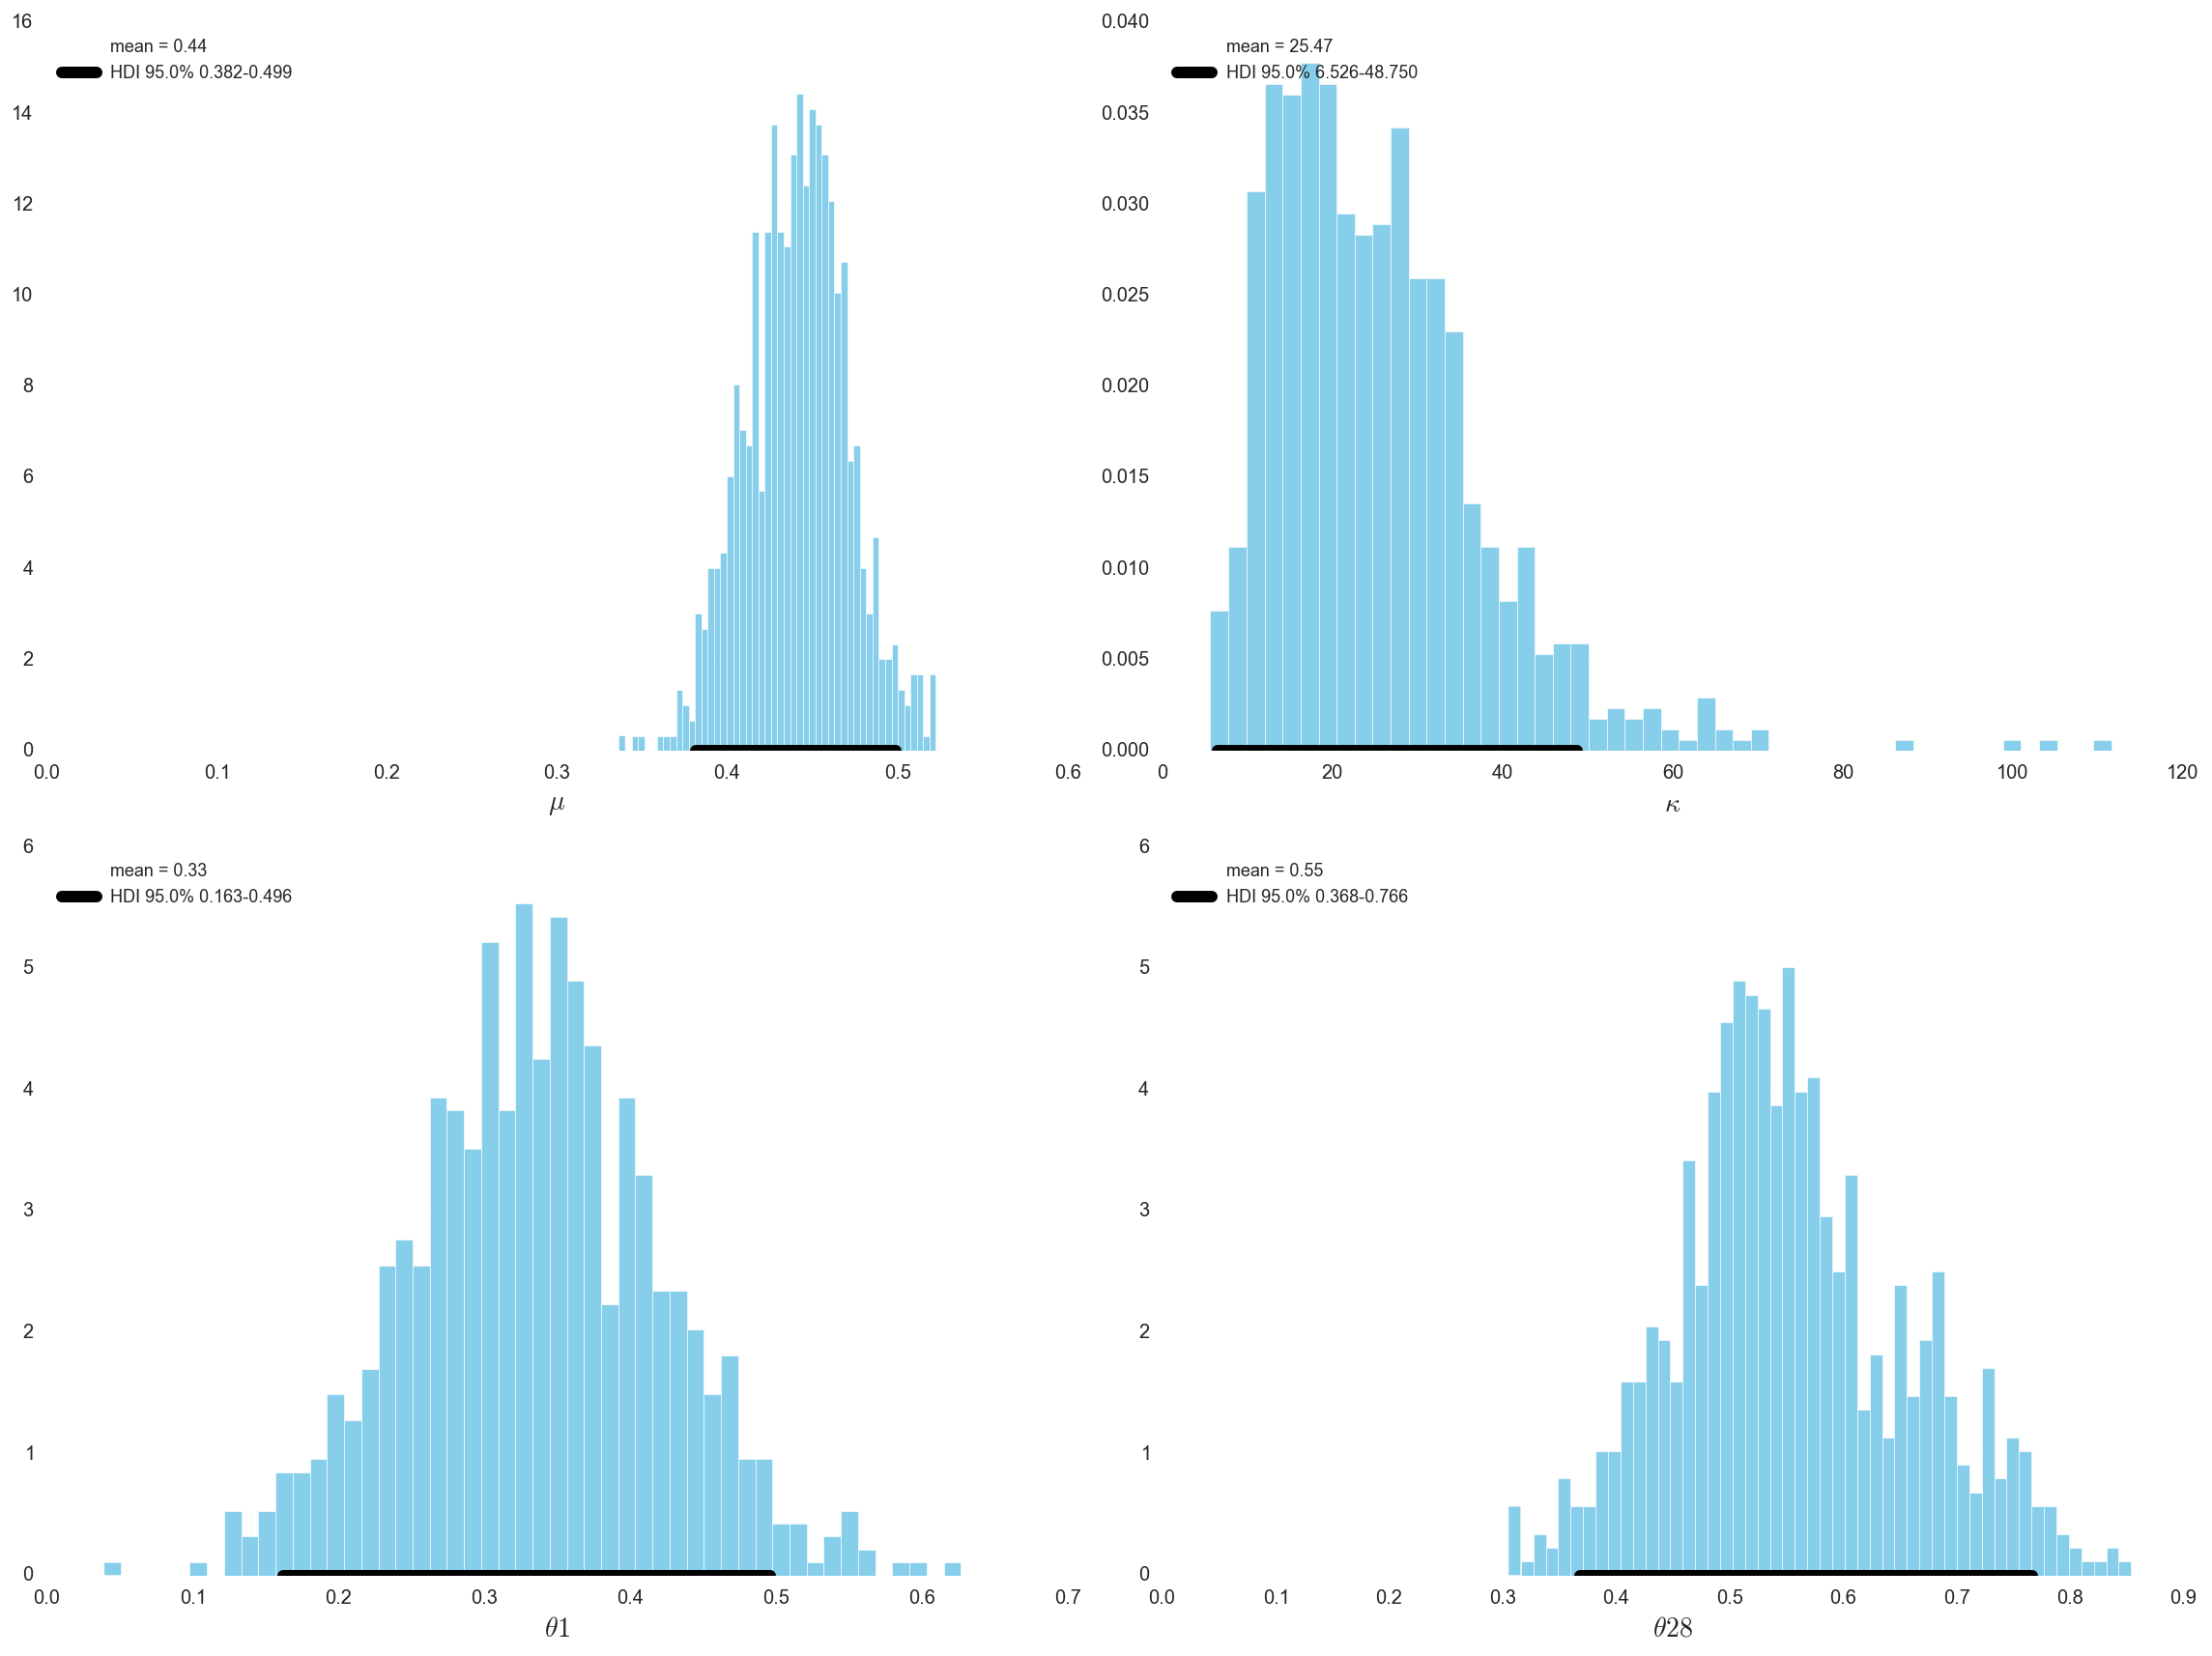

In [38]:
"""
09_BernBetaMuKappaPyMC_TT.py
Bernoulli Likelihood with Hierarchical Prior. The Therapeutic Touch example.
"""

## Therapeutic touch data:
z =  [1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
      5, 5, 5, 5, 5, 5, 5, 6, 6, 7, 7, 7, 8]  # Number of heads per coin
N =  [10] * len(z)  # Number of flips per coin

# rearrange the data to load it PyMC model.
coin = []  # list/vector index for each coins (from 0 to number of coins)
y = []  # list/vector with head (1) or tails (0) for each flip.
for i, flips in enumerate(N):
    heads = z[i]
    if  heads > flips:
        sys.exit("The number of heads can't be greater than the number of flips")
    else:
        y = y + [1] * heads + [0] * (flips-heads)
        coin = coin + [i] * flips


# Specify the model in PyMC
with pm.Model() as model:
# define the hyperparameters
    mu = pm.Beta('mu', 2, 2)
    kappa = pm.Gamma('kappa', 1, 0.1)
    # define the prior
    theta = pm.Beta('theta', mu * kappa, (1 - mu) * kappa, shape=len(N))
    # define the likelihood
    y = pm.Bernoulli('y', p=theta[coin], observed=y)
#   Generate a MCMC chain
    start = pm.find_MAP()  # find a reasonable starting point.
    step1 = pm.Metropolis([theta, mu])
    step2 = pm.NUTS([kappa])
    trace = pm.sample(10000, [step1, step2], start=start, random_seed=(123), progressbar=False)

## Check the results.
burnin = 2000  # posterior samples to discard
thin = 10  # posterior samples to discard

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
pm.autocorrplot(trace[burnin::thin], vars =[mu, kappa])
#pm.autocorrplot(trace, vars =[mu, kappa])

## Plot KDE and sampled values for each parameter.
pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)

# Create arrays with the posterior sample
theta1_sample = trace['theta'][:,0][burnin::thin]
theta28_sample = trace['theta'][:,27][burnin::thin]
mu_sample = trace['mu'][burnin::thin]
kappa_sample = trace['kappa'][burnin::thin]

fig = plt.figure(figsize=(16,12))

# Plot mu histogram
plt.subplot(2, 2, 1)
plot_post(mu_sample, xlab=r'$\mu$', show_mode=False, labelsize=9, framealpha=0.5)

# Plot kappa histogram
plt.subplot(2, 2, 2)
plot_post(kappa_sample, xlab=r'$\kappa$', show_mode=False, labelsize=9, framealpha=0.5)

# Plot theta 1
plt.subplot(2, 2, 3)
plot_post(theta1_sample, xlab=r'$\theta1$', show_mode=False, labelsize=9, framealpha=0.5)

# Plot theta 28
plt.subplot(2, 2, 4)
plot_post(theta28_sample, xlab=r'$\theta28$', show_mode=False, labelsize=9, framealpha=0.5)

plt.tight_layout()

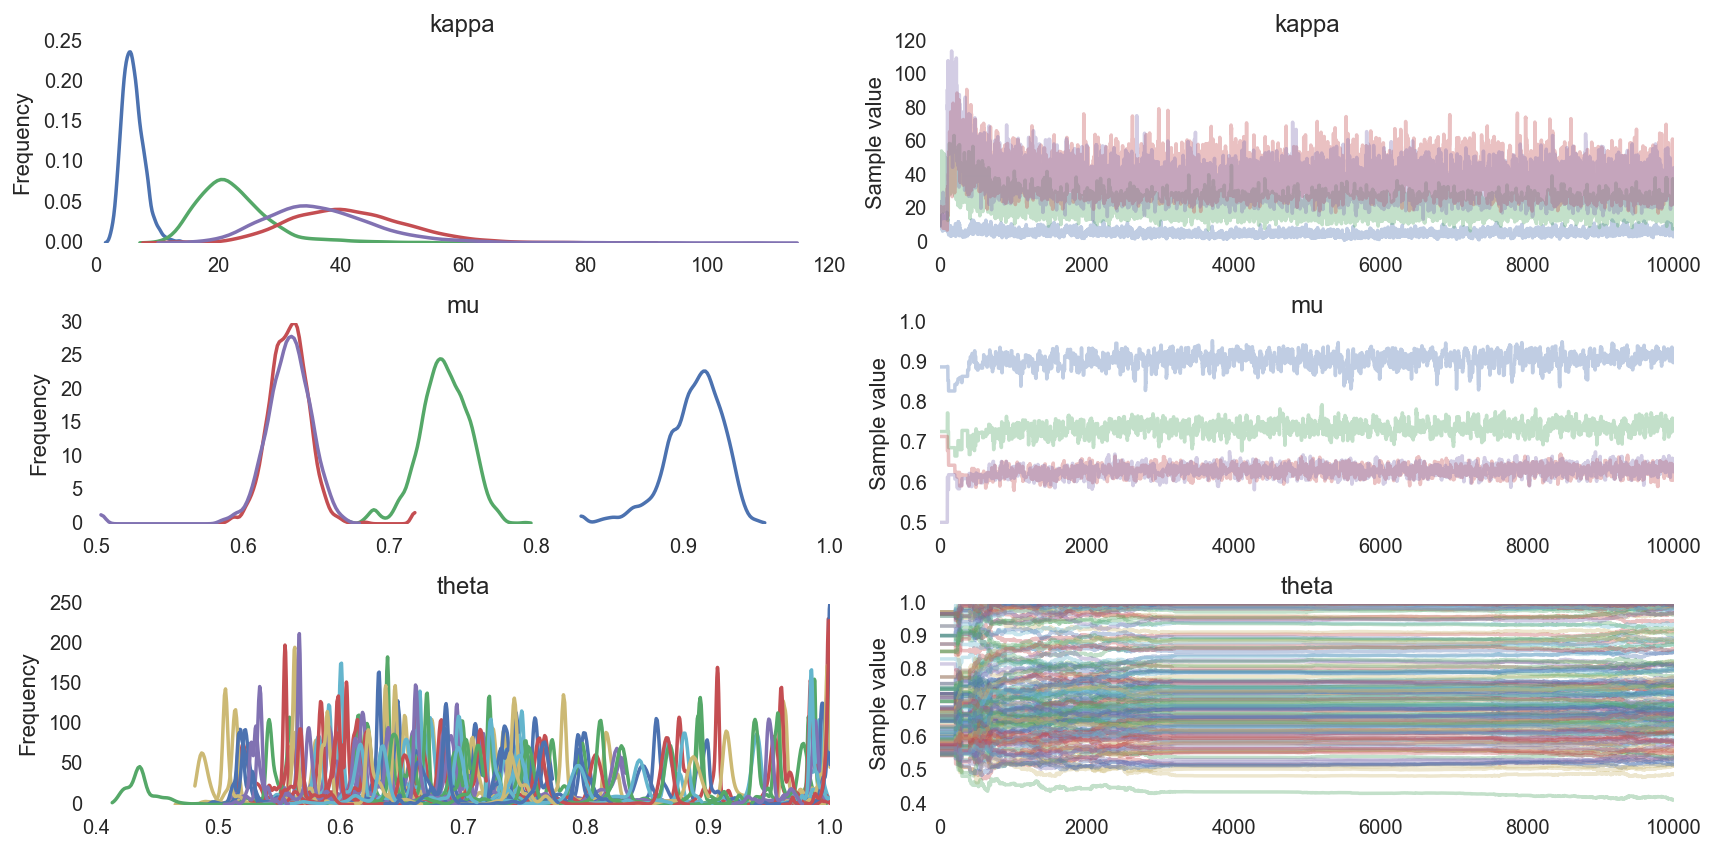

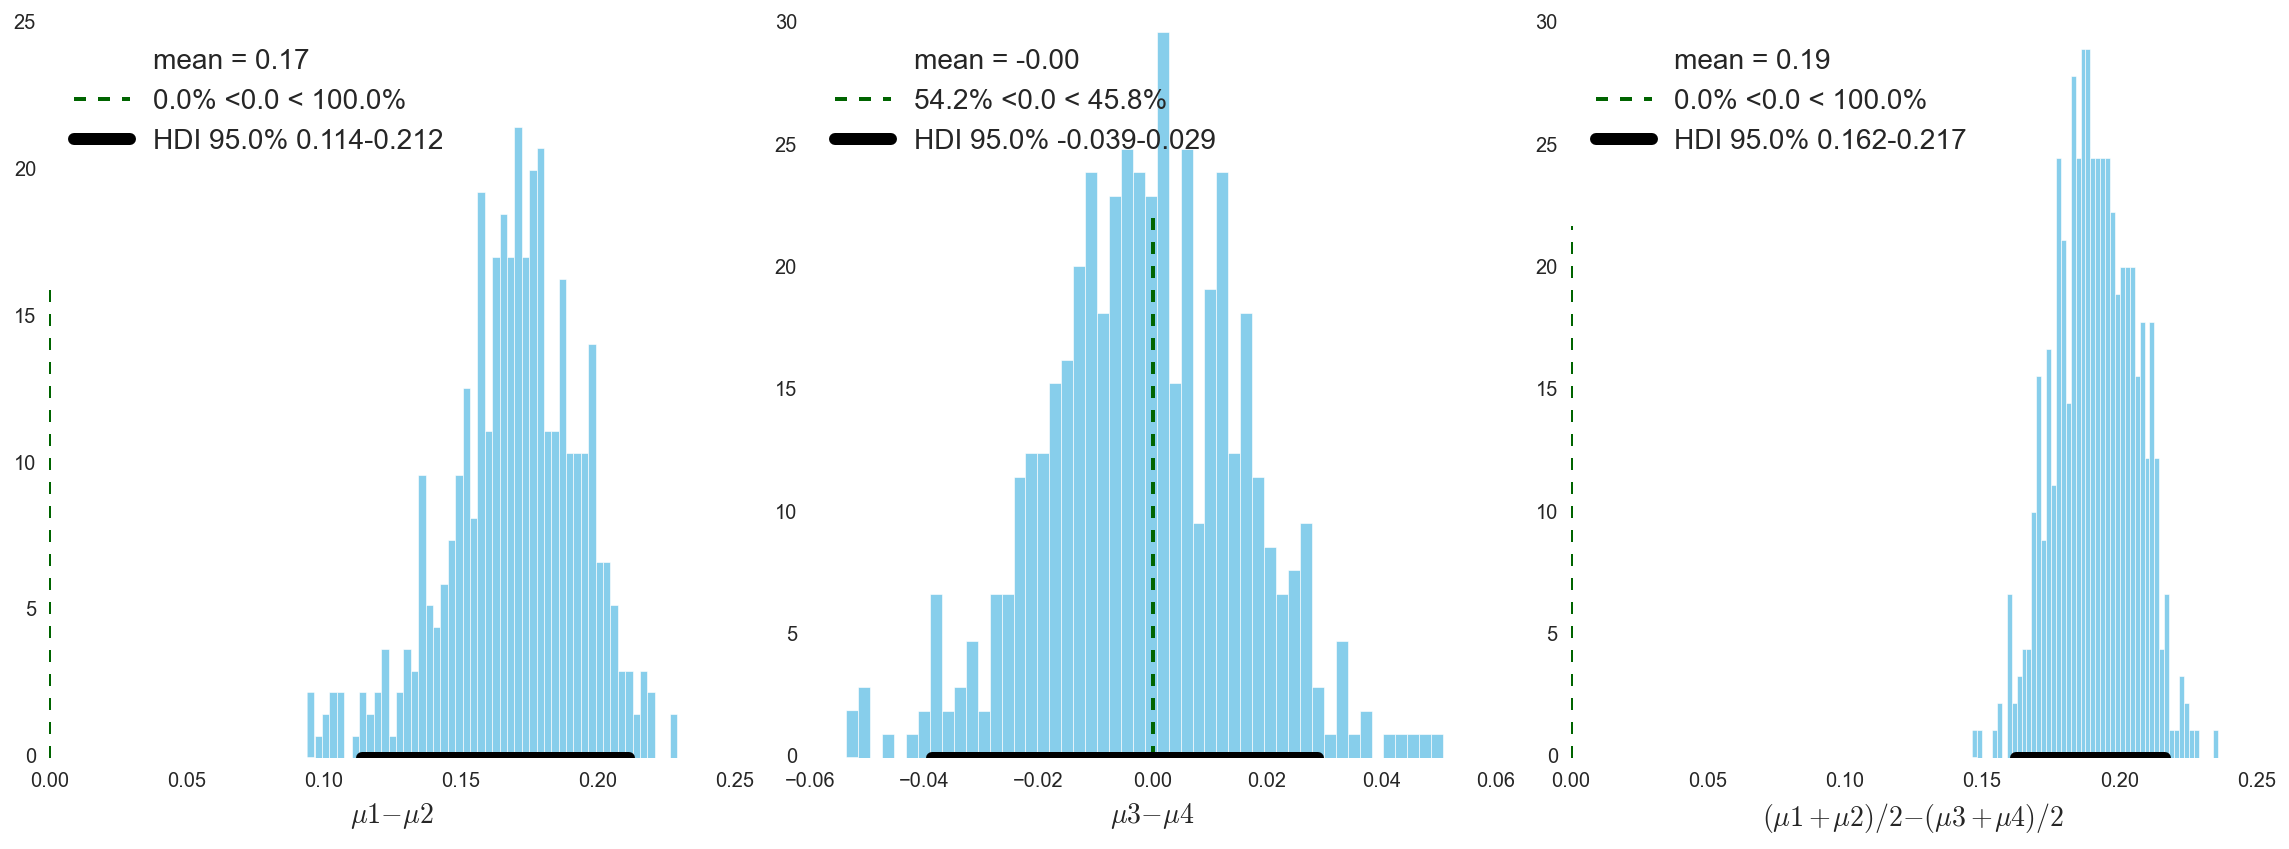

In [39]:
"""
09_FilconPyMC.py
More Hierarchical models. The filtration-condensation experiment.
"""
# Data
# For each subject, specify the condition s/he was in,
# the number of trials s/he experienced, and the number correct.
ncond = 4
nSubj = 40
trials = 64

N = np.repeat([trials], (ncond * nSubj))
z = np.array([45, 63, 58, 64, 58, 63, 51, 60, 59, 47, 63, 61, 60, 51, 59, 45,
61, 59, 60, 58, 63, 56, 63, 64, 64, 60, 64, 62, 49, 64, 64, 58, 64, 52, 64, 64,
64, 62, 64, 61, 59, 59, 55, 62, 51, 58, 55, 54, 59, 57, 58, 60, 54, 42, 59, 57,
59, 53, 53, 42, 59, 57, 29, 36, 51, 64, 60, 54, 54, 38, 61, 60, 61, 60, 62, 55,
38, 43, 58, 60, 44, 44, 32, 56, 43, 36, 38, 48, 32, 40, 40, 34, 45, 42, 41, 32,
48, 36, 29, 37, 53, 55, 50, 47, 46, 44, 50, 56, 58, 42, 58, 54, 57, 54, 51, 49,
52, 51, 49, 51, 46, 46, 42, 49, 46, 56, 42, 53, 55, 51, 55, 49, 53, 55, 40, 46,
56, 47, 54, 54, 42, 34, 35, 41, 48, 46, 39, 55, 30, 49, 27, 51, 41, 36, 45, 41,
53, 32, 43, 33])
condition = np.repeat([0,1,2,3], nSubj)

# Specify the model in PyMC
with pm.Model() as model:
    kappa = pm.Gamma('kappa', 1, 0.1, shape=ncond)
    mu = pm.Beta('mu', 1, 1, shape=ncond)
    theta = pm.Beta('theta', mu[condition] * kappa[condition], (1 - mu[condition]) * kappa[condition], shape=len(z))
    y = pm.Binomial('y', p=theta, n=N, observed=z)
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu])
    step2 = pm.Metropolis([theta])
    step3 = pm.NUTS([kappa])
#    samplers = [pm.Metropolis([rv]) for rv in model.unobserved_RVs]
    trace = pm.sample(10000, [step1, step2, step3], start=start, progressbar=False)

## Check the results.
burnin = 5000  # posterior samples to discard
thin = 10  # posterior samples to discard

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace, vars =[mu, kappa])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
pm.traceplot(trace)


# Create arrays with the posterior sample
mu1_sample = trace['mu'][:,0][burnin::thin]
mu2_sample = trace['mu'][:,1][burnin::thin]
mu3_sample = trace['mu'][:,2][burnin::thin]
mu4_sample = trace['mu'][:,3][burnin::thin]


fig = plt.figure(figsize=(16, 6))

# Plot differences among filtrations experiments
plt.subplot(1, 3, 1)
plot_post((mu1_sample-mu2_sample), xlab=r'$\mu1-\mu2$', show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences among condensation experiments
plt.subplot(1, 3, 2)
plot_post((mu3_sample-mu4_sample), xlab=r'$\mu3-\mu4$', show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences between filtration and condensation experiments
plt.subplot(1, 3, 3)
a = (mu1_sample+mu2_sample)/2 - (mu3_sample+mu4_sample)/2
plot_post(a, xlab=r'$(\mu1+\mu2)/2 - (\mu3+\mu4)/2$', show_mode=False, comp_val=0, framealpha=0.5)

plt.tight_layout()

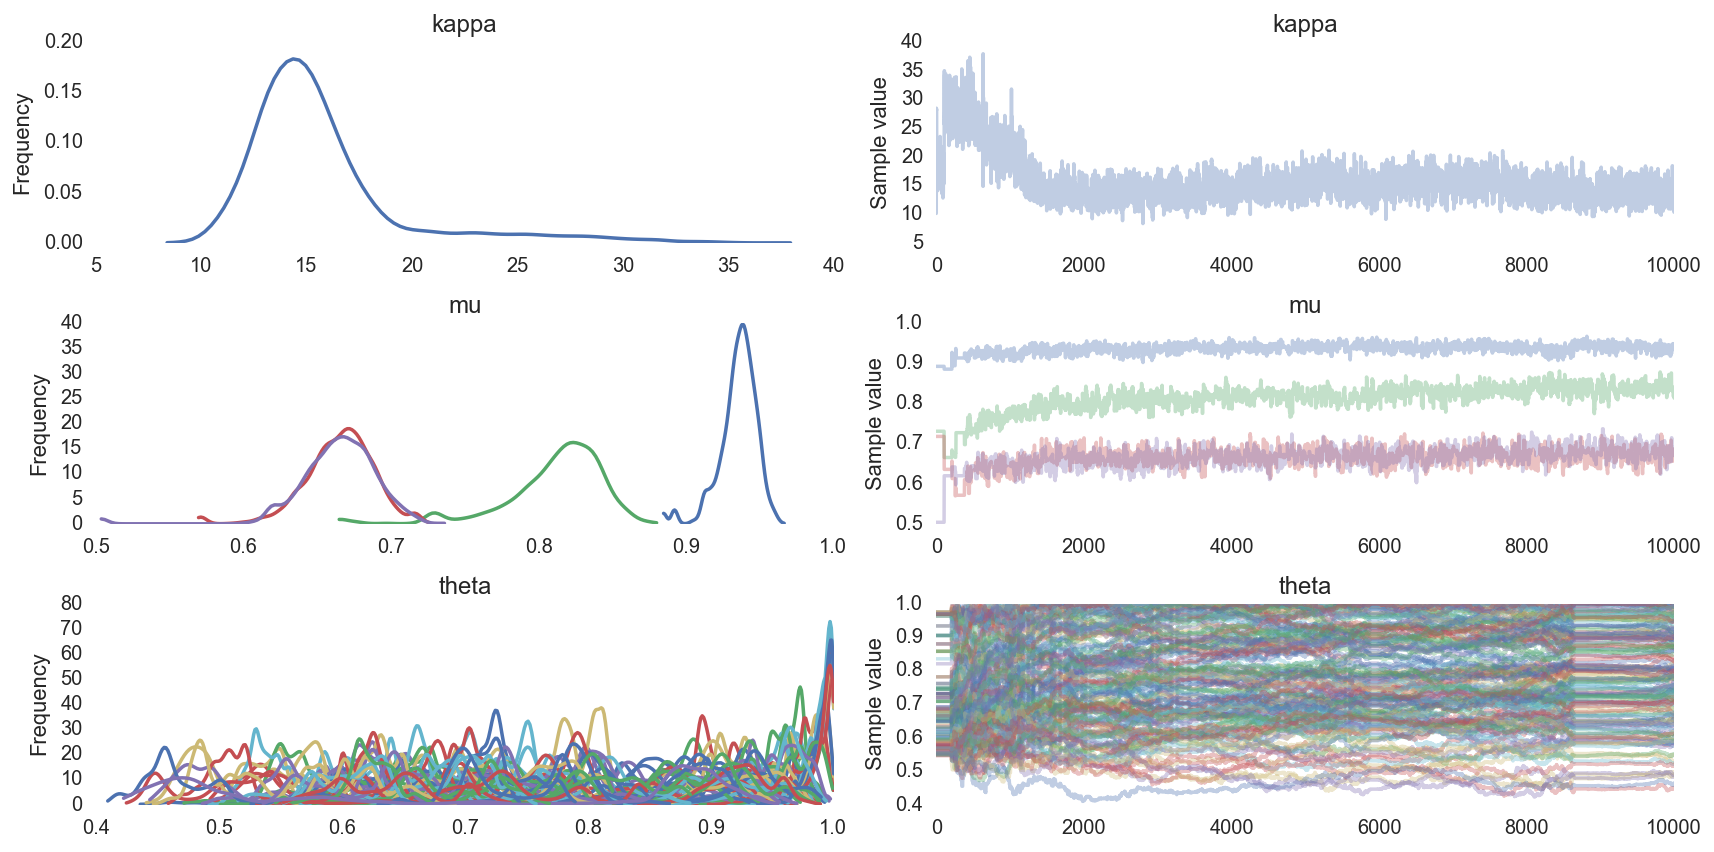

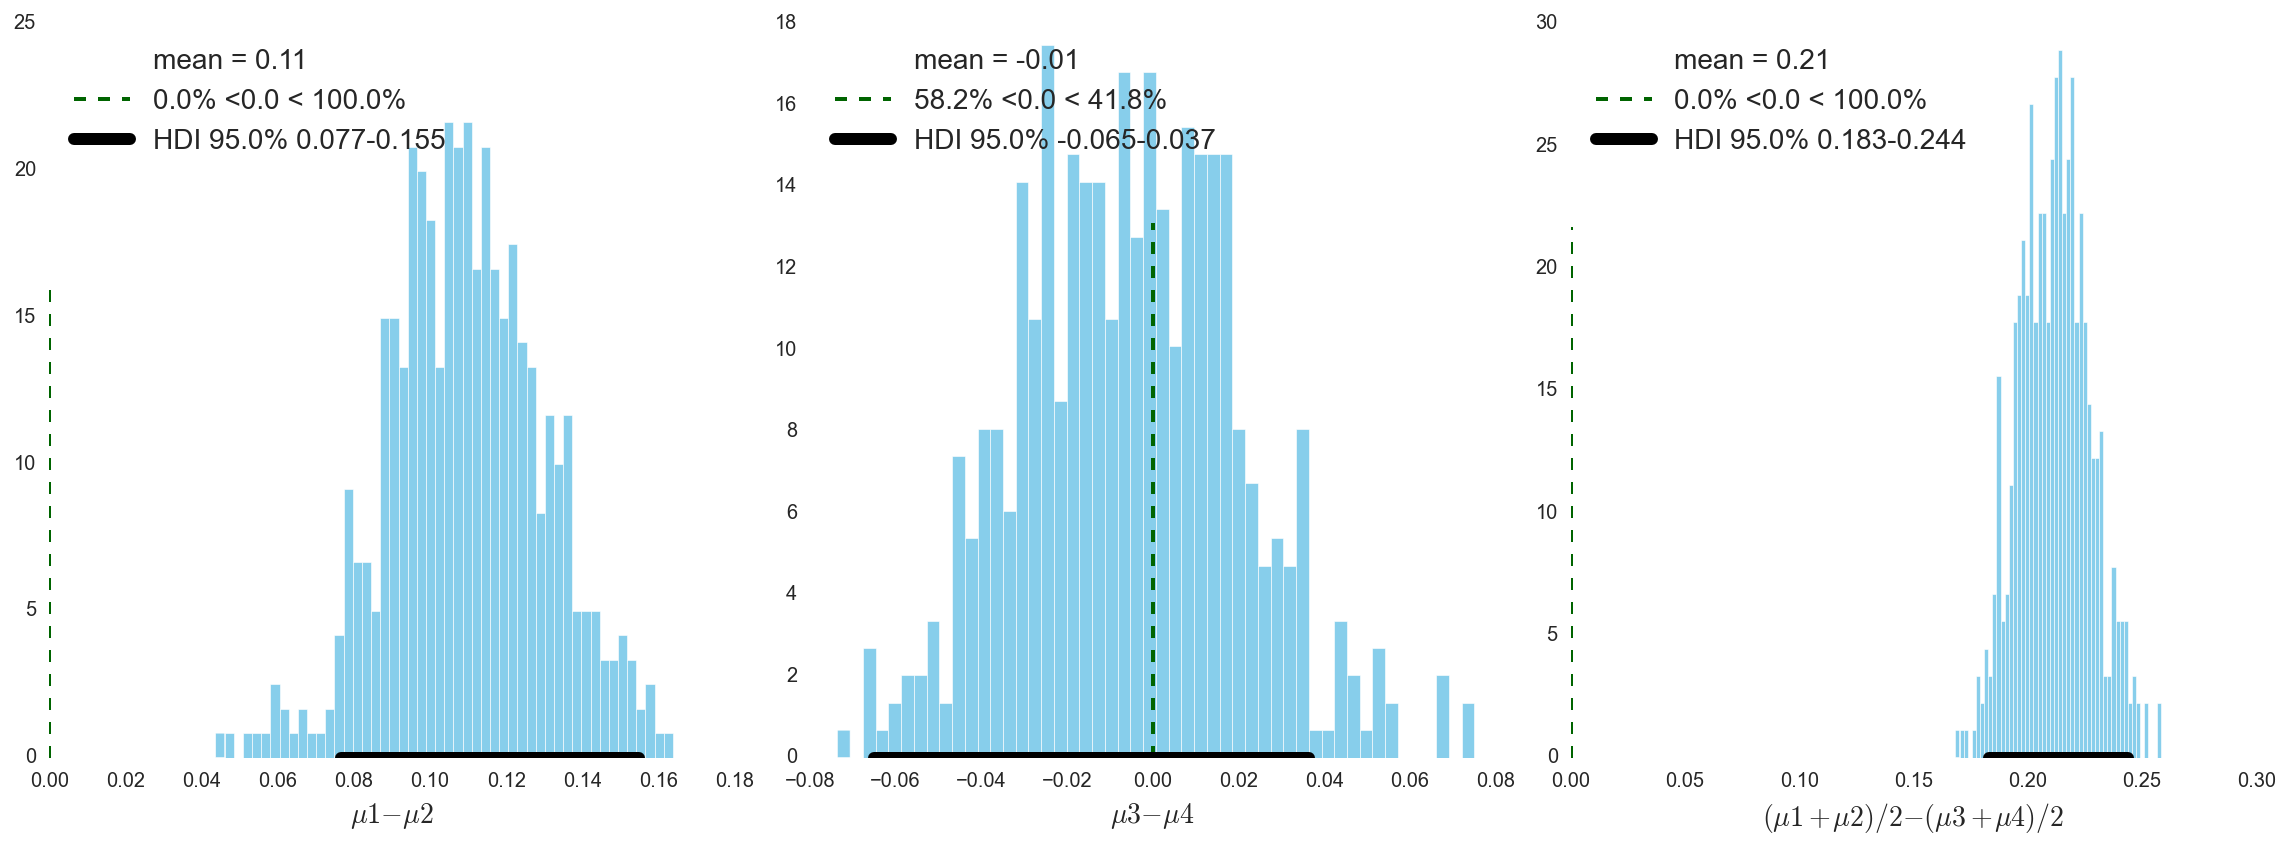

In [40]:
"""
09_FilconPyMC_ex9.2.A.py
More Hierarchical models. The filtration-condensation experiment. A single kappa
for all conditions.
"""

# Data
# For each subject, specify the condition s/he was in,
# the number of trials s/he experienced, and the number correct.
ncond = 4
nSubj = 40
trials = 64

N = np.repeat([trials], (ncond * nSubj))
z = np.array([45, 63, 58, 64, 58, 63, 51, 60, 59, 47, 63, 61, 60, 51, 59, 45,
61, 59, 60, 58, 63, 56, 63, 64, 64, 60, 64, 62, 49, 64, 64, 58, 64, 52, 64, 64,
64, 62, 64, 61, 59, 59, 55, 62, 51, 58, 55, 54, 59, 57, 58, 60, 54, 42, 59, 57,
59, 53, 53, 42, 59, 57, 29, 36, 51, 64, 60, 54, 54, 38, 61, 60, 61, 60, 62, 55,
38, 43, 58, 60, 44, 44, 32, 56, 43, 36, 38, 48, 32, 40, 40, 34, 45, 42, 41, 32,
48, 36, 29, 37, 53, 55, 50, 47, 46, 44, 50, 56, 58, 42, 58, 54, 57, 54, 51, 49,
52, 51, 49, 51, 46, 46, 42, 49, 46, 56, 42, 53, 55, 51, 55, 49, 53, 55, 40, 46,
56, 47, 54, 54, 42, 34, 35, 41, 48, 46, 39, 55, 30, 49, 27, 51, 41, 36, 45, 41,
53, 32, 43, 33])
condition = np.repeat([0,1,2,3], nSubj)

# Specify the model in PyMC
with pm.Model() as model:
    # define the hyperparameters
    kappa = pm.Gamma('kappa', 1, 0.1)
    mu = pm.Beta('mu', 1, 1, shape=ncond)
    # define the prior
    theta = pm.Beta('theta', mu[condition] * kappa, (1 - mu[condition]) * kappa, shape=len(z))
    # define the likelihood
    y = pm.Binomial('y', p=theta, n=N, observed=z)
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu])
    step2 = pm.Metropolis([theta])
    step3 = pm.NUTS([kappa])
#    samplers = [pm.Metropolis([rv]) for rv in model.unobserved_RVs]
    trace = pm.sample(10000, [step1, step2, step3], start=start, progressbar=False)

## Check the results.
burnin = 5000  # posterior samples to discard
thin = 10  # posterior samples to discard

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace, vars =[mu, kappa])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
pm.traceplot(trace)


# Create arrays with the posterior sample
mu1_sample = trace['mu'][:,0][burnin::thin]
mu2_sample = trace['mu'][:,1][burnin::thin]
mu3_sample = trace['mu'][:,2][burnin::thin]
mu4_sample = trace['mu'][:,3][burnin::thin]


fig = plt.figure(figsize=(16, 6))

# Plot differences among filtrations experiments
plt.subplot(1, 3, 1)
plot_post((mu1_sample-mu2_sample), xlab=r'$\mu1-\mu2$', show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences among condensation experiments
plt.subplot(1, 3, 2)
plot_post((mu3_sample-mu4_sample), xlab=r'$\mu3-\mu4$', show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences between filtration and condensation experiments
plt.subplot(1, 3, 3)
a = (mu1_sample+mu2_sample)/2 - (mu3_sample+mu4_sample)/2
plot_post(a, xlab=r'$(\mu1+\mu2)/2 - (\mu3+\mu4)/2$', show_mode=False, comp_val=0, framealpha=0.5)

plt.tight_layout()

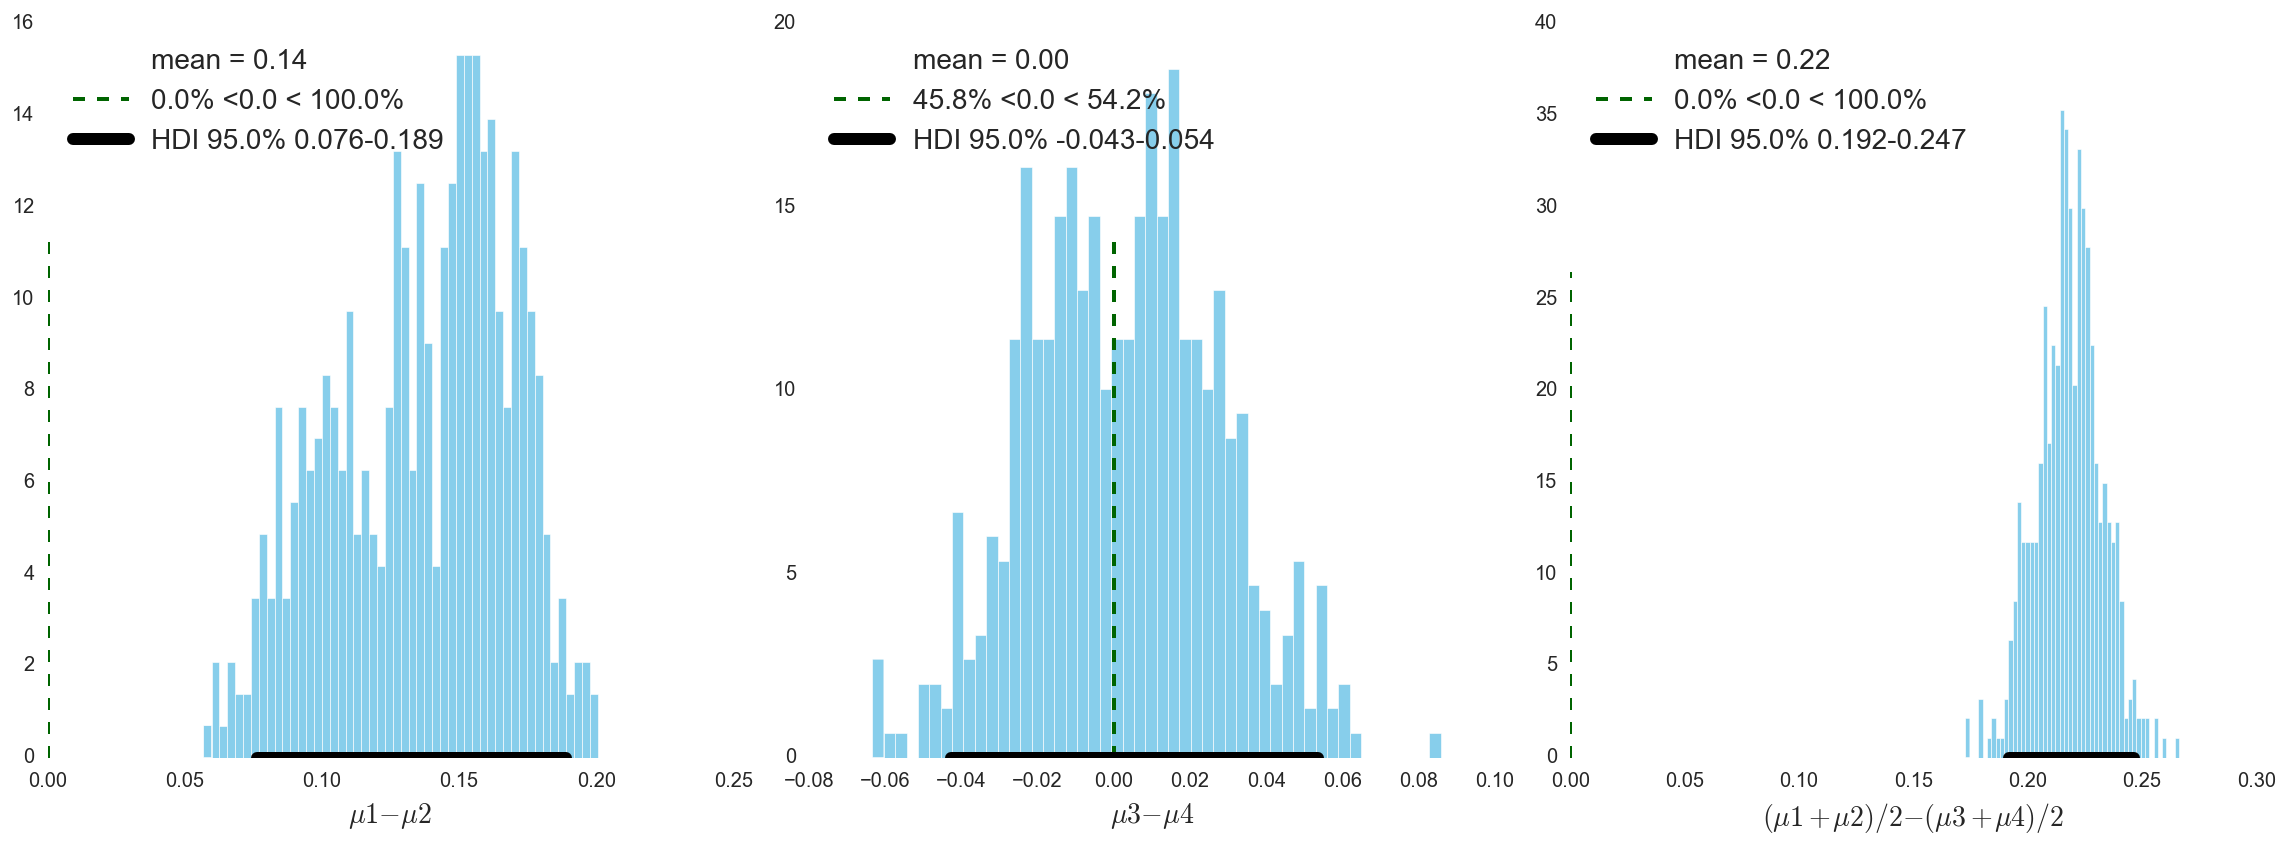

In [41]:
"""
09_FilconPyMC_ex9.2.B.py
More Hierarchical models. The filtration-condensation experiment. 
Hyperparameters for kappafor all conditions.
"""
# Data
# For each subject, specify the condition s/he was in,
# the number of trials s/he experienced, and the number correct.
ncond = 4
nSubj = 40
trials = 64

N = np.repeat([trials], (ncond * nSubj))
z = np.array([45, 63, 58, 64, 58, 63, 51, 60, 59, 47, 63, 61, 60, 51, 59, 45,
61, 59, 60, 58, 63, 56, 63, 64, 64, 60, 64, 62, 49, 64, 64, 58, 64, 52, 64, 64,
64, 62, 64, 61, 59, 59, 55, 62, 51, 58, 55, 54, 59, 57, 58, 60, 54, 42, 59, 57,
59, 53, 53, 42, 59, 57, 29, 36, 51, 64, 60, 54, 54, 38, 61, 60, 61, 60, 62, 55,
38, 43, 58, 60, 44, 44, 32, 56, 43, 36, 38, 48, 32, 40, 40, 34, 45, 42, 41, 32,
48, 36, 29, 37, 53, 55, 50, 47, 46, 44, 50, 56, 58, 42, 58, 54, 57, 54, 51, 49,
52, 51, 49, 51, 46, 46, 42, 49, 46, 56, 42, 53, 55, 51, 55, 49, 53, 55, 40, 46,
56, 47, 54, 54, 42, 34, 35, 41, 48, 46, 39, 55, 30, 49, 27, 51, 41, 36, 45, 41,
53, 32, 43, 33])
condition = np.repeat([0,1,2,3], nSubj)

# Specify the model in PyMC
with pm.Model() as model:
    # define the hyper-hyperparameters for kappa
    mean_gamma = pm.Uniform('mean_gamma', 0, 30)
    sd_gamma = pm.Uniform('sd_gamma', 0, 30)
    s_kappa = mean_gamma**2/sd_gamma**2
    r_kappa = mean_gamma/sd_gamma**2
    # define the hyperparameters
    kappa = pm.Gamma('kappa', s_kappa, r_kappa)
    mu = pm.Beta('mu', 1, 1, shape=ncond)
    # define the prior
    theta = pm.Beta('theta', mu[condition] * kappa, (1 - mu[condition]) * kappa, shape=len(z))
    # define the likelihood
    y = pm.Binomial('y', p=theta, n=N, observed=z)
    start = pm.find_MAP()
    step1 = pm.Metropolis([mu])
    step2 = pm.Metropolis([theta])
    step3 = pm.NUTS([kappa])
#    samplers = [pm.Metropolis([rv]) for rv in model.unobserved_RVs]
    trace = pm.sample(10000, [step1, step2, step3], start=start, progressbar=False)

## Check the results.
burnin = 5000  # posterior samples to discard
thin = 10  # posterior samples to discard

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace, vars =[mu, kappa])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])

#pm.traceplot(trace)


# Create arrays with the posterior sample
mu1_sample = trace['mu'][:,0][burnin::thin]
mu2_sample = trace['mu'][:,1][burnin::thin]
mu3_sample = trace['mu'][:,2][burnin::thin]
mu4_sample = trace['mu'][:,3][burnin::thin]


fig = plt.figure(figsize=(16, 6))

# Plot differences among filtrations experiments
plt.subplot(1, 3, 1)
plot_post((mu1_sample-mu2_sample), xlab=r'$\mu1-\mu2$', show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences among condensation experiments
plt.subplot(1, 3, 2)
plot_post((mu3_sample-mu4_sample), xlab=r'$\mu3-\mu4$', show_mode=False, comp_val=0, framealpha=0.5)

# Plot differences between filtration and condensation experiments
plt.subplot(1, 3, 3)
a = (mu1_sample+mu2_sample)/2 - (mu3_sample+mu4_sample)/2
plot_post(a, xlab=r'$(\mu1+\mu2)/2 - (\mu3+\mu4)/2$', show_mode=False, comp_val=0, framealpha=0.5)

plt.tight_layout()

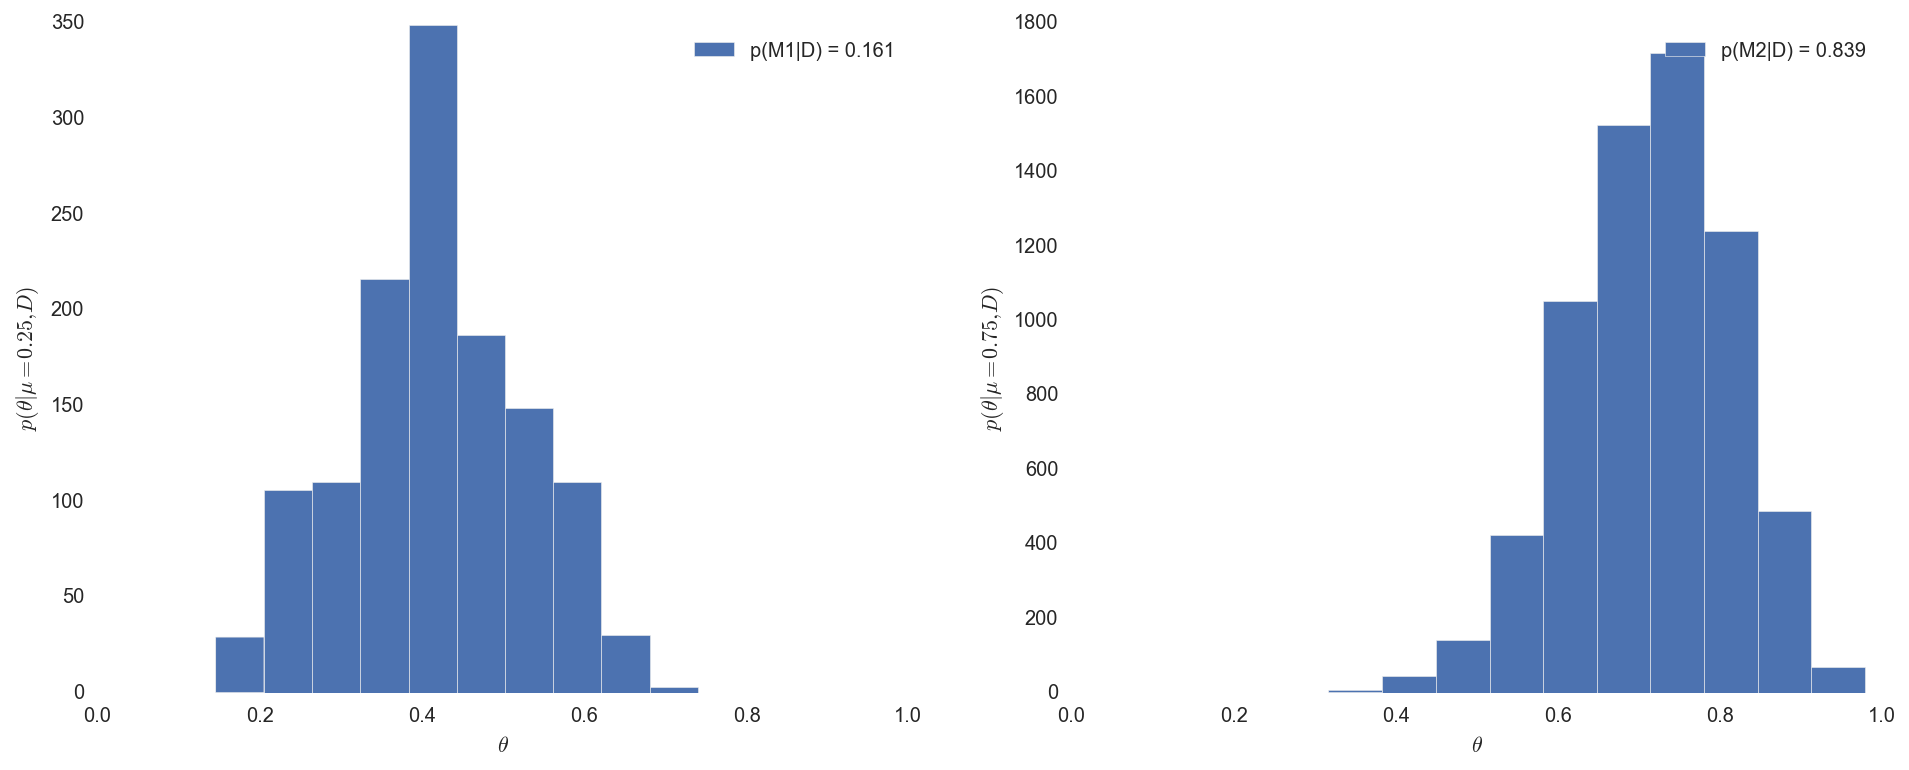

In [42]:
"""
10_BernBetaModelCompPyMC.py
Comparing models using Hierarchical modelling.
"""

## specify the Data
y = np.repeat([0, 1], [3, 6])  # 3 tails 6 heads

with pm.Model() as model:
    # Hyperhyperprior:
    model_index = pm.DiscreteUniform('model_index', lower=0, upper=1)
    # Hyperprior:
    kappa_theta = 12
    mu_theta = pm.switch(pm.eq(model_index, 1), 0.25, 0.75)
    # Prior distribution:
    a_theta = mu_theta * kappa_theta
    b_theta = (1 - mu_theta) * kappa_theta
    theta = pm.Beta('theta', a_theta, b_theta) # theta distributed as beta density
    #likelihood
    y = pm.Bernoulli('y', theta, observed=y)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start=start, progressbar=False)


## Check the results.
burnin = 2000  # posterior samples to discard
thin = 1  # posterior samples to discard

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace)

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)

## Get the posterior sample of model_index:
model_idx_sample = trace['model_index'][burnin::thin]
## Compute the proportion of model_index at each value:
p_M1 = sum(model_idx_sample == 1) / len(model_idx_sample)
p_M2 = 1 - p_M1


## Get the posterior sample of theta:
theta_sample = trace['theta'][burnin::thin]
## Extract theta values when model_index is 1:
theta_sample_M1 = theta_sample[model_idx_sample == 1]
## Extract theta values when model_index is 2:
theta_sample_M2 = theta_sample[model_idx_sample == 0]

## Plot histograms of sampled theta values for each model,
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.hist(theta_sample_M1, label='p(M1|D) = %.3f' % p_M1)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|\mu=0.25,D)$')
plt.xlim(0, 1)
plt.legend(loc='upper right', framealpha=0.5)

plt.subplot(1, 2, 2)
plt.hist(theta_sample_M2, label='p(M2|D) = %.3f' % p_M2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta|\mu=0.75,D)$')
plt.xlim(0, 1)
plt.legend(loc='upper right', framealpha=0.5)

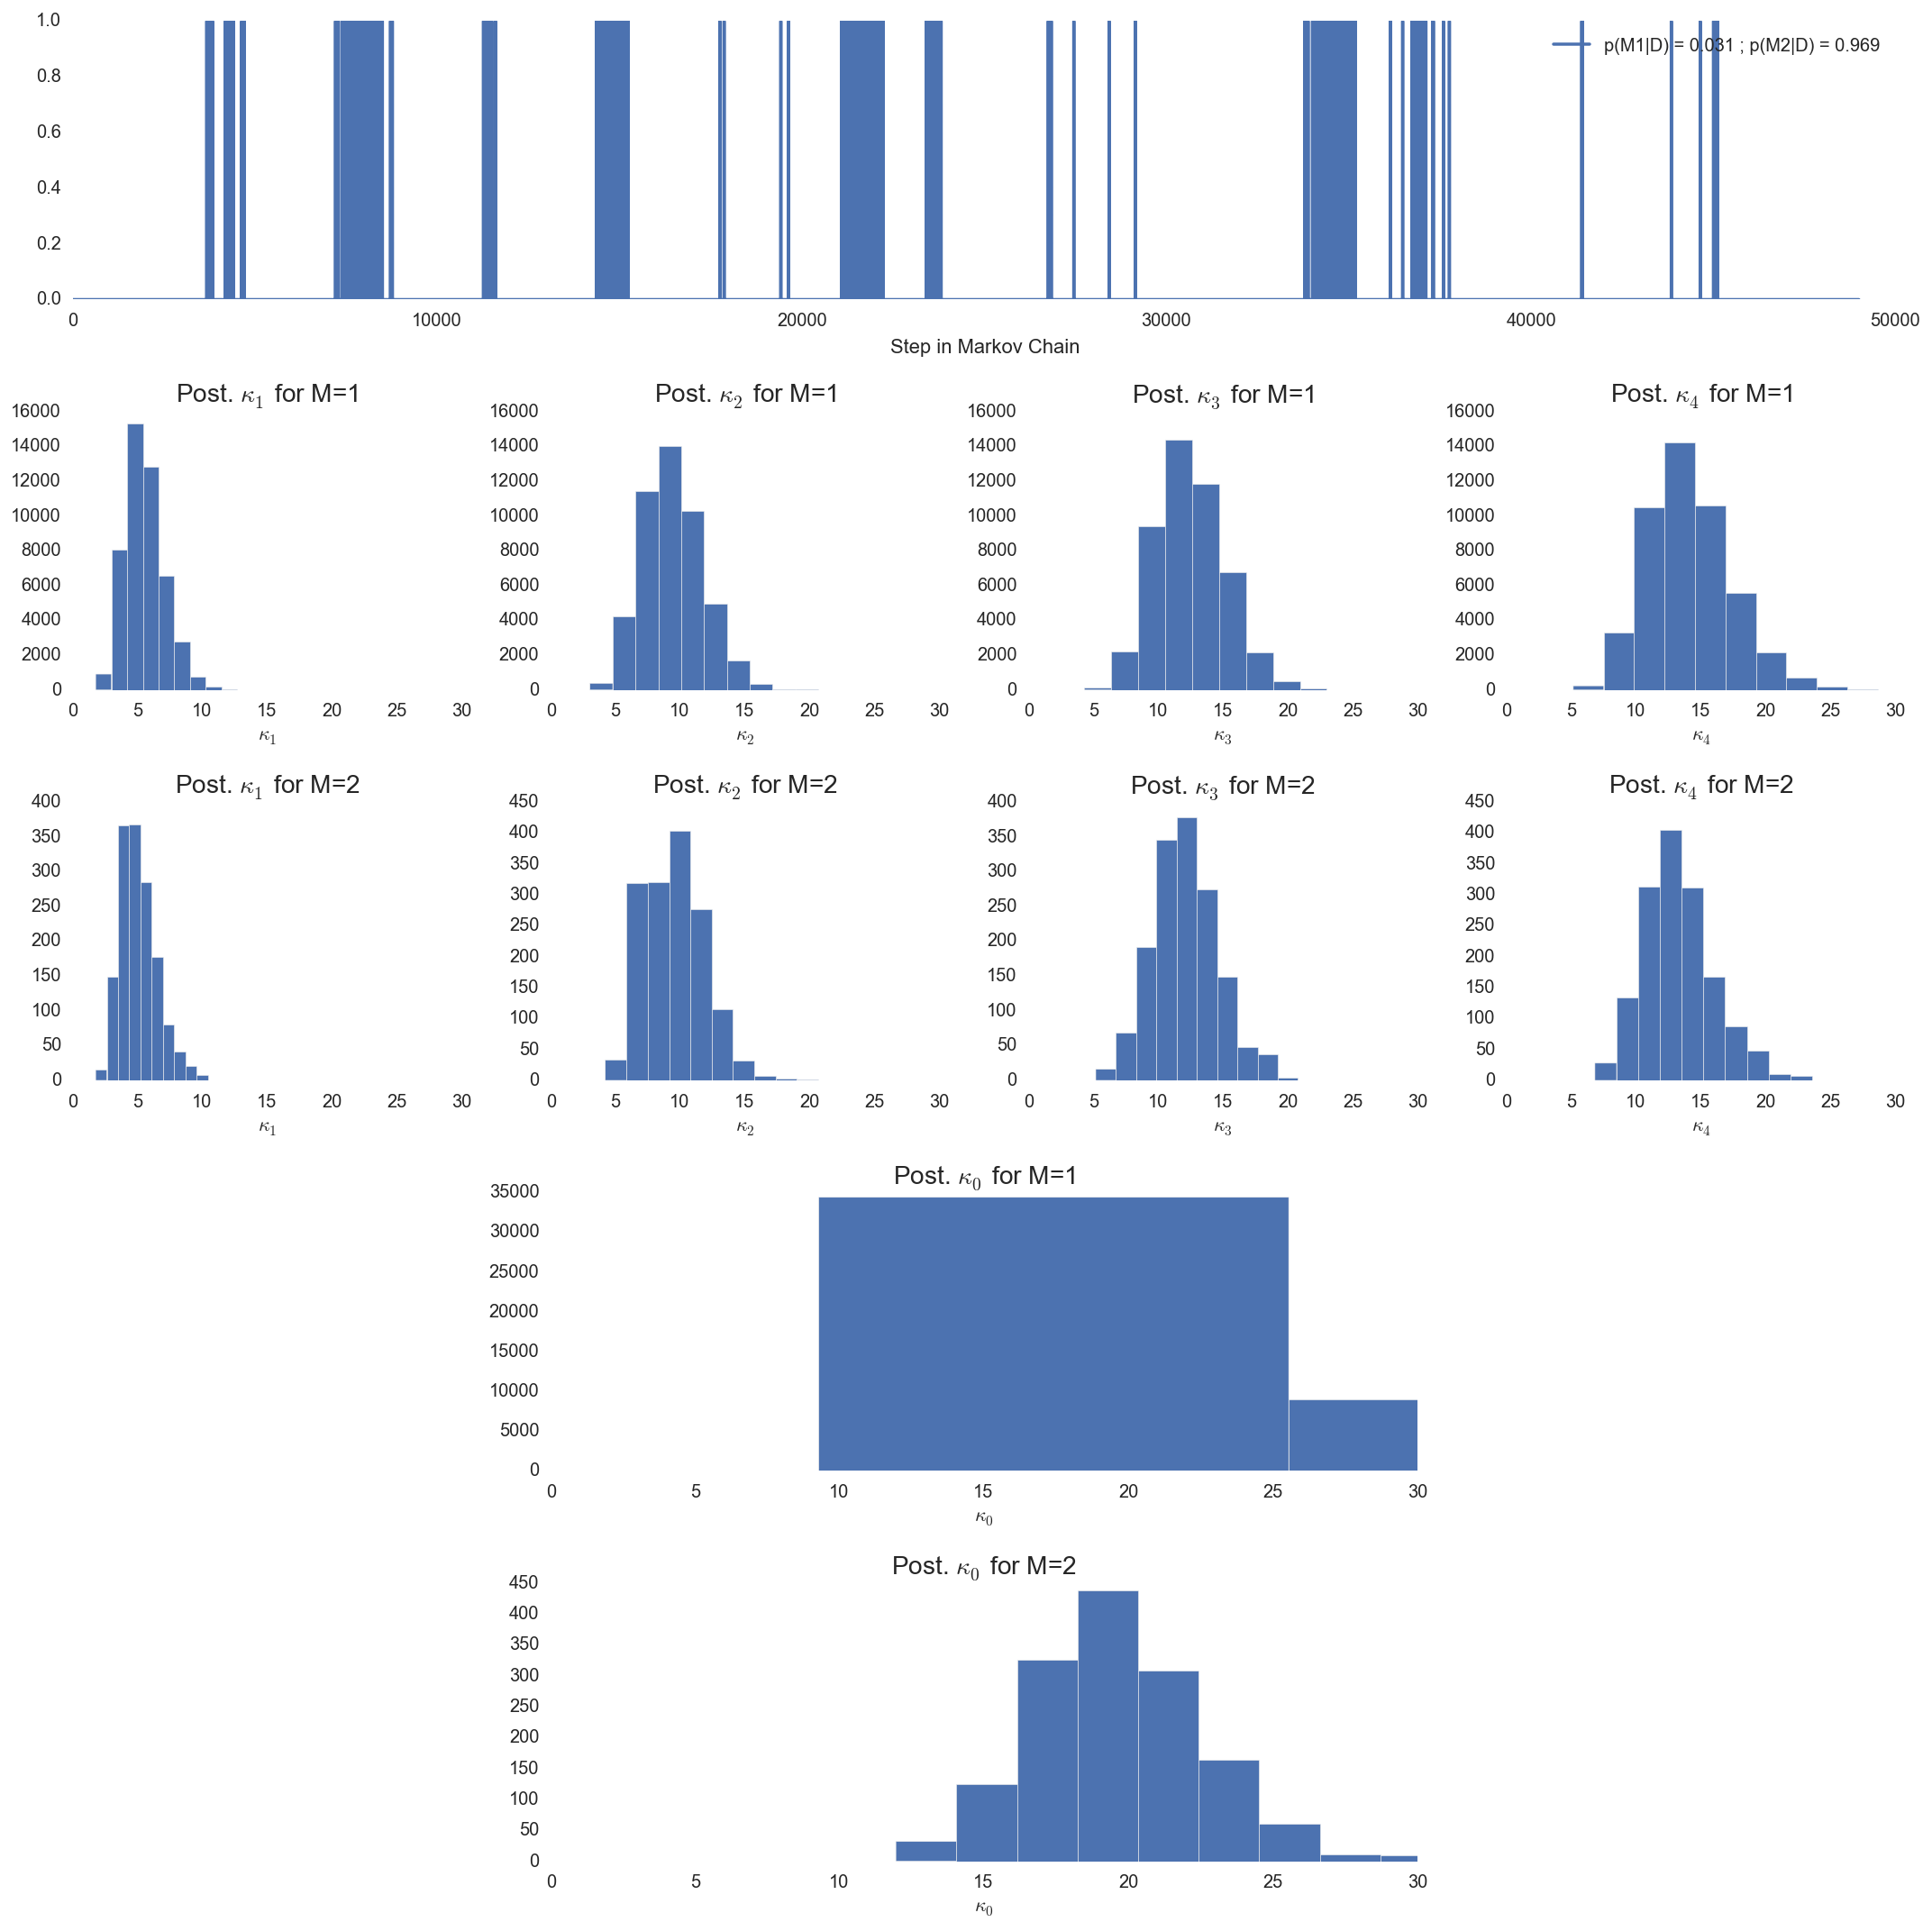

In [43]:
"""
10_FilconModelCompPyMC.py
Comparing models using Hierarchical modelling.
"""

# THE DATA.
# For each subject, specify the condition s/he was in,
# the number of trials s/he experienced, and the number correct.

cond_of_subj = np.repeat([0,1,2,3], 40)

n_trl_of_subj = np.array([64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,
64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,
64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,
64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,
64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,
64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,
64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64])

n_corr_of_subj = np.array([45,63,58,64,58,63,51,60,59,47,63,61,60,51,59,45,61,
59,60,58,63,56,63,64,64,60,64,62,49,64,64,58,64,52,64,64,64,62,64,61,59,59,
55,62,51,58,55,54,59,57,58,60,54,42,59,57,59,53,53,42,59,57,29,36,51,64,60,
54,54,38,61,60,61,60,62,55,38,43,58,60,44,44,32,56,43,36,38,48,32,40,40,34,
45,42,41,32,48,36,29,37,53,55,50,47,46,44,50,56,58,42,58,54,57,54,51,49,52,
51,49,51,46,46,42,49,46,56,42,53,55,51,55,49,53,55,40,46,56,47,54,54,42,34,
35,41,48,46,39,55,30,49,27,51,41,36,45,41,53,32,43,33])

n_subj = len(cond_of_subj)
n_cond = len(set(cond_of_subj))


# THE MODEL.
with pm.Model() as model:
    # Hyperprior on model index:
    model_index = pm.DiscreteUniform('model_index', lower=0, upper=1)
    # Constants for hyperprior:
    shape_Gamma = 1.0
    rate_Gamma = 0.1
    # Hyperprior on mu and kappa:
    mu = pm.Beta('mu', 1, 1, shape=n_cond)

    kappa0 = pm.Gamma('kappa0', shape_Gamma, rate_Gamma)
    a_Beta0 = mu[cond_of_subj] * kappa0
    b_Beta0 = (1 - mu[cond_of_subj]) * kappa0

    kappa1 = pm.Gamma('kappa1', shape_Gamma, rate_Gamma, shape=n_cond)
    a_Beta1 = mu[cond_of_subj] * kappa1[cond_of_subj]
    b_Beta1 = (1 - mu[cond_of_subj]) * kappa1[cond_of_subj]

    #Prior on theta
    theta0 = pm.Beta('theta0', a_Beta0, b_Beta0, shape=n_subj)
    theta1 = pm.Beta('theta1', a_Beta1, b_Beta1, shape=n_subj)
    # if model_index == 0 then sample from theta1 else sample from theta0
    theta = pm.switch(pm.eq(model_index, 0), theta1, theta0)

    # Likelihood:
    y = pm.Binomial('y', p=theta, n=n_trl_of_subj, observed=n_corr_of_subj)

    # Sampling
    start = pm.find_MAP()
    steps = [pm.Metropolis([i]) for i in model.unobserved_RVs[1:]]
    steps.append(pm.ElemwiseCategoricalStep(var=model_index,values=[0,1]))
    trace = pm.sample(50000, steps, start=start, progressbar=False)


# EXAMINE THE RESULTS.
burnin = 1000
thin = 1
model_idx_sample = trace['model_index'][burnin::thin]

pM1 = sum(model_idx_sample == 1) / len(model_idx_sample)
pM2 = 1 - pM1

plt.figure(figsize=(15, 15))
plt.subplot2grid((5,4), (0,0), colspan=4)
plt.plot(model_idx_sample, label='p(M1|D) = %.3f ; p(M2|D) = %.3f' % (pM1, pM2));
plt.xlabel('Step in Markov Chain')
plt.legend(loc='upper right', framealpha=0.75)

for m in range(0, 2):
    kappa0_sample = trace['kappa0'][burnin::thin][model_idx_sample == m]
    plt.subplot2grid((5,4), (3+m, 1), colspan=2)
    plt.hist(kappa0_sample, bins=20)
    plt.title(r'Post. $\kappa_0$ for M=%s' % (m+1), fontsize=14)
    plt.xlabel(r'$\kappa_0$')
    plt.xlim(0, 30)
    for i in range(0, 4):
        kappa1_sample = trace['kappa1'][:,i][burnin::thin][model_idx_sample == m]
        plt.subplot2grid((5,4), (m+1, i))
        plt.hist(kappa1_sample)
        plt.title(r'Post. $\kappa_%s$ for M=%s' % (i+1, m+1), fontsize=14)
        plt.xlabel(r'$\kappa_%s$' % (i+1))
        plt.xlim(0, 30)

plt.tight_layout()

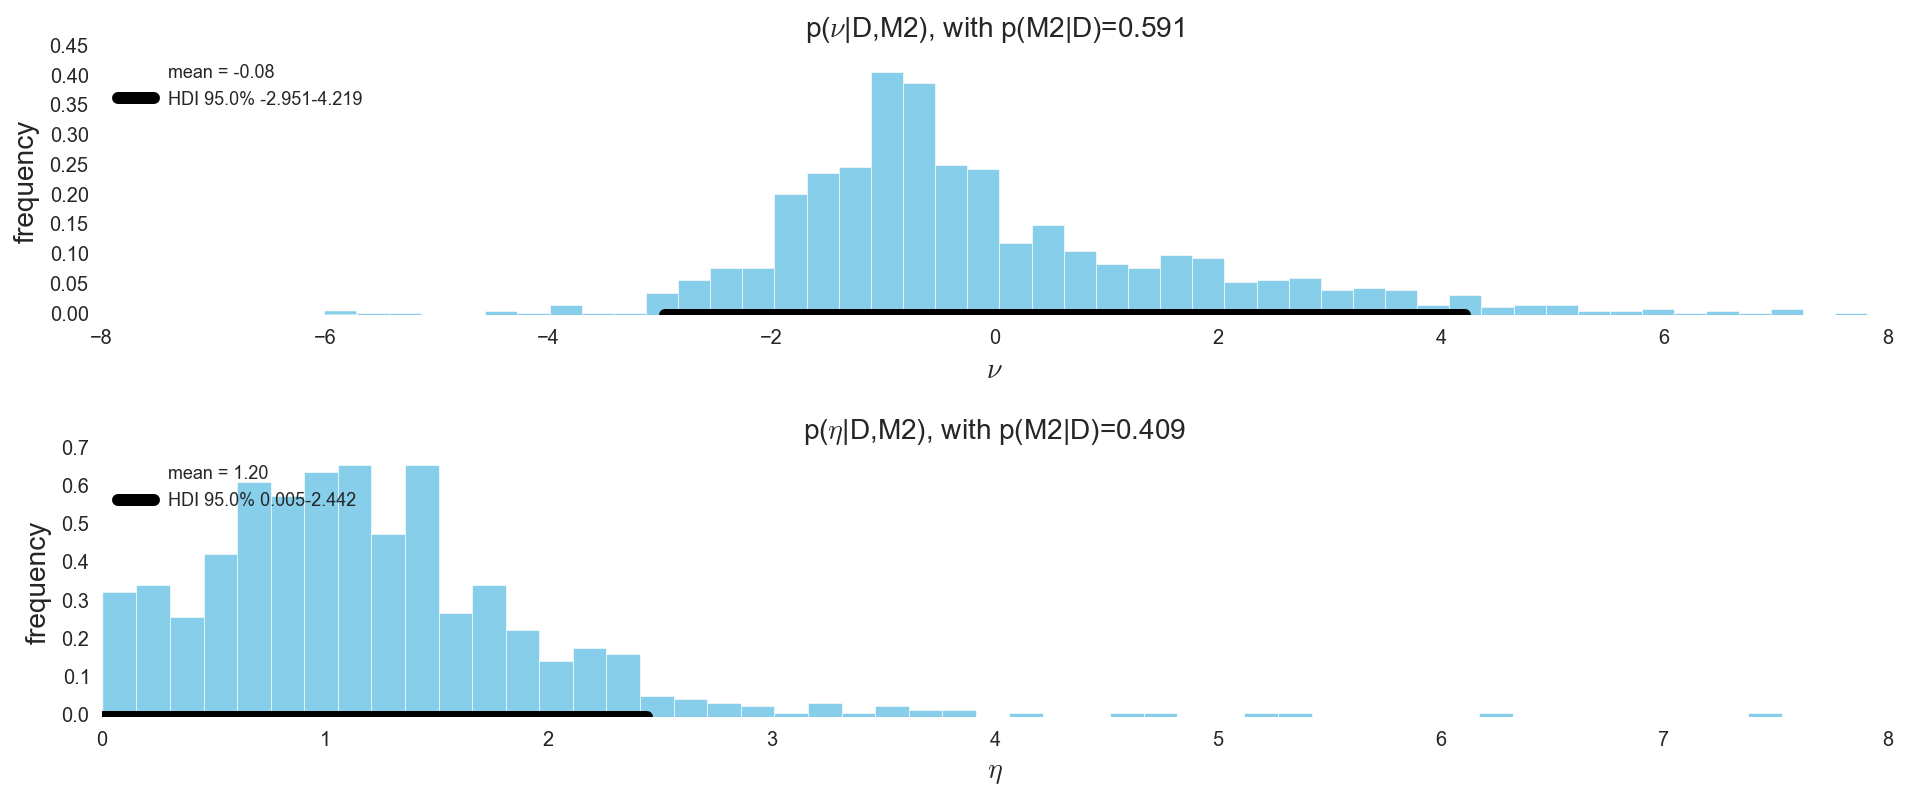

In [44]:
"""
10_ToyModelCompPyMC.py
Comparing models using Hierarchical modelling. Toy Model.
"""

# THE DATA.
N = 30
z = 8
y = np.repeat([1, 0], [z, N-z]) 

# THE MODEL.
with pm.Model() as model:
    # Hyperprior on model index:
    model_index = pm.DiscreteUniform('model_index', lower=0, upper=1)
    # Prior
    nu = pm.Normal('nu', mu=0, tau=0.1) # it is posible to use tau or sd
    eta = pm.Gamma('eta', .1, .1)
    theta0 = 1 / (1 + pm.exp(-nu)) # theta from model index 0
    theta1 = pm.exp(-eta)    # theta from model index 1
    theta = pm.switch(pm.eq(model_index, 0), theta0, theta1)
    # Likelihood
    y = pm.Bernoulli('y', p=theta, observed=y)
    # Sampling
    start = pm.find_MAP()
    step1 = pm.Metropolis(model.vars[1:])
    step2 = pm.ElemwiseCategoricalStep(var=model_index,values=[0,1])
    trace = pm.sample(10000, [step1, step2], start=start, progressbar=False)


# EXAMINE THE RESULTS.
burnin = 1000
thin = 5

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace[burnin::thin], vars =[nu, eta])
#pm.autocorrplot(trace, vars =[nu, eta])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)


model_idx_sample = trace['model_index'][burnin::thin]
pM1 = sum(model_idx_sample == 0) / len(model_idx_sample)
pM2 = 1 - pM1


nu_sample_M1 = trace['nu'][burnin::thin][model_idx_sample == 0]
eta_sample_M2 = trace['eta'][burnin::thin][model_idx_sample == 1]

plt.figure(figsize=(16,6))
plt.subplot(2, 1, 1)
plot_post(nu_sample_M1, xlab=r'$\nu$', show_mode=False, labelsize=9, framealpha=0.5)
plt.xlabel(r'$\nu$')
plt.ylabel('frequency')
plt.title(r'p($\nu$|D,M2), with p(M2|D)=%.3f' % pM1, fontsize=14)
plt.xlim(-8, 8)

plt.subplot(2, 1, 2)
plot_post(eta_sample_M2, xlab=r'$\eta$', show_mode=False, labelsize=9, framealpha=0.5)
plt.xlabel(r'$\eta$')
plt.ylabel('frequency')
plt.title(r'p($\eta$|D,M2), with p(M2|D)=%.3f' % pM2, fontsize=14)
plt.xlim(0, 8)

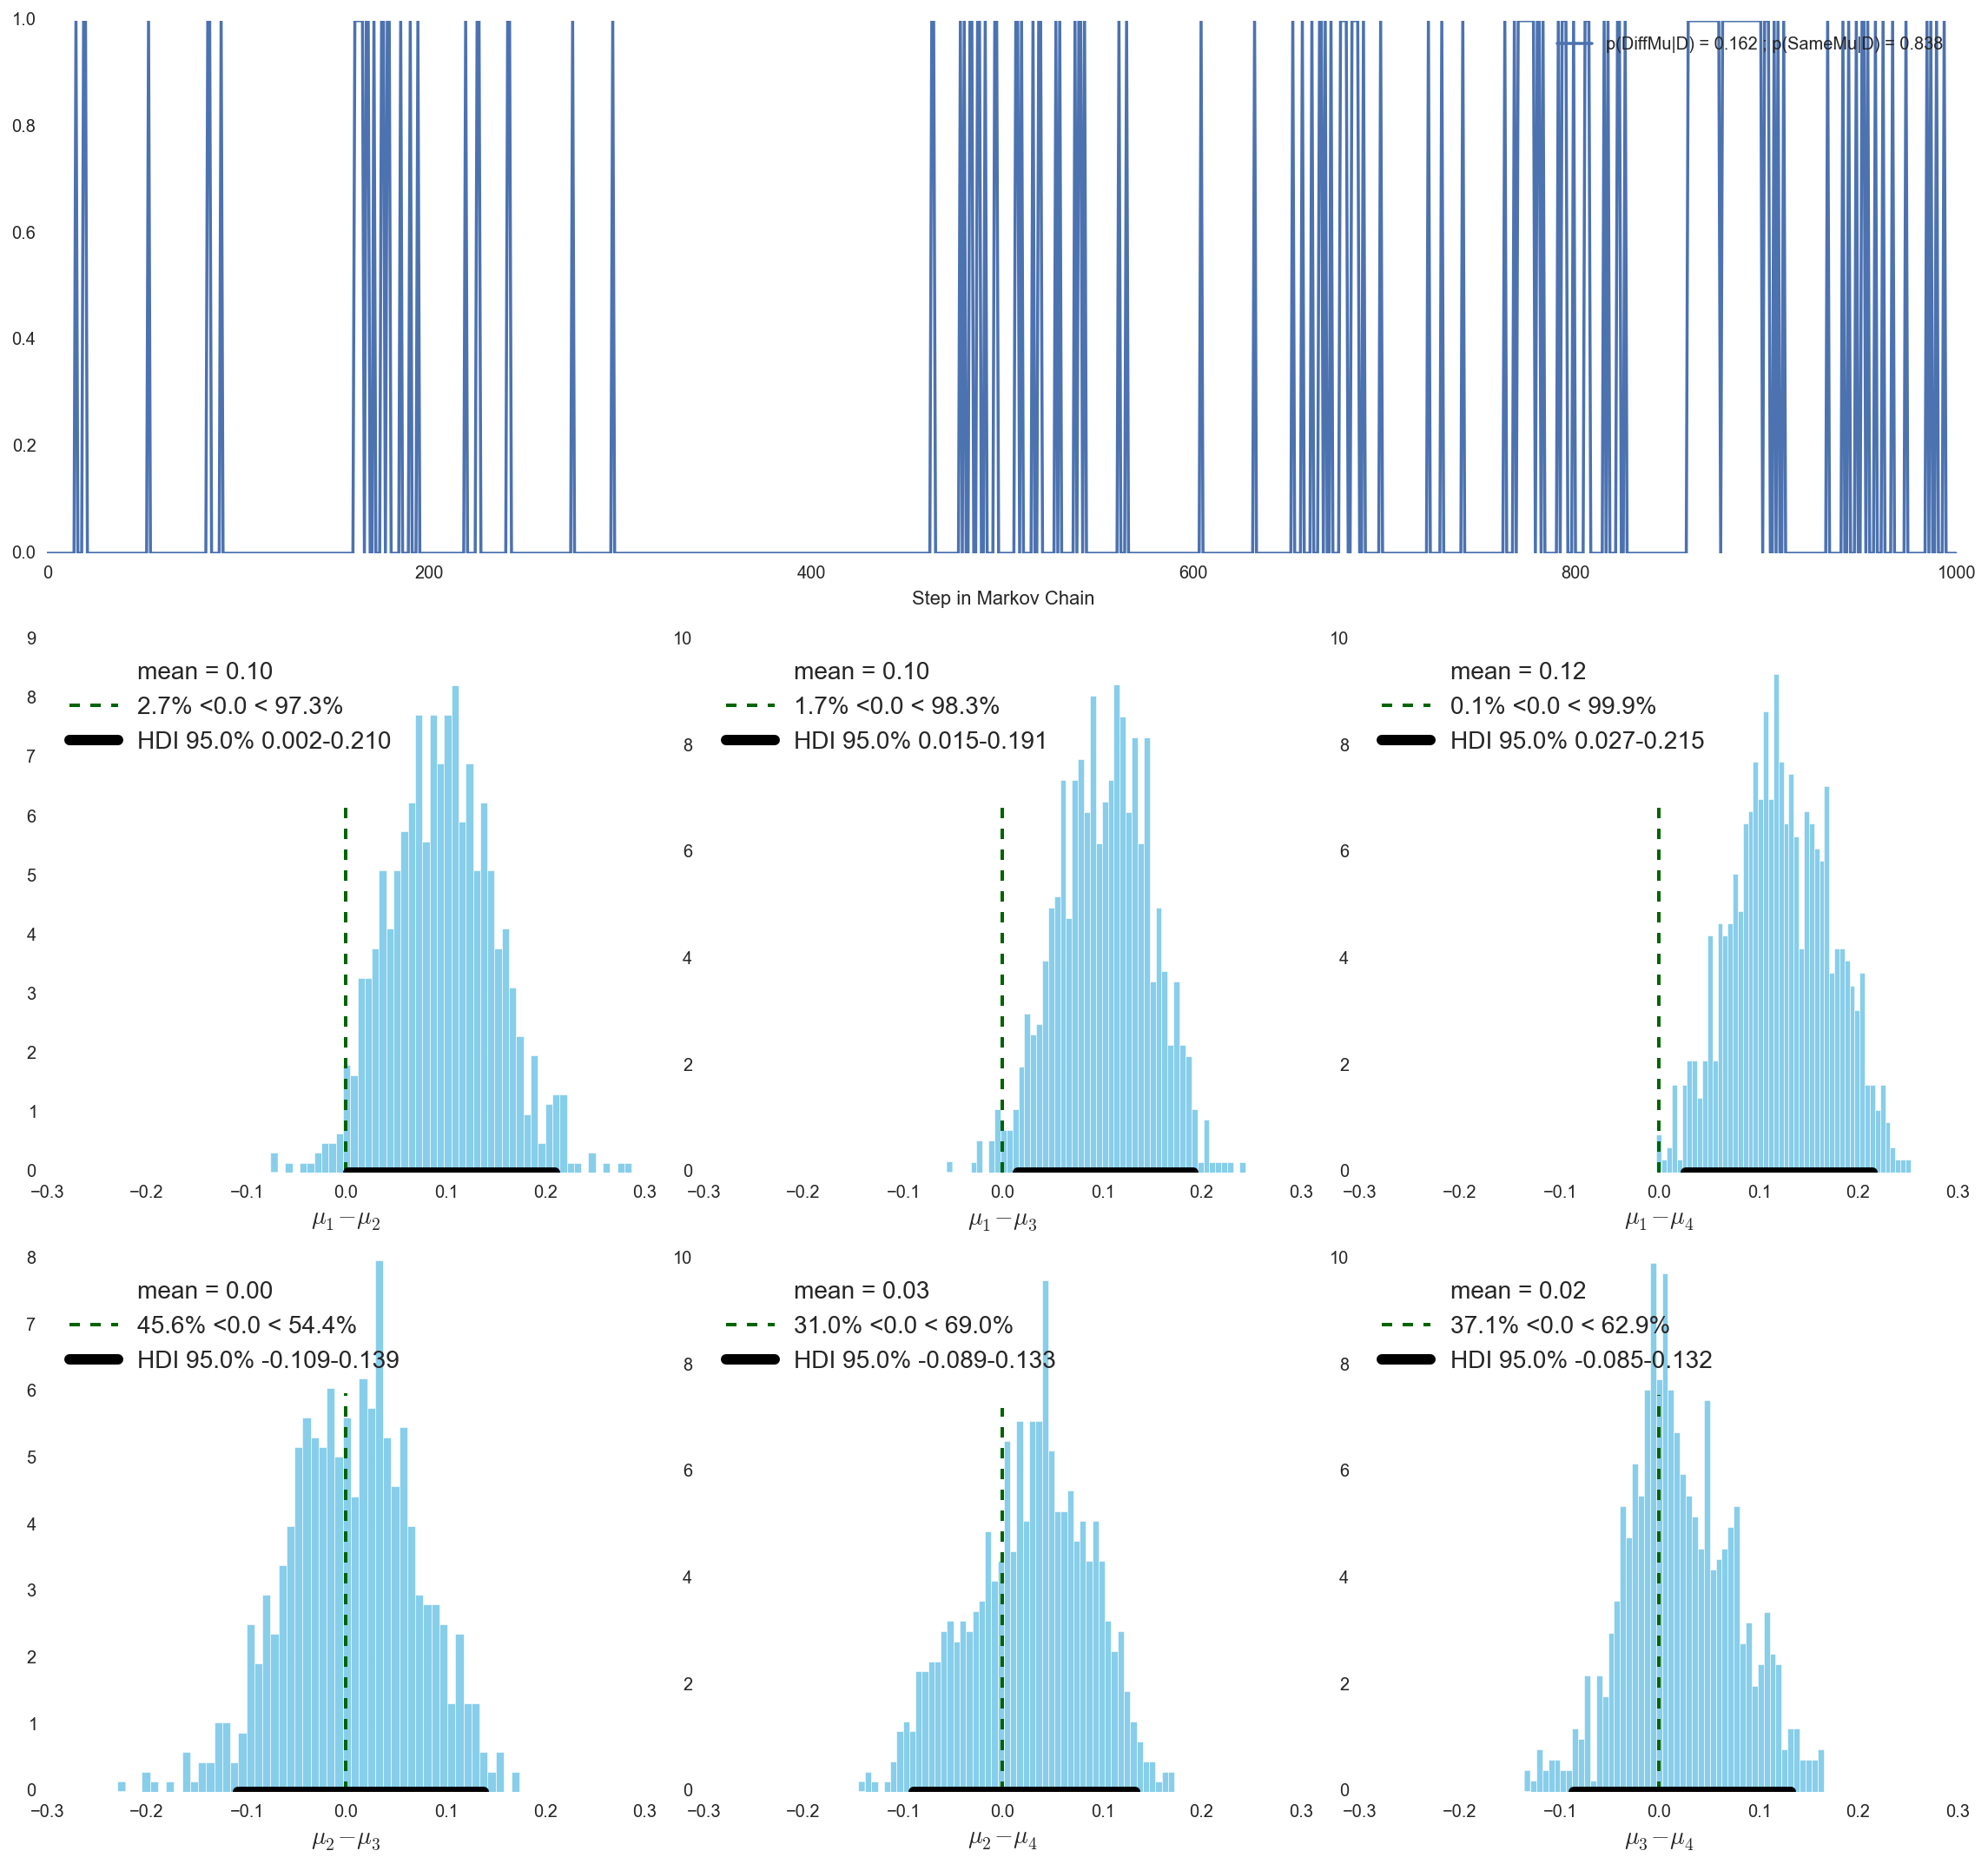

In [48]:
"""
12_OneOddGroupModelComp.py
Testing a point ('Null') Hypothesis (not using seudopriors)
"""

# THE DATA.
# For each subject, specify the condition s/he was in,
# the number of trials s/he experienced, and the number correct.
# (Randomly generated fictitious data.)
npg = 20  # number of subjects per group
ntrl = 20 # number of trials per subject
cond_of_subj = np.repeat([0, 1, 2, 3], npg)
n_trl_of_subj = np.repeat([ntrl], 4*npg)
np.random.seed(47401)

n_corr_of_subj = np.concatenate((binom.rvs(n=ntrl, p=.61, size=npg), 
                binom.rvs(n=ntrl, p=.50, size=npg),
                binom.rvs(n=ntrl, p=.49, size=npg),
                binom.rvs(n=ntrl, p=.51, size=npg)))

n_subj = len(cond_of_subj)
n_cond = len(set(cond_of_subj))


# THE MODEL
with pm.Model() as model:
    # Hyperprior on model index:
    model_index = pm.DiscreteUniform('model_index', lower=0, upper=1)
    # Constants for hyperprior:
    shape_Gamma = 1.0
    rate_Gamma = 0.1
    # Hyperprior on mu and kappa:
    kappa = pm.Gamma('kappa', shape_Gamma, rate_Gamma, shape=n_cond)

    mu0 = pm.Beta('mu0', 1, 1)
    a_Beta0 = mu0 * kappa[cond_of_subj]
    b_Beta0 = (1 - mu0) * kappa[cond_of_subj]

    mu1 = pm.Beta('mu1', 1, 1, shape=n_cond)
    a_Beta1 = mu1[cond_of_subj] * kappa[cond_of_subj]
    b_Beta1 = (1 - mu1[cond_of_subj]) * kappa[cond_of_subj]

    #Prior on theta
    theta0 = pm.Beta('theta0', a_Beta0, b_Beta0, shape=n_subj)
    theta1 = pm.Beta('theta1', a_Beta1, b_Beta1, shape=n_subj)
    # if model_index == 0 then sample from theta1 else sample from theta0
    theta = pm.switch(pm.eq(model_index, 0), theta1, theta0)

    # Likelihood:
    y = pm.Binomial('y', p=theta, n=n_trl_of_subj, observed=n_corr_of_subj)

    # Sampling
    start = pm.find_MAP()
    step1 = pm.Metropolis(model.vars[1:])
    step2 = pm.ElemwiseCategoricalStep(var=model_index,values=[0,1])
    trace = pm.sample(20000, [step1, step2], start=start, progressbar=False)


# EXAMINE THE RESULTS.
burnin = 10000
thin = 10

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace, vars =[mu, kappa])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)

model_idx_sample = trace['model_index'][burnin::thin]
pM1 = sum(model_idx_sample == 1) / len(model_idx_sample)
pM2 = 1 - pM1

plt.figure(figsize=(16, 15))
plt.subplot2grid((3,3), (0,0), colspan=3)
plt.plot(model_idx_sample, label='p(DiffMu|D) = %.3f ; p(SameMu|D) = %.3f' % (pM1, pM2));
plt.xlabel('Step in Markov Chain')
plt.legend(loc='upper right', framealpha=0.75)

count = 0
position = [(1,0), (1,1), (1,2), (2,0), (2,1), (2,2)]
for i in range(0, 4):
    mui_sample = trace['mu1'][:,i][burnin::thin][model_idx_sample == 0]
    for j in range(i+1, 4):
        muj_sample = trace['mu1'][:,j][burnin::thin][model_idx_sample == 0]
        plt.subplot2grid((3,3), position[count])
        plot_post(mui_sample-muj_sample, xlab=r'$\mu_%s - \mu_%s$' % (i+1, j+1), show_mode=False, comp_val=0, framealpha=0.5)
        plt.xlim(-0.3, 0.3)
        count += 1


plt.tight_layout()

In [49]:
"""
HDIofICDF.py
This program finds the HDI of a probability density function that is specified 
mathematically in Python.
"""

def HDIofICDF(dist_name, credMass=0.95, **args):
    # freeze distribution with given arguments
    distri = dist_name(**args)
    # initial guess for HDIlowTailPr
    incredMass =  1.0 - credMass

    def intervalWidth(lowTailPr):
        return distri.ppf(credMass + lowTailPr) - distri.ppf(lowTailPr)

    # find lowTailPr that minimizes intervalWidth
    HDIlowTailPr = fmin(intervalWidth, incredMass, ftol=1e-8, disp=False)[0]
    # return interval as array([low, high])
    return distri.ppf([HDIlowTailPr, credMass + HDIlowTailPr])

In [50]:
"""
13_minNforHDIpower.py
The program described in this section was used to generate Tables 13.1 and 13.2.
The program determines the minimal sample size needed to achieve a specified 
goal with a specified power, when flipping a single coin.
"""

def minNforHDIpower(genPriorMean, genPriorN, HDImaxwid=None, nullVal=None,
                    ROPE=None, desiredPower=0.8, audPriorMean=0.5,
                    audPriorN=2, HDImass=0.95, initSampSize=1, verbose=True):
    if HDImaxwid != None and nullVal != None:
        sys.exit('One and only one of HDImaxwid and nullVal must be specified')
    if ROPE == None:
        ROPE = [nullVal, nullVal]
    
    # Convert prior mean and N to a, b parameter values of beta distribution.
    genPriorA = genPriorMean * genPriorN
    genPriorB = (1.0 - genPriorMean) * genPriorN
    audPriorA = audPriorMean * audPriorN
    audPriorB = (1.0 - audPriorMean) * audPriorN
    # Initialize loop for incrementing sampleSize
    sampleSize = initSampSize
    # Increment sampleSize until desired power is achieved.
    while True:
        zvec = np.arange(0, sampleSize+1) # All possible z values for N flips.
        # Compute probability of each z value for data-generating prior.
        pzvec = np.exp(np.log(special_binom(sampleSize, zvec))
                   + special_betaln(zvec + genPriorA, sampleSize - zvec + genPriorB)
                   - special_betaln(genPriorA, genPriorB))
        # For each z value, compute HDI. hdiMat is min, max of HDI for each z.
        hdiMat = np.zeros((len(zvec), 2))
        for zIdx in range(0, len(zvec)):
            z = zvec[zIdx]
            # Determine the limits of the highest density interval
            # hdp is a function from PyMC package and takes a sample vector as 
            # input, not a function.
            hdiMat[zIdx] = HDIofICDF(beta, credMass=HDImass, a=(z + audPriorA), 
                                     b=(sampleSize - z + audPriorB))
        if HDImaxwid != None:
            hdiWid = hdiMat[:,1] - hdiMat[:,0]
            powerHDI = np.sum(pzvec[hdiWid < HDImaxwid])
        if nullVal != None:
            powerHDI = np.sum(pzvec[(hdiMat[:,0] > ROPE[1]) | 
                                    (hdiMat[:,1] < ROPE[0])])
        if verbose:
            print " For sample size = %s\npower = %s\n" % (sampleSize, powerHDI)

        if powerHDI > desiredPower:
            break
        else:
            sampleSize += 1
    return sampleSize

print minNforHDIpower(genPriorMean=.85 , genPriorN=2000 , nullVal=0.5, verbose=False)
#print minNforHDIpower(genPriorMean=.85 , genPriorN=10 , HDImaxwid=0.2, verbose=False)

10


In [51]:
 Systems = """Aircraft    Failure      Days        DaysTransf
    1.          1.        194.          2.867876
    1.          2.         15.          1.718772
    1.          3.         41.          2.101632
    1.          4.         29.          1.961009
    1.          5.         33.          2.012347
    1.          6.        181.          2.828367
    2.          1.        413.          3.335723
    2.          2.         14.          1.695218
    2.          3.         58.          2.252608
    2.          4.         37.          2.058924
    2.          5.        100.          2.511886
    2.          6.         65.          2.304532
    2.          7.          9.          1.551846
    2.          8.        169.          2.789827
    2.          9.        447.          3.388921
    2.         10.        184.          2.837681
    2.         11.         36.          2.047673
    2.         12.        201.          2.888279
    2.         13.        118.          2.596429
    3.          1.         90.          2.459509
    3.          2.         10.          1.584893
    3.          3.         60.          2.267933
    3.          4.        186.          2.843823
    3.          5.         61.          2.275443
    3.          6.         49.          2.177906
    3.          7.         14.          1.695218
    3.          8.         24.          1.888175
    3.          9.         56.          2.236854
    3.         10.         20.          1.820564
    3.         11.         79.          2.396213
    3.         12.         84.          2.425805
    3.         13.         44.          2.131526
    3.         14.         59.          2.260322
    3.         15.         29.          1.961009
    3.         16.        118.          2.596429
    3.         17.         25.          1.903654
    3.         18.        156.          2.745522
    3.         19.        310.          3.149723
    3.         20.         76.          2.377731
    3.         21.         26.          1.918645
    3.         22.         44.          2.131526
    3.         23.         23.          1.872171
    3.         24.         62.          2.282855
    4.          1.         74.          2.365083
    4.          2.         57.          2.244786
    4.          3.         48.          2.168944
    4.          4.         29.          1.961009
    4.          5.        502.          3.468492
    4.          6.         12.          1.643752
    4.          7.         70.          2.338943
    4.          8.         21.          1.838416
    4.          9.         29.          1.961009
    4.         10.        386.          3.290921
    4.         11.         59.          2.260322
    4.         12.         27.          1.933182
    5.          1.         55.          2.228807
    5.          2.        320.          3.169786
    5.          3.         56.          2.236854
    5.          4.        104.          2.531668
    5.          5.        220.          2.940929
    5.          6.        239.          2.990058
    5.          7.         47.          2.15983 
    5.          8.        246.          3.007371
    5.          9.        176.          2.812565
    5.         10.        182.          2.831485
    5.         11.         33.          2.012347
    6.          1.         23.          1.872171
    6.          2.        261.          3.043183
    6.          3.         87.          2.44289 
    6.          4.          7.          1.475773
    6.          5.        120.          2.605171
    6.          6.         14.          1.695218
    6.          7.         62.          2.282855
    6.          8.         47.          2.15983 
    6.          9.        225.          2.954177
    6.         10.         71.          2.345588
    6.         11.        246.          3.007371
    6.         12.         21.          1.838416
    6.         13.         42.          2.111786
    6.         14.         20.          1.820564
    6.         15.          5.          1.37973 
    6.         16.         12.          1.643752
    6.         17.        120.          2.605171
    6.         18.         11.          1.615394
    6.         19.          3.          1.245731
    6.         20.         14.          1.695218
    6.         21.         71.          2.345588
    6.         22.         11.          1.615394
    6.         23.         14.          1.695218
    6.         24.         11.          1.615394
    6.         25.         16.          1.741101
    6.         26.         90.          2.459509
    6.         27.          1.          1.      
    6.         28.         16.          1.741101
    6.         29.         52.          2.203945
    6.         30.         95.          2.48625 
    7.          1.         97.          2.496631
    7.          2.         51.          2.195402
    7.          3.         11.          1.615394
    7.          4.          4.          1.319508
    7.          5.        141.          2.690567
    7.          6.         18.          1.782602
    7.          7.        142.          2.694373
    7.          8.         68.          2.325422
    7.          9.         77.          2.383956
    7.         10.         80.          2.402249
    7.         11.          1.          1.      
    7.         12.         16.          1.741101
    7.         13.        106.          2.541331
    7.         14.        206.          2.902508
    7.         15.         82.          2.414142
    7.         16.         54.          2.220643
    7.         17.         31.          1.987341
    7.         18.        216.          2.930156
    7.         19.         46.          2.15056 
    7.         20.        111.          2.564865
    7.         21.         39.          2.080717
    7.         22.         63.          2.290172
    7.         23.         18.          1.782602
    7.         24.        191.          2.858951
    7.         25.         18.          1.782602
    7.         26.        163.          2.769731
    7.         27.         24.          1.888175
    8.          1.         50.          2.186724
    8.          2.         44.          2.131526
    8.          3.        102.          2.521855
    8.          4.         72.          2.352158
    8.          5.         22.          1.855601
    8.          6.         39.          2.080717
    8.          7.          3.          1.245731
    8.          8.         15.          1.718772
    8.          9.        197.          2.876691
    8.         10.        188.          2.849913
    8.         11.         79.          2.396213
    8.         12.         88.          2.44848 
    8.         13.         46.          2.15056 
    8.         14.          5.          1.37973 
    8.         15.          5.          1.37973 
    8.         16.         36.          2.047673
    8.         17.         22.          1.855601
    8.         18.        139.          2.682891
    8.         19.        210.          2.913693
    8.         20.         97.          2.496631
    8.         21.         30.          1.97435 
    8.         22.         23.          1.872171
    8.         23.         13.          1.670278
    8.         24.         14.          1.695218
    9.          1.        359.          3.243537
    9.          2.          9.          1.551846
    9.          3.         12.          1.643752
    9.          4.        270.          3.063887
    9.          5.        603.          3.598019
    9.          6.          3.          1.245731
    9.          7.        104.          2.531668
    9.          8.          2.          1.148698
    9.          9.        438.          3.375164
   10.          1.         50.          2.186724
   10.          2.        254.          3.026682
   10.          3.          5.          1.37973 
   10.          4.        283.          3.092839
   10.          5.         35.          2.036168
   10.          6.         12.          1.643752
   11.          1.        487.          3.447512
   11.          2.         18.          1.782602
   11.          3.        100.          2.511886
   11.          4.          7.          1.475773
   11.          5.         98.          2.501758
   11.          6.          5.          1.37973 
   11.          7.         85.          2.431553
   11.          8.         91.          2.464951
   11.          9.         43.          2.121747
   11.         10.        230.          2.967191
   11.         11.          3.          1.245731
   11.         12.        130.          2.647212
   12.          1.        102.          2.521855
   12.          2.        209.          2.910913
   12.          3.         14.          1.695218
   12.          4.         57.          2.244786
   12.          5.         54.          2.220643
   12.          6.         32.          2.      
   12.          7.         67.          2.318542
   12.          8.         59.          2.260322
   12.          9.        134.          2.663305
   12.         10.        152.          2.731296
   12.         11.         27.          1.933182
   12.         12.         14.          1.695218
   12.         13.        230.          2.967191
   12.         14.         66.          2.311579
   12.         15.         61.          2.275443
   12.         16.         34.          2.024397
"""

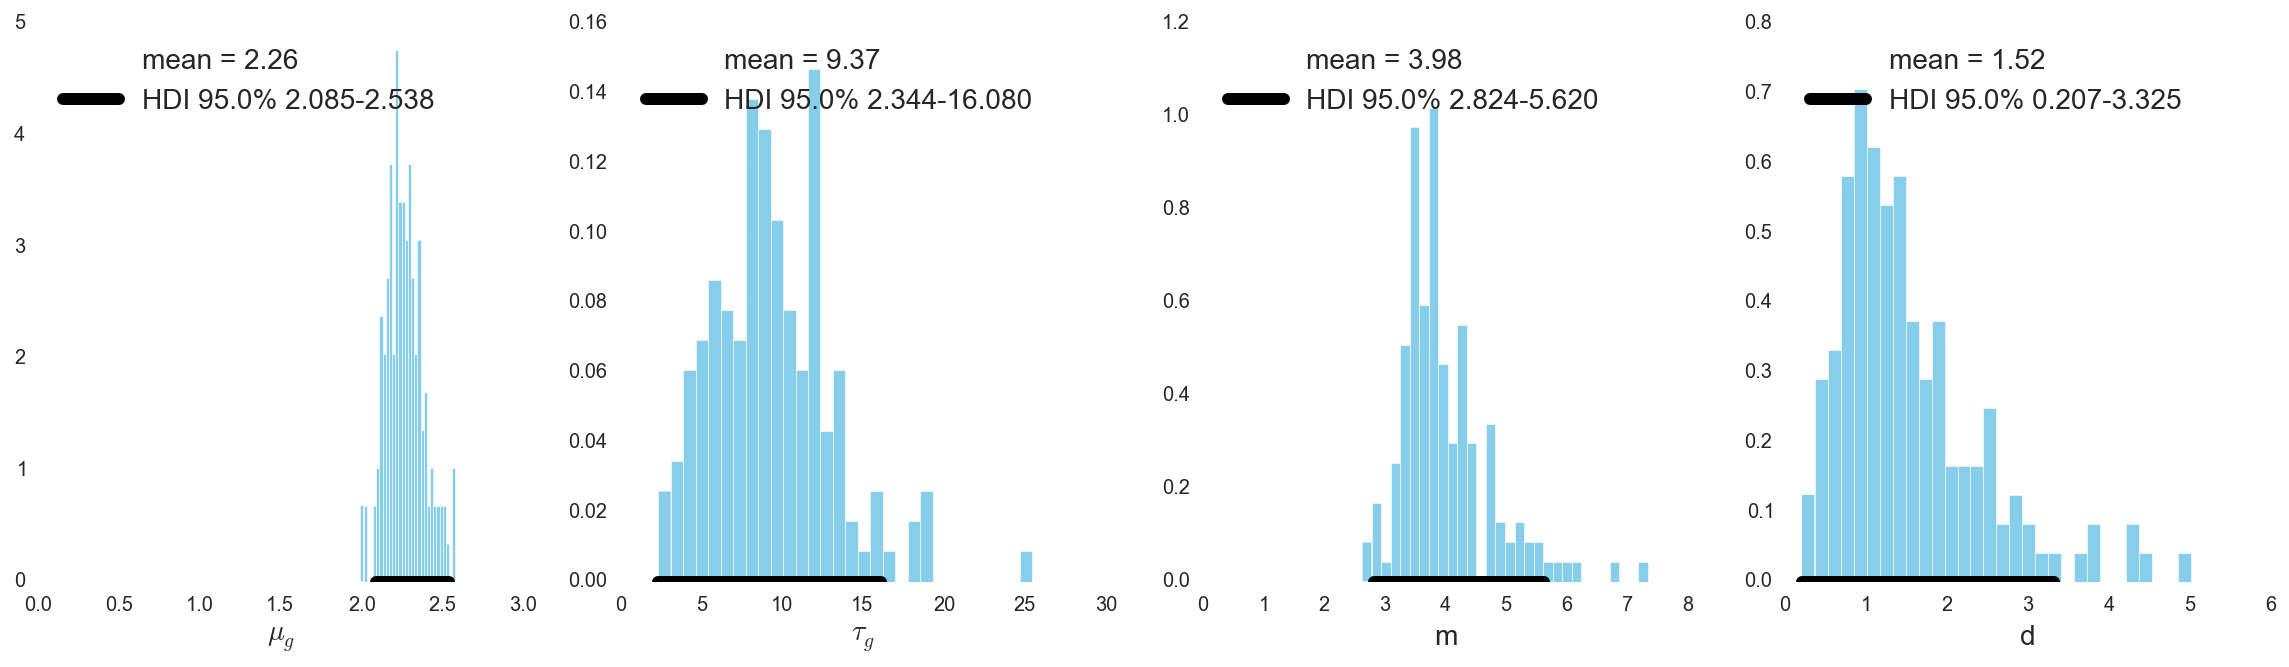

In [52]:
'''
15_SystemsPyMC.py
Estimating the mean and standard deviation of a Gaussian likelihood with a
hierarchical model.
'''
# THE DATA.
# Load the aircraft data:
data = np.genfromtxt(StringIO(Systems), skip_header=True)

n_subj = len(set(data[:,0]))
# Put it into generic variables so easier to change data in other applications:
y = data[:,3]
subj = data[:,0].astype(int)


## Specify the model in PyMC
with pm.Model() as model:
    # define the HyperPriors
    muG = pm.Normal('muG', mu=2.3, tau=0.1)
    tauG = pm.Gamma('tauG', 1, .5)
    m = pm.Gamma('m', 1, .25)
    d = pm.Gamma('d', 1, .5)
    sG = m**2 / d**2
    rG = m / d**2
    # define the priors
    tau = pm.Gamma('tau', sG, rG, shape=n_subj)
    mu = pm.Normal('mu', mu=muG, tau=tauG, shape=n_subj)
    # define the likelihood
    y = pm.Normal('y', mu=mu[subj-1], tau=tau[subj-1], observed=y)
    # Generate a MCMC chain
    #start = pm.find_MAP()
    #step = pm.Metropolis()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, progressbar=False)


# EXAMINE THE RESULTS
burnin = 5000
thin = 100


## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace[burnin::thin], vars =[mu, tau])
#pm.autocorrplot(trace, vars =[mu, tau])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)


## Extract chains
muG_sample = trace['muG'][burnin::thin]
tauG_sample = trace['tauG'][burnin::thin]
m_sample = trace['m'][burnin::thin]
d_sample = trace['d'][burnin::thin]

# Plot the hyperdistributions:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plot_post(muG_sample, xlab=r'$\mu_g$', bins=30, show_mode=False)
plt.subplot(1, 4, 2)
plot_post(tauG_sample, xlab=r'$\tau_g$', bins=30, show_mode=False)
plt.subplot(1, 4, 3)
plot_post(m_sample, xlab='m', bins=30, show_mode=False)
plt.subplot(1, 4, 4)
plot_post(d_sample, xlab='d', bins=30, show_mode=False)

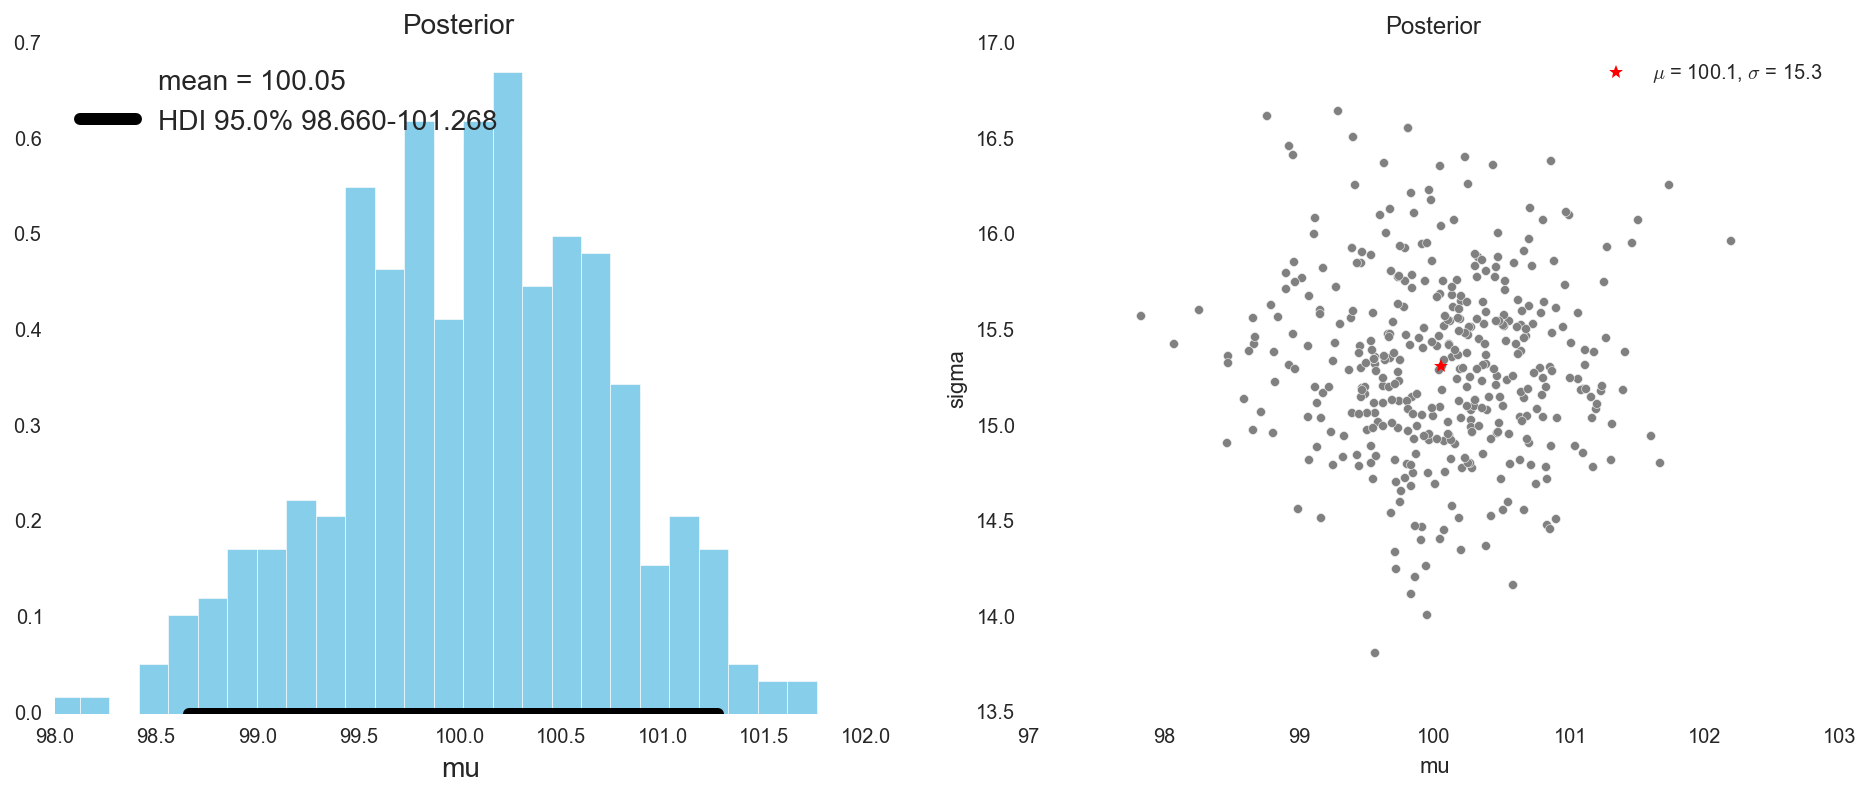

In [53]:
'''
15_YmetricXsinglePyMC.py
Estimating the mean and standard deviation of a Gaussian likelihood.
'''

# THE DATA.

# Generate random data from known parameter values:
np.random.seed(4745)
true_mu = 100
true_std = 15
y = norm.rvs(true_mu, true_std, 500)


# Specify the model in PyMC
with pm.Model() as model:
    # define the priors
    tau = pm.Gamma('tau', 0.01, 0.01)
    mu = pm.Normal('mu', mu=0, tau=1E-10) # PyMC support precission and std
    #define the likelihood
    y = pm.Normal('y', mu=mu, tau=tau, observed=y)
#   Generate a MCMC chain
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(5000, step, start, progressbar=False)


# EXAMINE THE RESULTS
burnin = 1000
thin = 10


## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace[burnin::thin], vars =[mu, tau])
#pm.autocorrplot(trace, vars =[mu, tau])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)

mu_sample = trace['mu'][burnin::thin]
tau_sample = trace['tau'][burnin::thin]
sigma_sample = 1 / np.sqrt(tau_sample) # Convert precision to std


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_post(mu_sample, xlab='mu', bins=30, title='Posterior', show_mode=False)
plt.xlim(98, 102)

plt.subplot(1, 2, 2)

mu_mean = np.mean(mu_sample)
sigma_mean = np.mean(sigma_sample)

plt.scatter(mu_sample, sigma_sample , c='gray')
plt.plot(mu_mean, sigma_mean, 'r*',
        label=r'$\mu$ = %.1f, $\sigma$ = %.1f' % (mu_mean, sigma_mean))
plt.xlabel('mu')
plt.ylabel('sigma')
plt.title('Posterior')
plt.legend(loc=0)

In [54]:
"""
HtWtDataGenerator.py
Random height, weight generator for males and females. Uses parameters from
Brainard, J. & Burmaster, D. E. (1992). Bivariate distributions for height and
weight of men and women in the United States. Risk Analysis, 12(2), 267-275.
John K. Kruschke, January 2008.
"""

def HtWtDataGenerator(nSubj, rndsd=None):
    # Specify parameters of multivariate normal (MVN) distributions.
    # Men:
    HtMmu = 69.18
    HtMsd = 2.87
    lnWtMmu = 5.14
    lnWtMsd = 0.17
    Mrho = 0.42
    Mmean = np.array([HtMmu , lnWtMmu])
    Msigma = np.array([[HtMsd**2, Mrho * HtMsd * lnWtMsd],
                     [Mrho * HtMsd * lnWtMsd, lnWtMsd**2]])

    # Women cluster 1:
    HtFmu1 = 63.11
    HtFsd1 = 2.76
    lnWtFmu1 = 5.06
    lnWtFsd1 = 0.24
    Frho1 = 0.41
    prop1 = 0.46
    Fmean1 = np.array([HtFmu1, lnWtFmu1])
    Fsigma1 = np.array([[HtFsd1**2, Frho1 * HtFsd1 * lnWtFsd1],
                     [Frho1 * HtFsd1 * lnWtFsd1, lnWtFsd1**2]])
    # Women cluster 2:
    HtFmu2 = 64.36
    HtFsd2 = 2.49
    lnWtFmu2 = 4.86
    lnWtFsd2 = 0.14
    Frho2 = 0.44
    prop2 = 1 - prop1
    Fmean2 = np.array([HtFmu2, lnWtFmu2])
    Fsigma2 = np.array([[HtFsd2**2 , Frho2 * HtFsd2 * lnWtFsd2],
                [Frho2 * HtFsd2 * lnWtFsd2 , lnWtFsd2**2]])

    # Randomly generate data values from those MVN distributions.
    if rndsd is not None:
        np.random.seed(rndsd)
    datamatrix = np.zeros((nSubj, 3))
    # arbitrary coding values
    maleval = 1
    femaleval = 0 
    for i in range(0, nSubj):
        # Flip coin to decide sex
        sex = np.random.choice([maleval, femaleval], replace=True, p=(.5,.5), size=1)
        if sex == maleval:
            datum = multivariate_normal.rvs(mean=Mmean, cov=Msigma) 
        if sex == femaleval:
            Fclust = np.random.choice([1, 2], replace=True, p=(prop1, prop2), size=1)
            if Fclust == 1:
                datum = multivariate_normal.rvs(mean=Fmean1, cov=Fsigma1)
            if Fclust == 2: 
                datum = multivariate_normal.rvs(mean=Fmean2, cov=Fsigma2)
        datamatrix[i] = np.concatenate([sex, np.round([datum[0], np.exp(datum[1])], 1)])

    return datamatrix

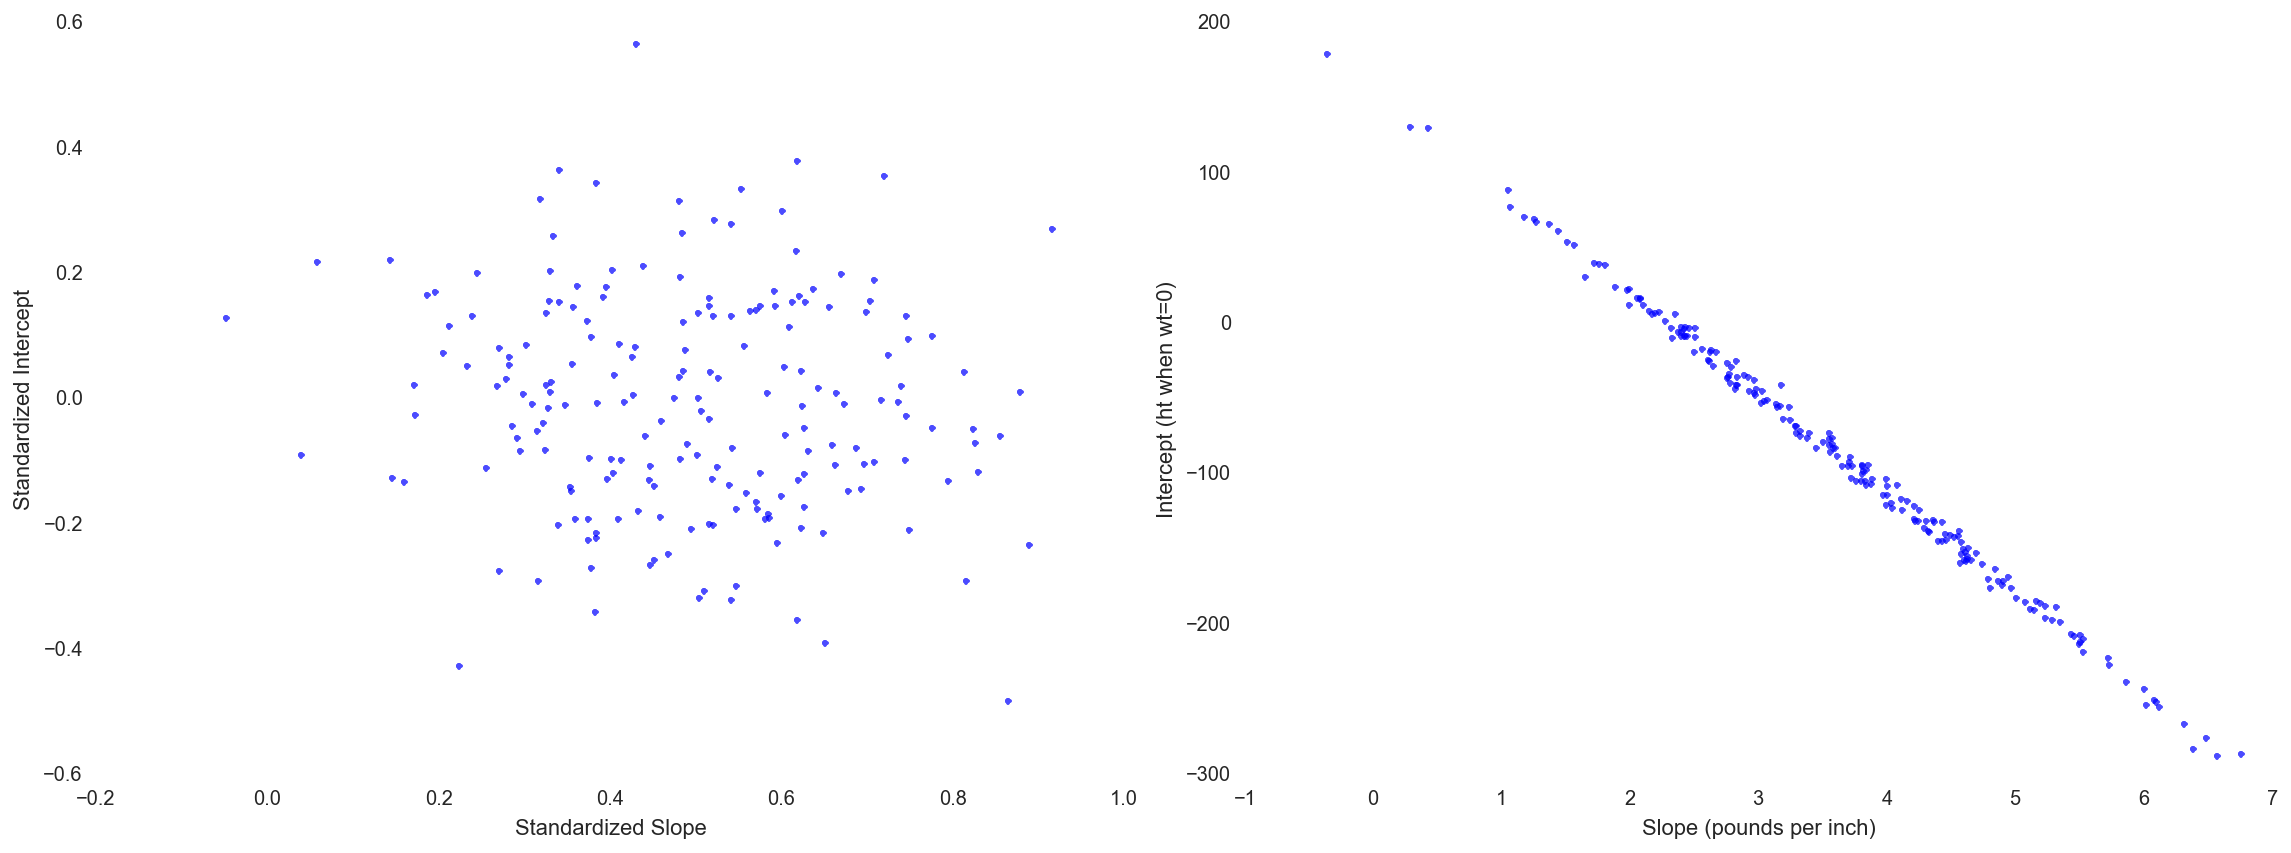

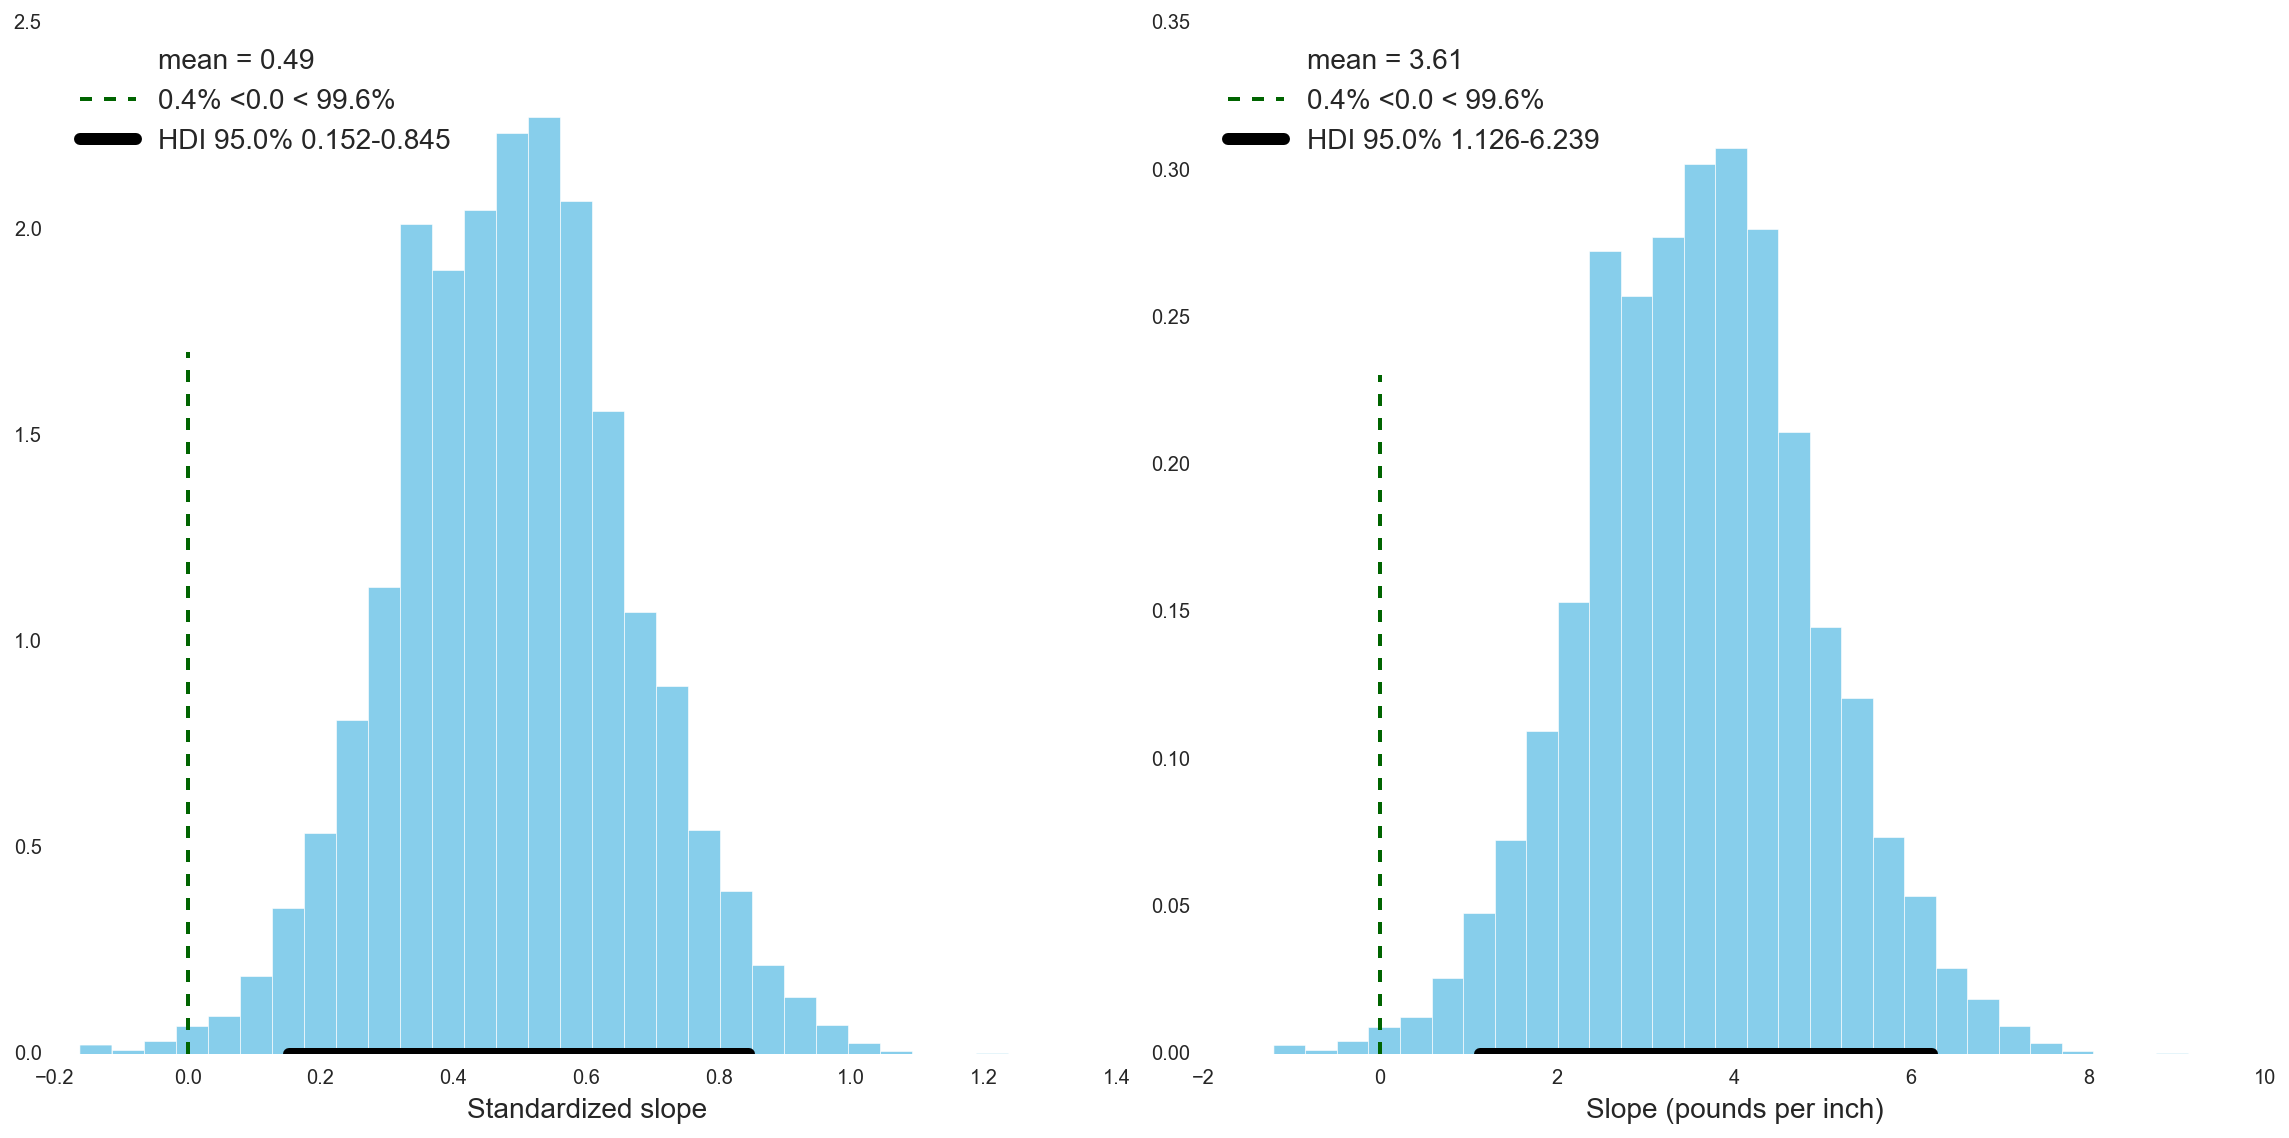

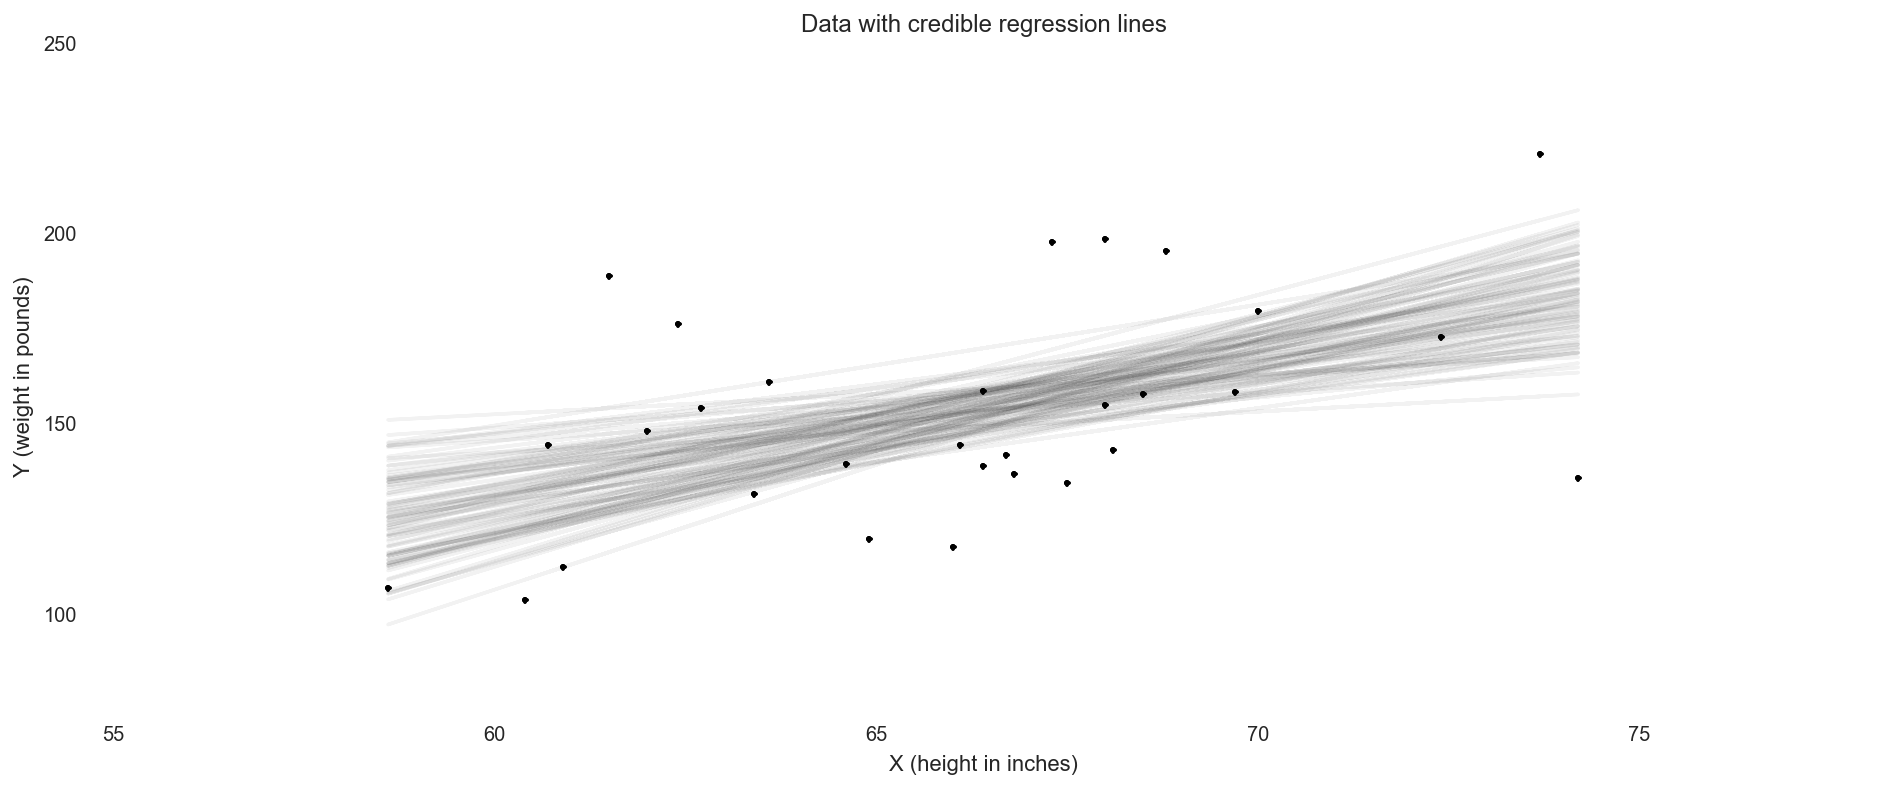

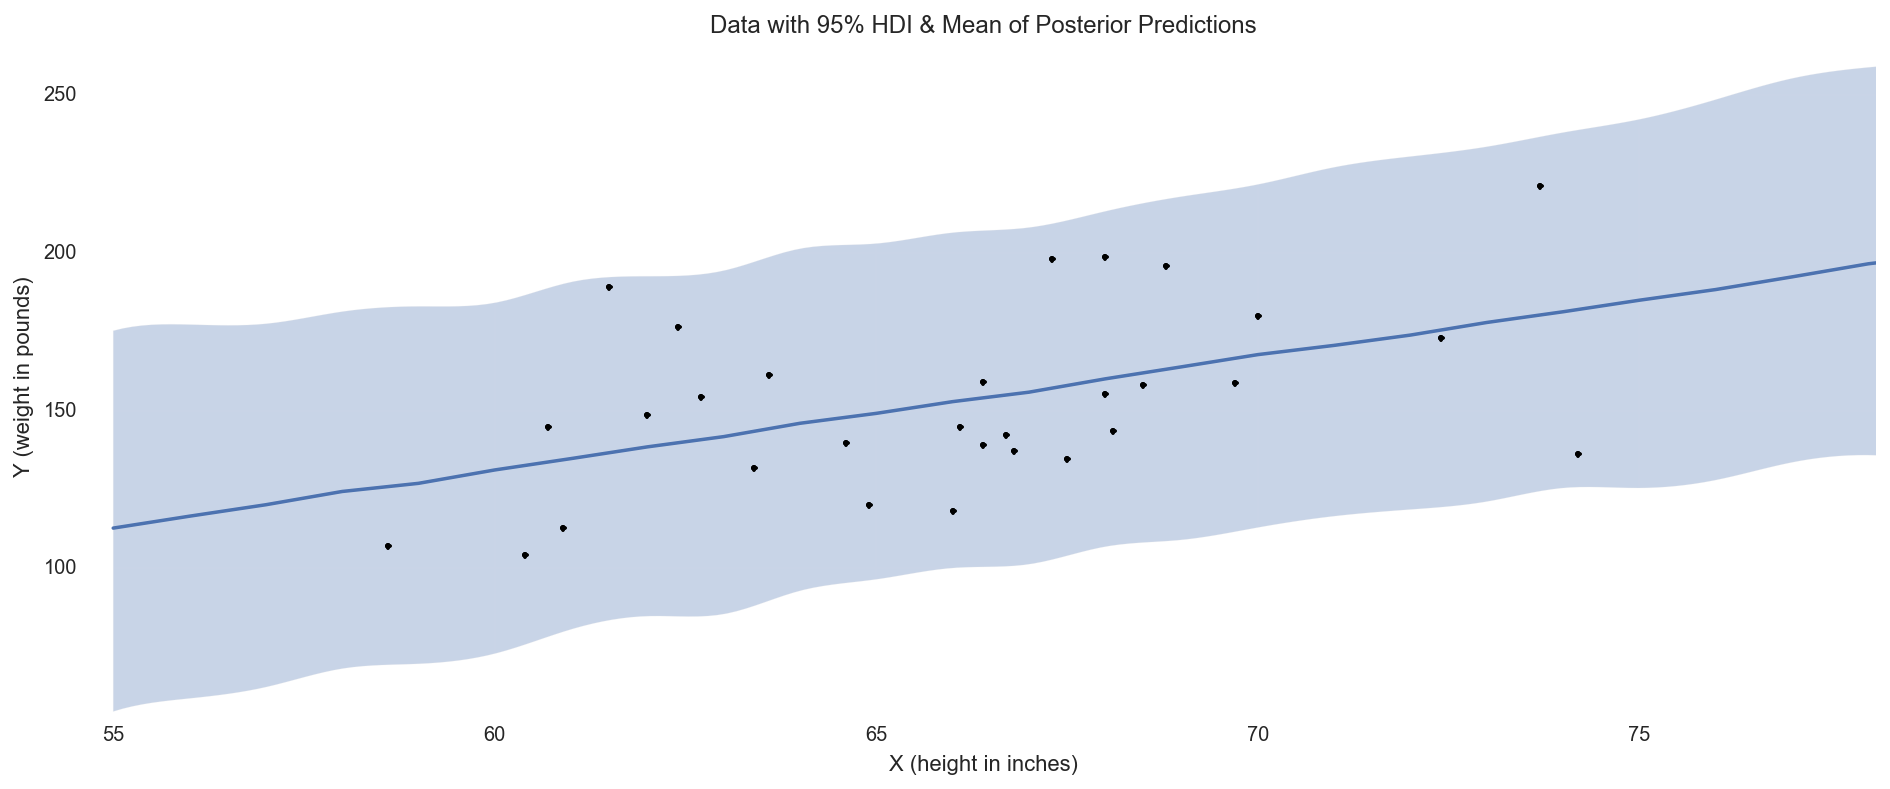

In [55]:
"""
16_SimpleLinearRegressionPyMC.py
Estimating the mean and standard deviation of a Gaussian likelihood with a
hierarchical model.
"""

# THE DATA.
# Simulated height and weight data:
n_subj = 30
HtWtData = HtWtDataGenerator(n_subj, rndsd=5678)
x = HtWtData[:,1]
y = HtWtData[:,2]

# Re-center data at mean, to reduce autocorrelation in MCMC sampling.
# Standardize (divide by SD) to make initialization easier.
x_m = np.mean(x)
x_sd = np.std(x)
y_m = np.mean(y)
y_sd = np.std(y)
zx = (x - x_m) / x_sd
zy = (y - y_m) / y_sd


# THE MODEL
with pm.Model() as model:
    # define the priors
    tau = pm.Gamma('tau', 0.001, 0.001)
    beta0 = pm.Normal('beta0', mu=0, tau=1.0E-12)
    beta1 = pm.Normal('beta1', mu=0, tau=1.0E-12)
    mu = beta0 + beta1 * zx
    # define the likelihood
    yl = pm.Normal('yl', mu=mu, tau=tau, observed=zy)
    # Generate a MCMC chain
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start, progressbar=False)


# EXAMINE THE RESULTS
burnin = 5000
thin = 10

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace[burnin::thin], vars =[tau])
#pm.autocorrplot(trace, vars =[tau])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)

## Extract chain values:
z0 = trace['beta0']
z1 = trace['beta1']
z_tau = trace['tau']
z_sigma = 1 / np.sqrt(z_tau) # Convert precision to SD


# Convert to original scale:
b1 = z1 * y_sd / x_sd
b0 = (z0 * y_sd + y_m - z1 * y_sd * x_m / x_sd)
sigma = z_sigma * y_sd


# Posterior prediction:
# Specify x values for which predicted y's are needed:
x_post_pred = np.arange(55, 81)
# Define matrix for recording posterior predicted y values at each x value.
# One row per x value, with each row holding random predicted y values.
post_samp_size = len(b1)
y_post_pred = np.zeros((len(x_post_pred), post_samp_size))
# Define matrix for recording HDI limits of posterior predicted y values:
y_HDI_lim = np.zeros((len(x_post_pred), 2))
# Generate posterior predicted y values.
# This gets only one y value, at each x, for each step in the chain.
for chain_idx in range(post_samp_size):
    y_post_pred[:,chain_idx] = norm.rvs(loc=b0[chain_idx] + b1[chain_idx] * x_post_pred ,
                           scale = np.repeat([sigma[chain_idx]], [len(x_post_pred)]), size=len(x_post_pred))

for x_idx in range(len(x_post_pred)):
    y_HDI_lim[x_idx] = hpd(y_post_pred[x_idx])

## Display believable beta0 and b1 values
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
thin_idx = 50
plt.plot(z1[::thin_idx], z0[::thin_idx], 'b.', alpha=0.7)
plt.ylabel('Standardized Intercept')
plt.xlabel('Standardized Slope')
plt.subplot(1, 2, 2)
plt.plot(b1[::thin_idx], b0[::thin_idx], 'b.', alpha=0.7)
plt.ylabel('Intercept (ht when wt=0)')
plt.xlabel('Slope (pounds per inch)')
plt.tight_layout()

# Display the posterior of the b1:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_post(z1, xlab='Standardized slope', 
          comp_val=0.0, bins=30, show_mode=False)
plt.subplot(1, 2, 2)
plot_post(b1, xlab='Slope (pounds per inch)', 
          comp_val=0.0, bins=30, show_mode=False)
plt.tight_layout()

# Display data with believable regression lines and posterior predictions.
plt.figure(figsize=(16,6))
# Plot data values:
x_rang = np.max(x) - np.min(x)
y_rang = np.max(y) - np.min(y)
lim_mult = 0.25
x_lim = [np.min(x)-lim_mult*x_rang, np.max(x)+lim_mult*x_rang]
y_lim = [np.min(y)-lim_mult*y_rang, np.max(y)+lim_mult*y_rang]
plt.plot(x, y, 'k.')
plt.title('Data with credible regression lines')
plt.xlabel('X (height in inches)')
plt.ylabel('Y (weight in pounds)')
plt.xlim(x_lim)
plt.ylim(y_lim)
# Superimpose a smattering of believable regression lines:
for i in range(0, len(b0), 100):
    plt.plot(x, b0[i] + b1[i]*x  , c='k', alpha=0.05 )

# Display data with HDIs of posterior predictions.

plt.figure(figsize=(16,6))
# Plot data values:
y_lim = [np.min(y_HDI_lim), np.max(y_HDI_lim)]
plt.plot(x, y, 'k.')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('X (height in inches)')
plt.ylabel('Y (weight in pounds)')
plt.title('Data with 95% HDI & Mean of Posterior Predictions')
# Superimpose posterior predicted 95% HDIs:
y_post_pred_ave = np.average(y_post_pred, axis=1)
#Book version of the HDI representation
#plt.errorbar(x_post_pred,y_post_pred_ave, 
#             yerr=[abs(y_HDI_lim[:,0]-y_post_pred_ave),
#                   abs(y_HDI_lim[:,1]-y_post_pred_ave)], fmt='.')

#Smoothed version of the HDI representation
x_new = np.linspace(x_post_pred.min(), x_post_pred.max(), 200)
y_HDI_lim_smooth = spline(x_post_pred, y_HDI_lim, x_new)
plt.plot(x_post_pred, y_post_pred_ave)
plt.fill_between(x_new, y_HDI_lim_smooth[:,0], y_HDI_lim_smooth[:,1], alpha=0.3)

In [56]:
McIntyre1994 = """Brand,Tar,Nic,Wt,CO
Alpine,14.1,0.86,0.9853,13.6
BensonAndHedges,16.0,1.06,1.0938,16.6
BullDurham,29.8,2.03,1.1650,23.5
CamelLights,8.0,0.67,0.9280,10.2
Carlton,4.1,0.40,0.9462,5.4
Chesterfield,15.0,1.04,0.8885,15.0
GoldenLights,8.8,0.76,1.0267,9.0
Kent,12.4,0.95,0.9225,12.3
Kool,16.6,1.12,0.9372,16.3
LandM,14.9,1.02,0.8858,15.4
LarkLights,13.7,1.01,0.9643,13.0
Marlboro,15.1,0.90,0.9316,14.4
Merit,7.8,0.57,0.9705,10.0
MultiFilter,11.4,0.78,1.1240,10.2
NewportLights,9.0,0.74,0.8517,9.5
Now,1.0,0.13,0.7851,1.5
OldGold,17.0,1.26,0.9186,18.5
PallMallLight,12.8,1.08,1.0395,12.6
Raleigh,15.8,0.96,0.9573,17.5
SalemUltra,4.5,0.42,0.9106,4.9
Tareyton,14.5,1.01,1.0070,15.9
True,7.3,0.61,0.9806,8.5
ViceroyRichLight,8.6,0.69,0.9693,10.6
VirginiaSlims,15.2,1.02,0.9496,13.9
WinstonLights,12.0,0.82,1.1184,14.9
"""

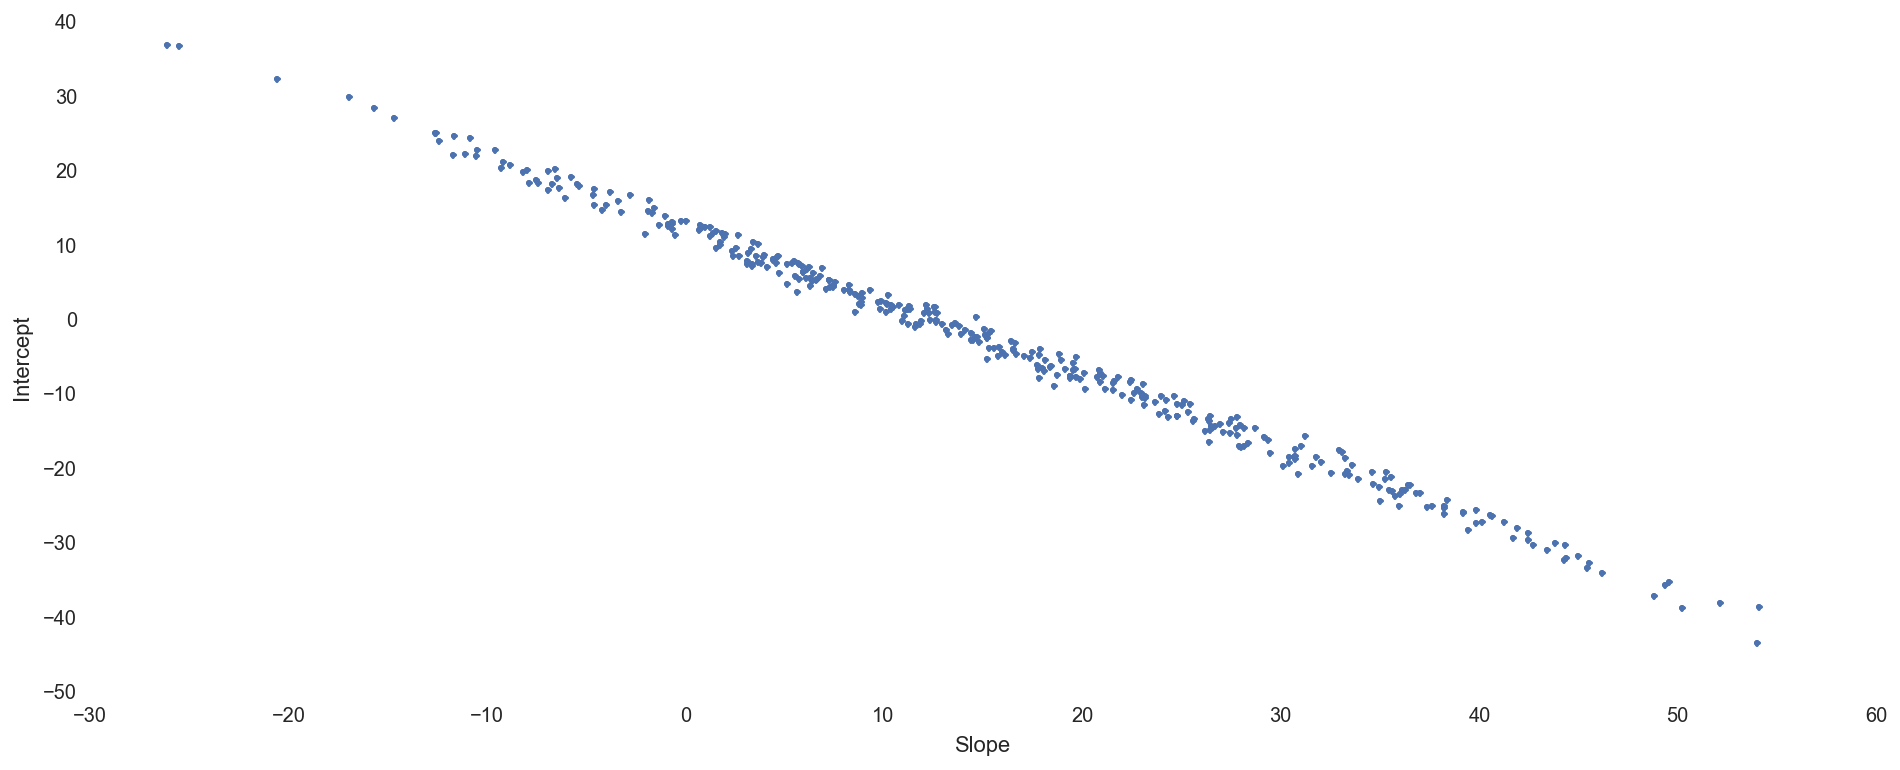

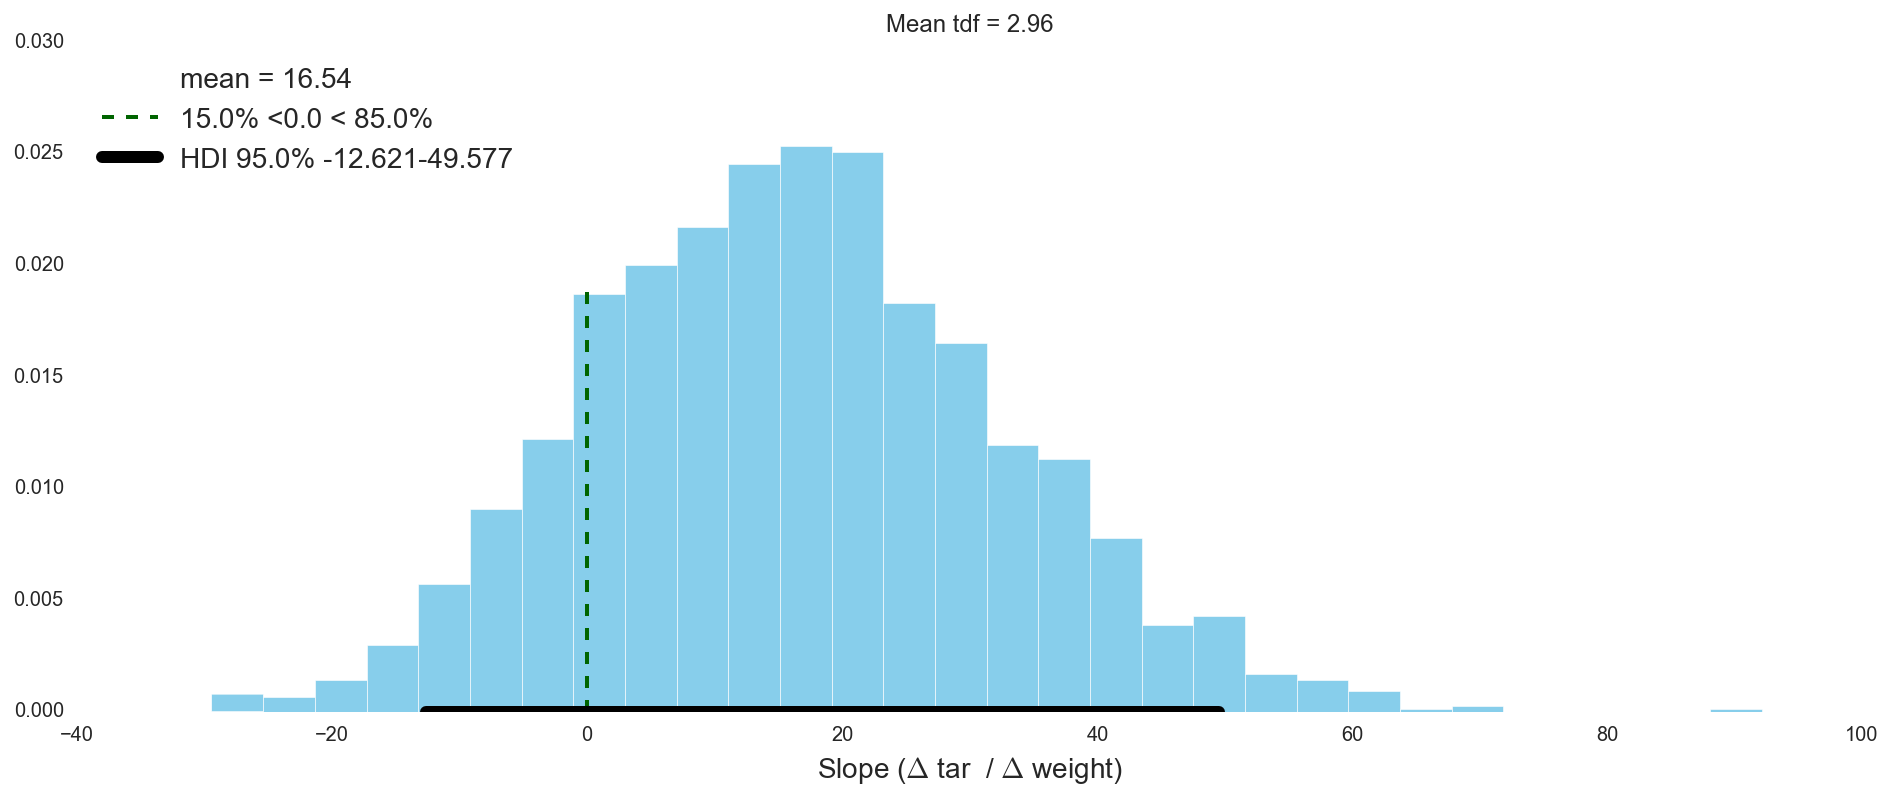

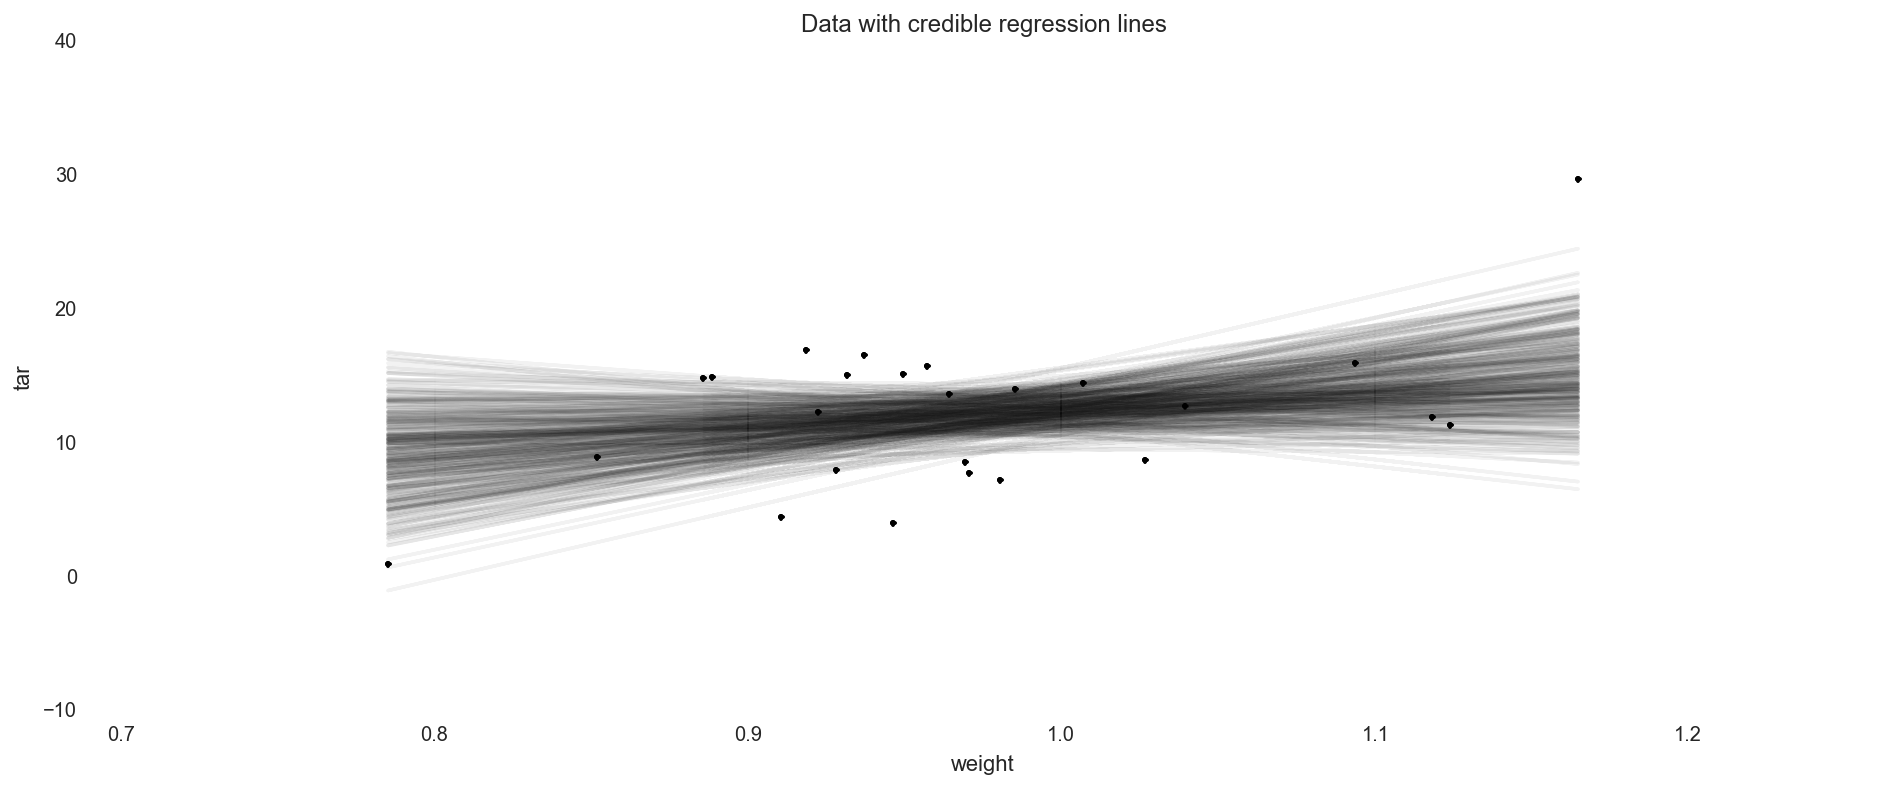

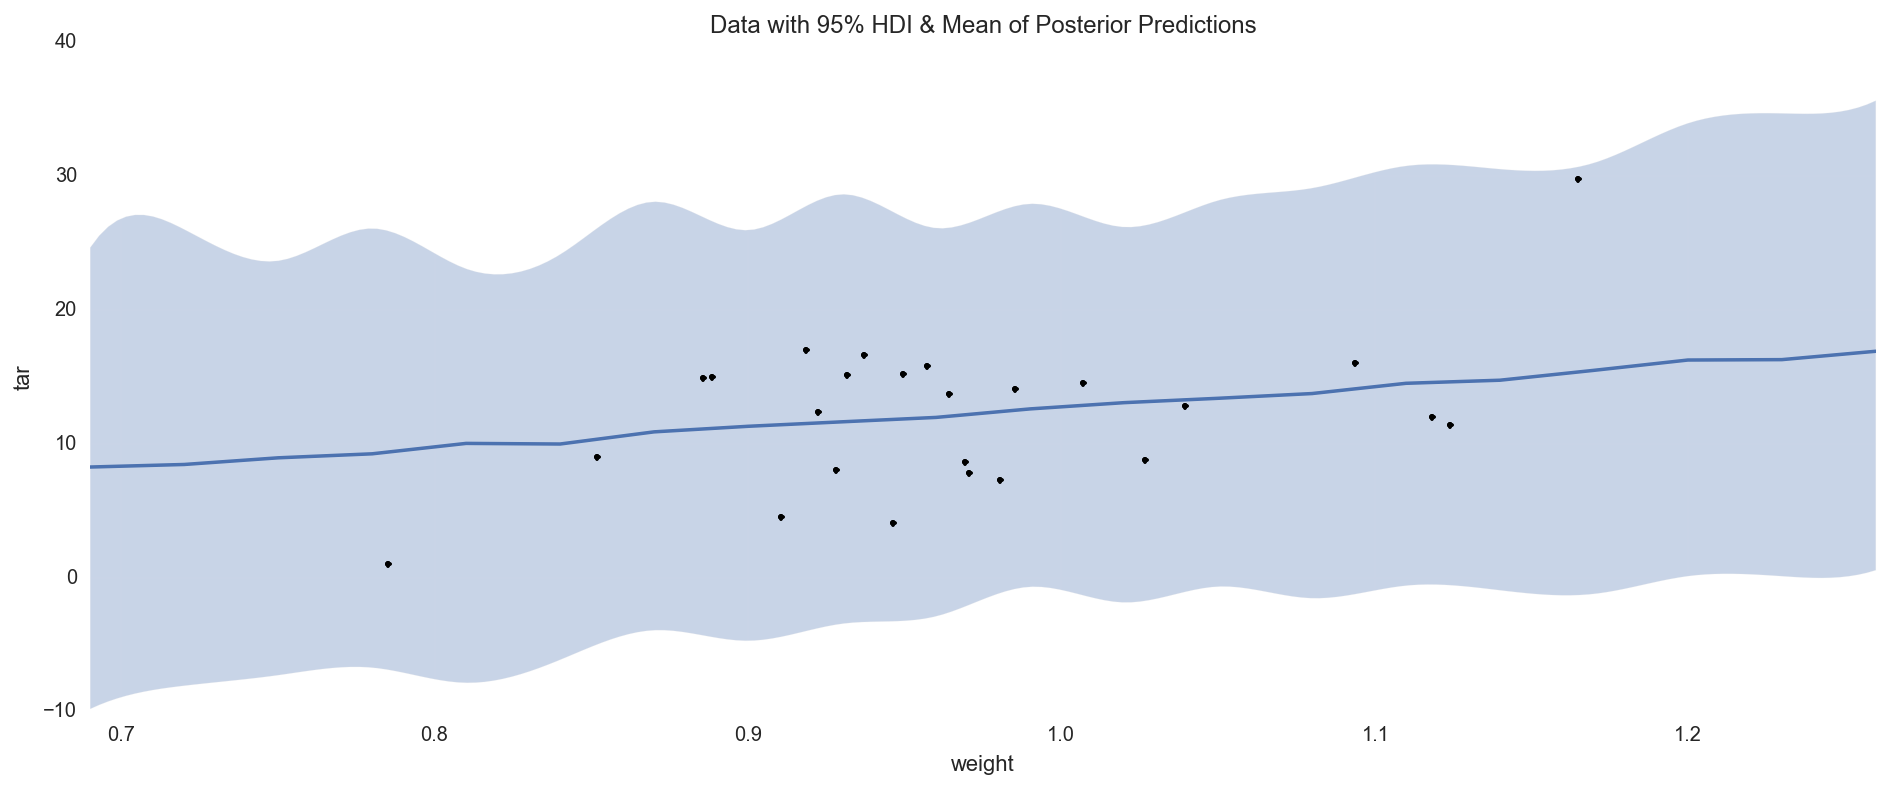

In [57]:
"""
16_SimpleRobustLinearRegressionPyMC.py
Simple Robust Linear Regression
"""
# THE DATA.

#cig_data = np.genfromtxt("McIntyre1994data.csv", skip_header=True, delimiter=",")
cig_data = np.genfromtxt(StringIO(McIntyre1994), skip_header=True, delimiter=",")

n_subj = len(cig_data)
x = cig_data[:,3]
y = cig_data[:,1]


# Re-center data at mean, to reduce autocorrelation in MCMC sampling.
# Standardize (divide by SD) to make initialization easier.
x_m = np.mean(x)
x_sd = np.std(x)
y_m = np.mean(y)
y_sd = np.std(y)
zx = (x - x_m) / x_sd
zy = (y - y_m) / y_sd

tdf_gain = 1 # 1 for low-baised tdf, 100 for high-biased tdf

# THE MODEL
with pm.Model() as model:
    # define the priors
    udf = pm.Uniform('udf', 0, 1)
    tdf = 1 - tdf_gain * pm.log(1 - udf) # tdf in [1,Inf).
    tau = pm.Gamma('tau', 0.001, 0.001)
    beta0 = pm.Normal('beta0', mu=0, tau=1.0E-12)
    beta1 = pm.Normal('beta1', mu=0, tau=1.0E-12)
    mu = beta0 + beta1 * zx
    # define the likelihood
    yl = pm.T('yl', mu=mu, lam=tau, nu=tdf, observed=zy)
    # Generate a MCMC chain
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(20000, step, start, progressbar=False)


# EXAMINE THE RESULTS
burnin = 1000
thin = 10

## Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

## Check for mixing and autocorrelation
#pm.autocorrplot(trace[burnin::thin], vars =[tau])
#pm.autocorrplot(trace, vars =[tau])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)


# Extract chain values:

tdf_samp = 1 - tdf_gain * np.log(1 - trace['udf'][burnin::thin])
tdf_m = np.mean(tdf_samp)
z0 = trace["beta0"][burnin::thin]
z1 = trace["beta1"][burnin::thin]
z_tau = trace["tau"][burnin::thin]
z_sigma = 1 / np.sqrt(z_tau) # Convert precision to SD

# Convert to original scale:
b1 = z1 * y_sd / x_sd
b0 = (z0 * y_sd + y_m - z1 * y_sd * x_m / x_sd)
sigma = z_sigma * y_sd

# Posterior prediction:
# Specify x values for which predicted y's are needed:
x_rang = np.max(x) - np.min(x)
y_rang = np.max(y) - np.min(y)
lim_mult = 0.25
x_lim = [np.min(x) - lim_mult * x_rang, np.max(x) + lim_mult * x_rang]
#y_lim = [np.min(y) - lim_mult*y_rang, np.max(y) + lim_mult*y_rang]
y_lim = [-10, 40]
x_post_pred = np.linspace(x_lim[0], x_lim[1], 20)
# Define matrix for recording posterior predicted y values at each x value.
# One row per x value, with each row holding random predicted y values.
post_samp_size = len(b1)
y_post_pred = np.zeros((len(x_post_pred), post_samp_size))
# Define matrix for recording HDI limits of posterior predicted y values:
y_HDI_lim = np.zeros((len(x_post_pred), 2))
# Generate posterior predicted y values.
# This gets only one y value, at each x, for each step in the chain.
for chain_idx in range(post_samp_size):
    y_post_pred[:,chain_idx] = stats_t.rvs(df=np.repeat([tdf_samp[chain_idx]], [len(x_post_pred)]),
                            loc = b0[chain_idx] + b1[chain_idx] * x_post_pred,
                            scale = np.repeat([sigma[chain_idx]], [len(x_post_pred)]))

for x_idx in range(len(x_post_pred)):
    y_HDI_lim[x_idx] = hpd(y_post_pred[x_idx])


# Display believable beta0 and b1 values
plt.figure(figsize=(16,6))
thin_idx = 5
plt.plot(b1[::thin_idx], b0[::thin_idx], '.')
plt.ylabel("Intercept")
plt.xlabel("Slope")

# Display the posterior of the b1:
plt.figure(figsize=(16,6))
plot_post(b1, xlab=r'Slope ($\Delta$ tar  / $\Delta$ weight)', comp_val=0.0,
            show_mode=False, bins=30)
plt.title('Mean tdf = %.2f' % tdf_m)

# Display data with believable regression lines and posterior predictions.
plt.figure(figsize=(16,6))
plt.plot(x, y, 'k.')
plt.title('Data with credible regression lines')
plt.xlabel('weight')
plt.ylabel('tar')
plt.xlim(x_lim)
plt.ylim(y_lim)
# Superimpose a smattering of believable regression lines:
for i in range(0, len(b0), 5):
    plt.plot(x, b0[i] + b1[i]*x  , c='k', alpha=0.05 )


plt.figure(figsize=(16,6))
# Plot data values:
plt.plot(x, y, 'k.')
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('weight')
plt.ylabel('tar')
plt.title('Data with 95% HDI & Mean of Posterior Predictions')
# Superimpose posterior predicted 95% HDIs:
y_post_pred_med = np.median(y_post_pred, axis=1)

#Book version of the HDI representation
#plt.errorbar(x_post_pred, y_post_pred_med, 
#             yerr=[abs(y_HDI_lim[:,0]-y_post_pred_med),
#                   abs(y_HDI_lim[:,1]-y_post_pred_med)], fmt='.')

#Smoothed version of the HDI representation
x_new = np.linspace(x_post_pred.min(), x_post_pred.max(), 200)
y_HDI_lim_smooth = spline(x_post_pred, y_HDI_lim, x_new)
plt.plot(x_post_pred, y_post_pred_med)
plt.fill_between(x_new, y_HDI_lim_smooth[:,0], y_HDI_lim_smooth[:,1], alpha=0.3)

In [58]:
Guber1999 = """"Alabama"        4.405 17.2 31.144  8 491 538 1029
"Alaska"         8.963 17.6 47.951 47 445 489  934
"Arizona"        4.778 19.3 32.175 27 448 496  944
"Arkansas"       4.459 17.1 28.934  6 482 523 1005
"California"     4.992 24.0 41.078 45 417 485  902
"Colorado"       5.443 18.4 34.571 29 462 518  980
"Connecticut"    8.817 14.4 50.045 81 431 477  908
"Delaware"       7.030 16.6 39.076 68 429 468  897
"Florida"        5.718 19.1 32.588 48 420 469  889
"Georgia"        5.193 16.3 32.291 65 406 448  854
"Hawaii"         6.078 17.9 38.518 57 407 482  889
"Idaho"          4.210 19.1 29.783 15 468 511  979
"Illinois"       6.136 17.3 39.431 13 488 560 1048
"Indiana"        5.826 17.5 36.785 58 415 467  882
"Iowa"           5.483 15.8 31.511  5 516 583 1099
"Kansas"         5.817 15.1 34.652  9 503 557 1060
"Kentucky"       5.217 17.0 32.257 11 477 522  999
"Louisiana"      4.761 16.8 26.461  9 486 535 1021
"Maine"          6.428 13.8 31.972 68 427 469  896
"Maryland"       7.245 17.0 40.661 64 430 479  909
"Massachusetts"  7.287 14.8 40.795 80 430 477  907
"Michigan"       6.994 20.1 41.895 11 484 549 1033
"Minnesota"      6.000 17.5 35.948  9 506 579 1085
"Mississippi"    4.080 17.5 26.818  4 496 540 1036
"Missouri"       5.383 15.5 31.189  9 495 550 1045
"Montana"        5.692 16.3 28.785 21 473 536 1009
"Nebraska"       5.935 14.5 30.922  9 494 556 1050
"Nevada"         5.160 18.7 34.836 30 434 483  917
"New Hampshire"  5.859 15.6 34.720 70 444 491  935
"New Jersey"     9.774 13.8 46.087 70 420 478  898
"New Mexico"     4.586 17.2 28.493 11 485 530 1015
"New York"       9.623 15.2 47.612 74 419 473  892
"North Carolina" 5.077 16.2 30.793 60 411 454  865
"North Dakota"   4.775 15.3 26.327  5 515 592 1107
"Ohio"           6.162 16.6 36.802 23 460 515  975
"Oklahoma"       4.845 15.5 28.172  9 491 536 1027
"Oregon"         6.436 19.9 38.555 51 448 499  947
"Pennsylvania"   7.109 17.1 44.510 70 419 461  880
"Rhode Island"   7.469 14.7 40.729 70 425 463  888
"South Carolina" 4.797 16.4 30.279 58 401 443  844
"South Dakota"   4.775 14.4 25.994  5 505 563 1068
"Tennessee"      4.388 18.6 32.477 12 497 543 1040
"Texas"          5.222 15.7 31.223 47 419 474  893
"Utah"           3.656 24.3 29.082  4 513 563 1076
"Vermont"        6.750 13.8 35.406 68 429 472  901
"Virginia"       5.327 14.6 33.987 65 428 468  896
"Washington"     5.906 20.2 36.151 48 443 494  937
"West Virginia"  6.107 14.8 31.944 17 448 484  932
"Wisconsin"      6.930 15.9 37.746  9 501 572 1073
"Wyoming"        6.160 14.9 31.285 10 476 525 1001
"""

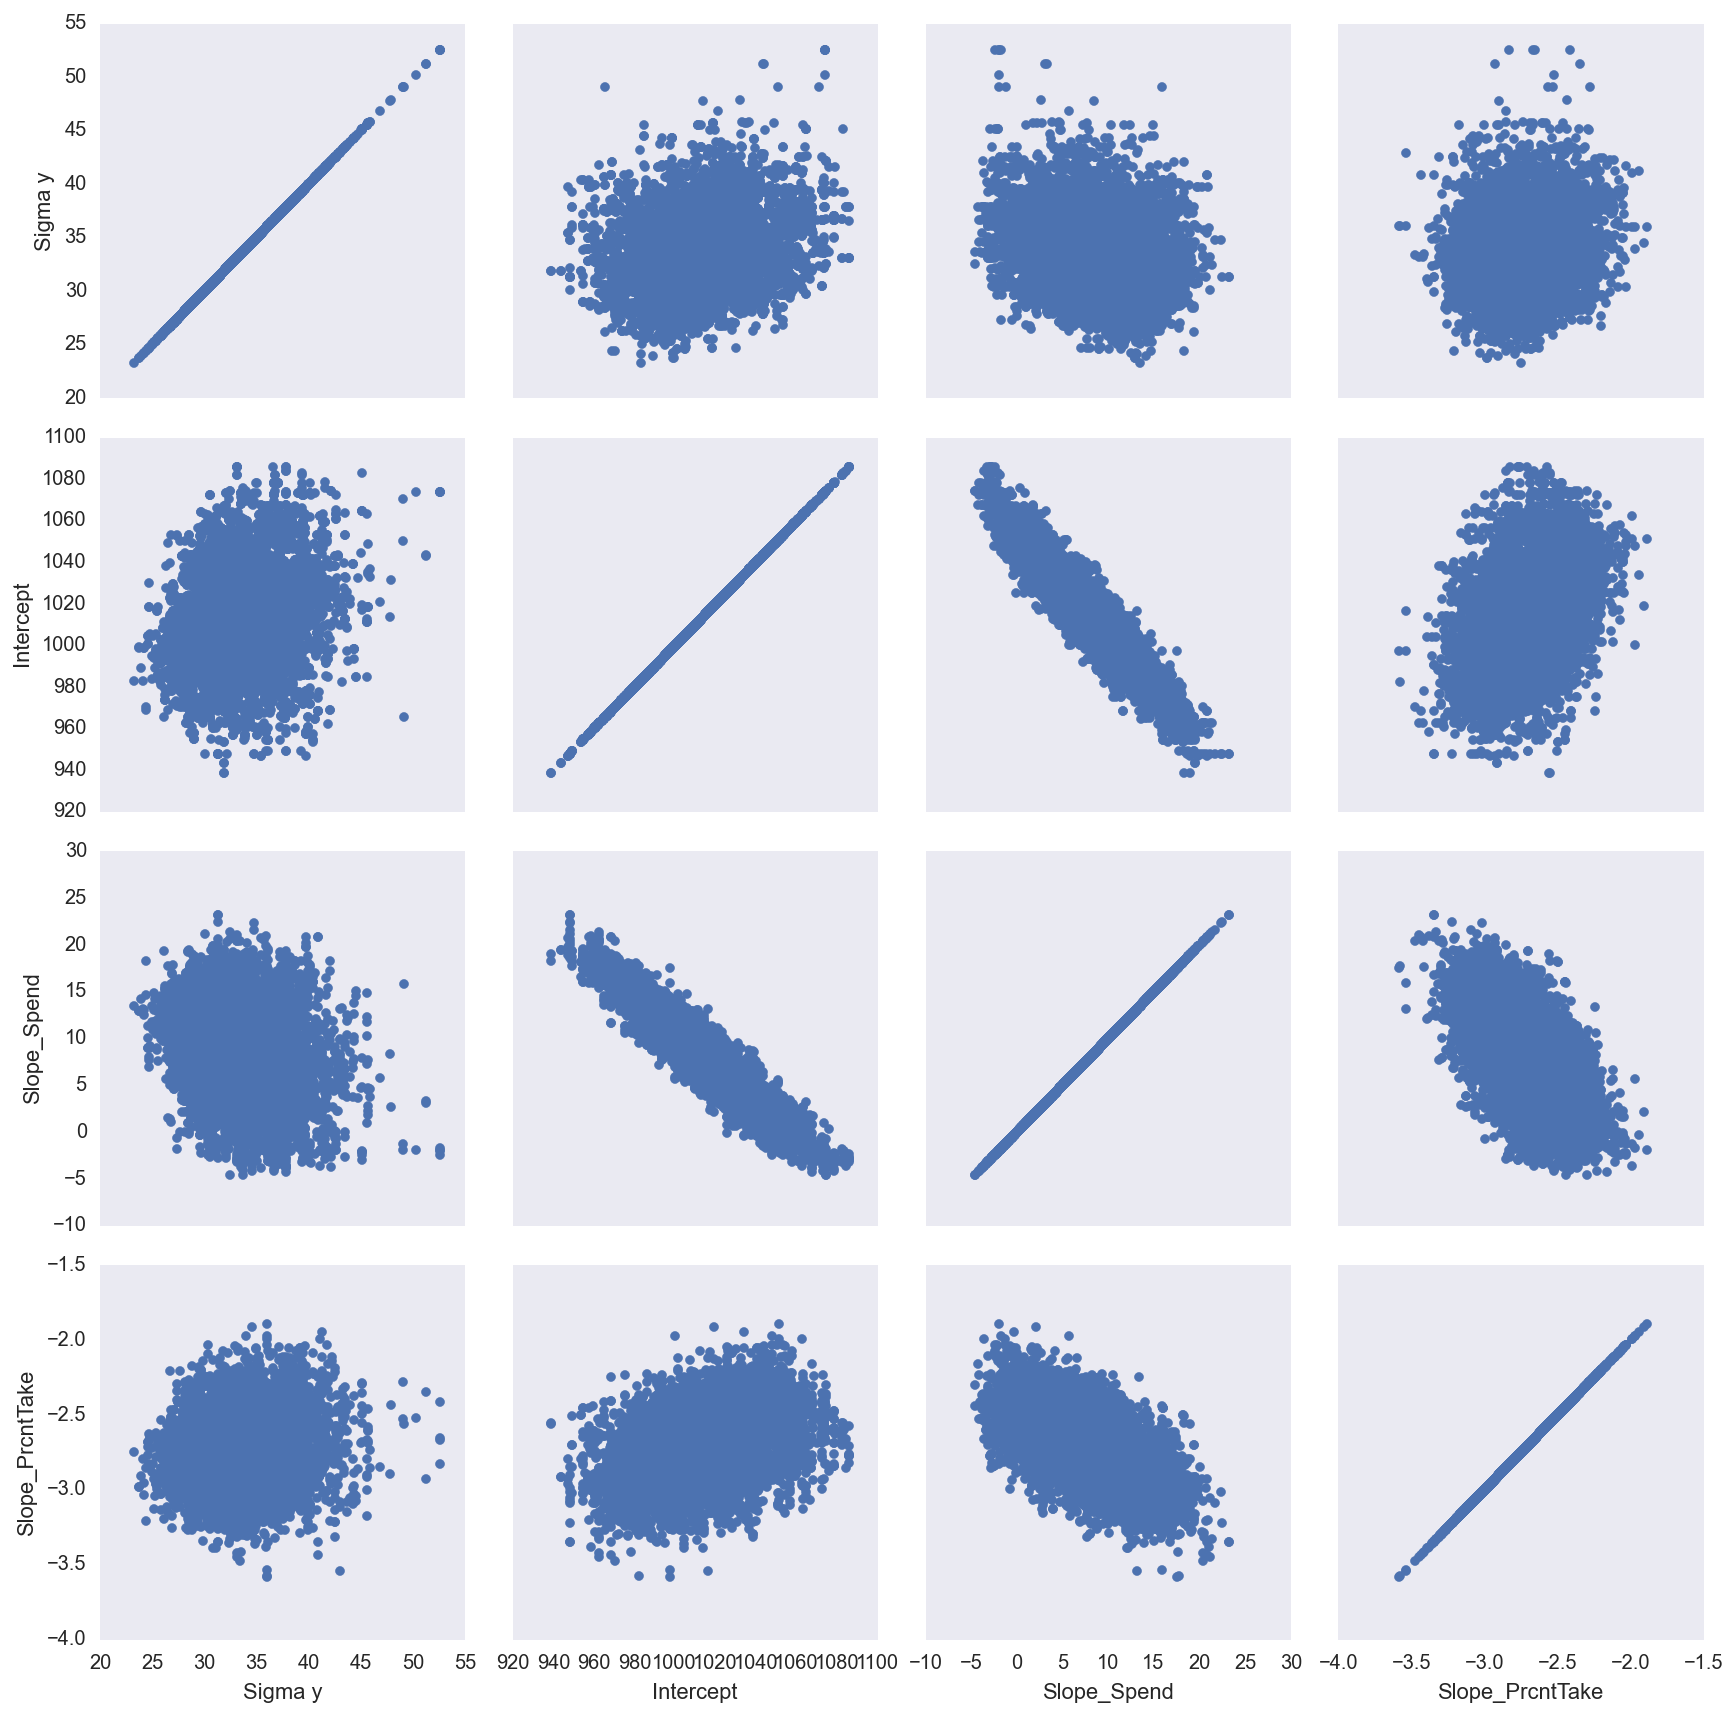

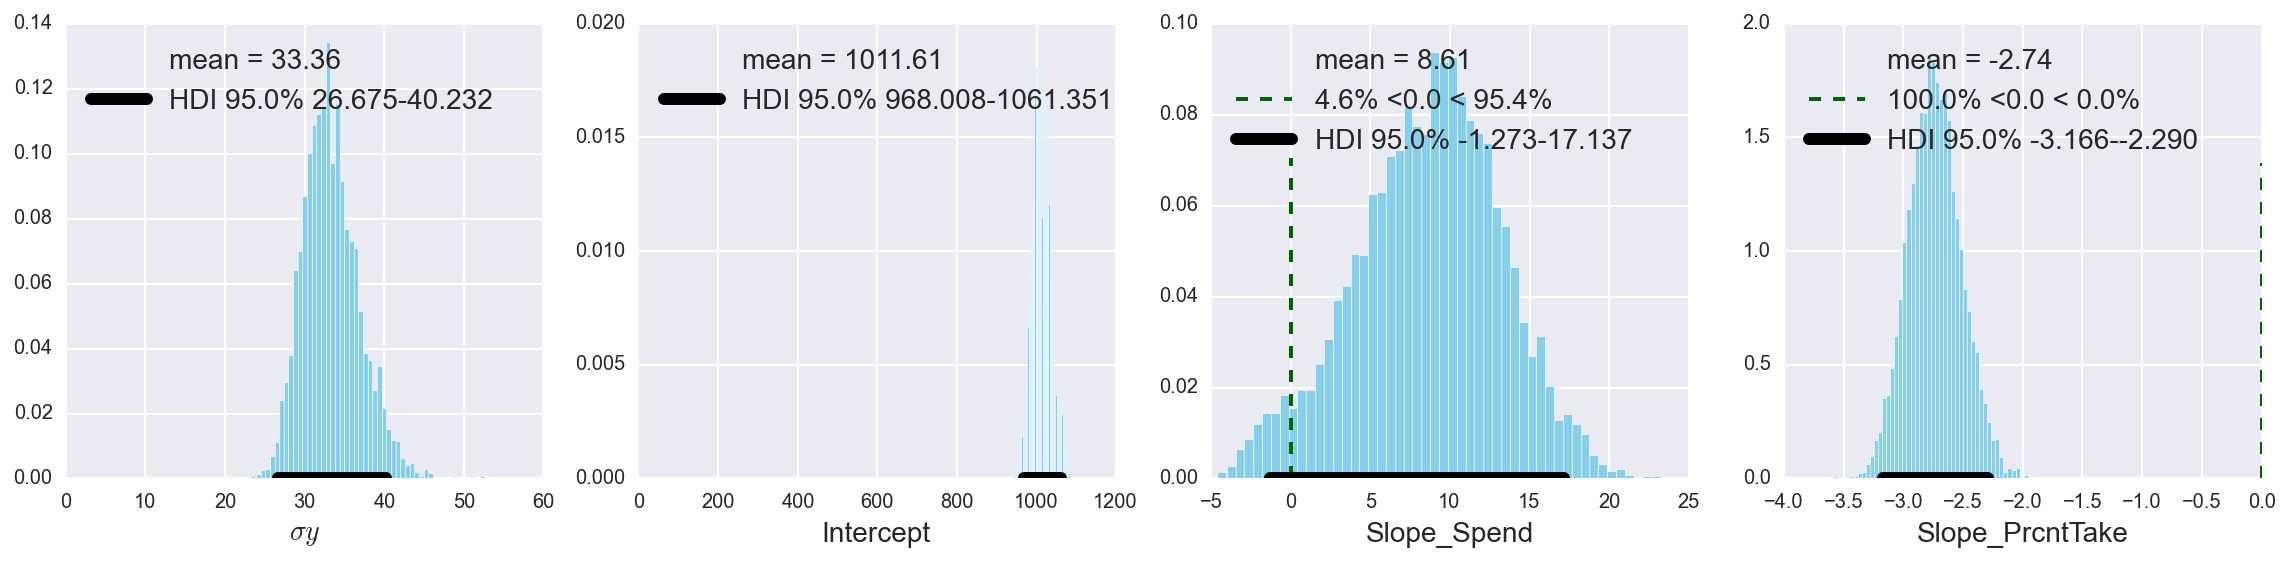

In [59]:
"""
17_MultiLinRegressHyperPyMC.py
Multiple linear regression with hyperpriors.
"""

# THE DATA.

tdfBgain = 1

dataSource = ["Guber1999", "McIntyre1994", "random"][0]


if dataSource == "Guber1999":
    fname = "Guber1999" # file name for saved graphs
    #data = pd.read_csv('Guber1999data.txt', sep='\s+', 
    data = pd.read_csv(StringIO(Guber1999), sep='\s+', 
    names = ["State","Spend","StuTchRat","Salary", "PrcntTake","SATV","SATM","SATT"])
    # Specify variables to be used in BUGS analysis:
    predicted_name = "SATT"
    predictor_names = ["Spend" , "PrcntTake"]
    n_data = len(data)
    y = data[predicted_name]
    x = data[predictor_names]
    n_predictors = len(x.columns)


if dataSource == "McIntyre1994":
    fname = "McIntyre1994" # file name for saved graphs
    data = pd.read_csv(StringIO(McIntyre1994))
    predicted_name = "CO"
    predictor_names = ["Tar","Nic","Wt"]
    n_data = len(data)
    y = data[predicted_name]
    x = data[predictor_names]
    n_data = len(data)


if dataSource == "random":
    fname = "Random"  # file name for saved graphs
    # Generate random data.
    # True parameter values:
    beta_true = np.repeat(0, 21)
    beta_true = np.insert(beta_true, [0,0,0], [100, 1, 2])  # beta0 is first component
    n_predictors = len(beta_true) - 1
    sd_true = 2
    tau_true = 1/sd_true**2
    # Random X values:
    np.random.seed(47405)
    xM = 5
    xSD = 2
    n_data = 100
    x = norm.rvs(xM, xSD, n_predictors*n_data).reshape(100, -1)
    x = pd.DataFrame(x, columns=['X%s' % i for i in range(0, n_predictors)])
    # Random Y values generated from linear model with true parameter values:
    y = np.sum(x * beta_true[1:].T, axis=1) + beta_true[0] + norm.rvs(0, sd_true, n_data)
   # Select which predictors to include
    include_only = range(0, n_predictors) # default is to include all
    #x = x.iloc[include_only]
    predictor_names = x.columns
    n_predictors = len(predictor_names)


# THE MODEL
with pm.Model() as model:
    # define hyperpriors
    muB = pm.Normal('muB', 0,.100 )
    tauB = pm.Gamma('tauB', .01, .01)
    udfB = pm.Uniform('udfB', 0, 1)
    tdfB = 1 + tdfBgain * (-pm.log(1 - udfB))
    # define the priors
    tau = pm.Gamma('tau', 0.01, 0.01)
    beta0 = pm.Normal('beta0', mu=0, tau=1.0E-12)
    beta1 = pm.T('beta1', mu=muB, lam=tauB, nu=tdfB, shape=n_predictors)
    mu = beta0 + pm.dot(beta1, x.values.T)
    # define the likelihood
    #mu = beta0 + beta1[0] * x.values[:,0] + beta1[1] * x.values[:,1]
    yl = pm.Normal('yl', mu=mu, tau=tau, observed=y)
    # Generate a MCMC chain
    start = pm.find_MAP()
    step1 = pm.NUTS([beta1])
    step2 = pm.Metropolis([beta0, tau, muB, tauB, udfB])
    trace = pm.sample(10000, [step1, step2], start, progressbar=False)


# EXAMINE THE RESULTS
burnin = 2000
thin = 1

# Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

# Check for mixing and autocorrelation
#pm.autocorrplot(trace[burnin::thin], vars =[mu, tau])
#pm.autocorrplot(trace, vars =[beta0])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)


# Extract chain values:
b0_samp = trace['beta0'][burnin::thin]
b_samp = trace['beta1'][burnin::thin]
tau_samp = trace['tau'][burnin::thin]
sigma_samp = 1 / np.sqrt(tau_samp) # Convert precision to SD
chain_length = len(tau_samp)

if n_predictors >= 6: # don't display if too many predictors
    n_predictors == 6

columns = ['Sigma y', 'Intercept']
[columns.append('Slope_%s' % i) for i in predictor_names[:n_predictors]]
traces = np.array([sigma_samp, b0_samp, b_samp[:,0], b_samp[:,1]]).T
df = pd.DataFrame(traces, columns=columns)
sns.set_style('dark')
g = sns.PairGrid(df)
g.map(plt.scatter)

## Display the posterior:
sns.set_style('darkgrid')

plt.figure(figsize=(16,4))
plt.subplot(1, n_predictors+2, 1)
plot_post(sigma_samp, xlab=r'$\sigma y$', show_mode=False, framealpha=0.5)
plt.subplot(1, n_predictors+2, 2)
plot_post(b0_samp, xlab='Intercept', show_mode=False, framealpha=0.5)

for i in range(0, n_predictors):
    plt.subplot(1, n_predictors+2, 3+i)
    plot_post(b_samp[:,i], xlab='Slope_%s' % predictor_names[i],
              show_mode=False, framealpha=0.5, comp_val=0)
plt.tight_layout()

# Posterior prediction:
# Define matrix for recording posterior predicted y values for each xPostPred.
# One row per xPostPred value, with each row holding random predicted y values.
y_post_pred = np.zeros((len(x), chain_length))
# Define matrix for recording HDI limits of posterior predicted y values:
y_HDI_lim = np.zeros((len(x), 2))
# Generate posterior predicted y values.
# This gets only one y value, at each x, for each step in the chain.
#or chain_idx in range(chain_length):
for chain_idx in range(chain_length):
    y_post_pred[:,chain_idx] = norm.rvs(loc = b0_samp[chain_idx] + np.dot(b_samp[chain_idx], x.values.T), 
                                        scale = np.repeat([sigma_samp[chain_idx]], [len(x)]))

for x_idx in range(len(x)):
    y_HDI_lim[x_idx] = hpd(y_post_pred[x_idx])

#for i in range(len(x)):
#    print np.mean(y_post_pred, axis=1)[i], y_HDI_lim[i]

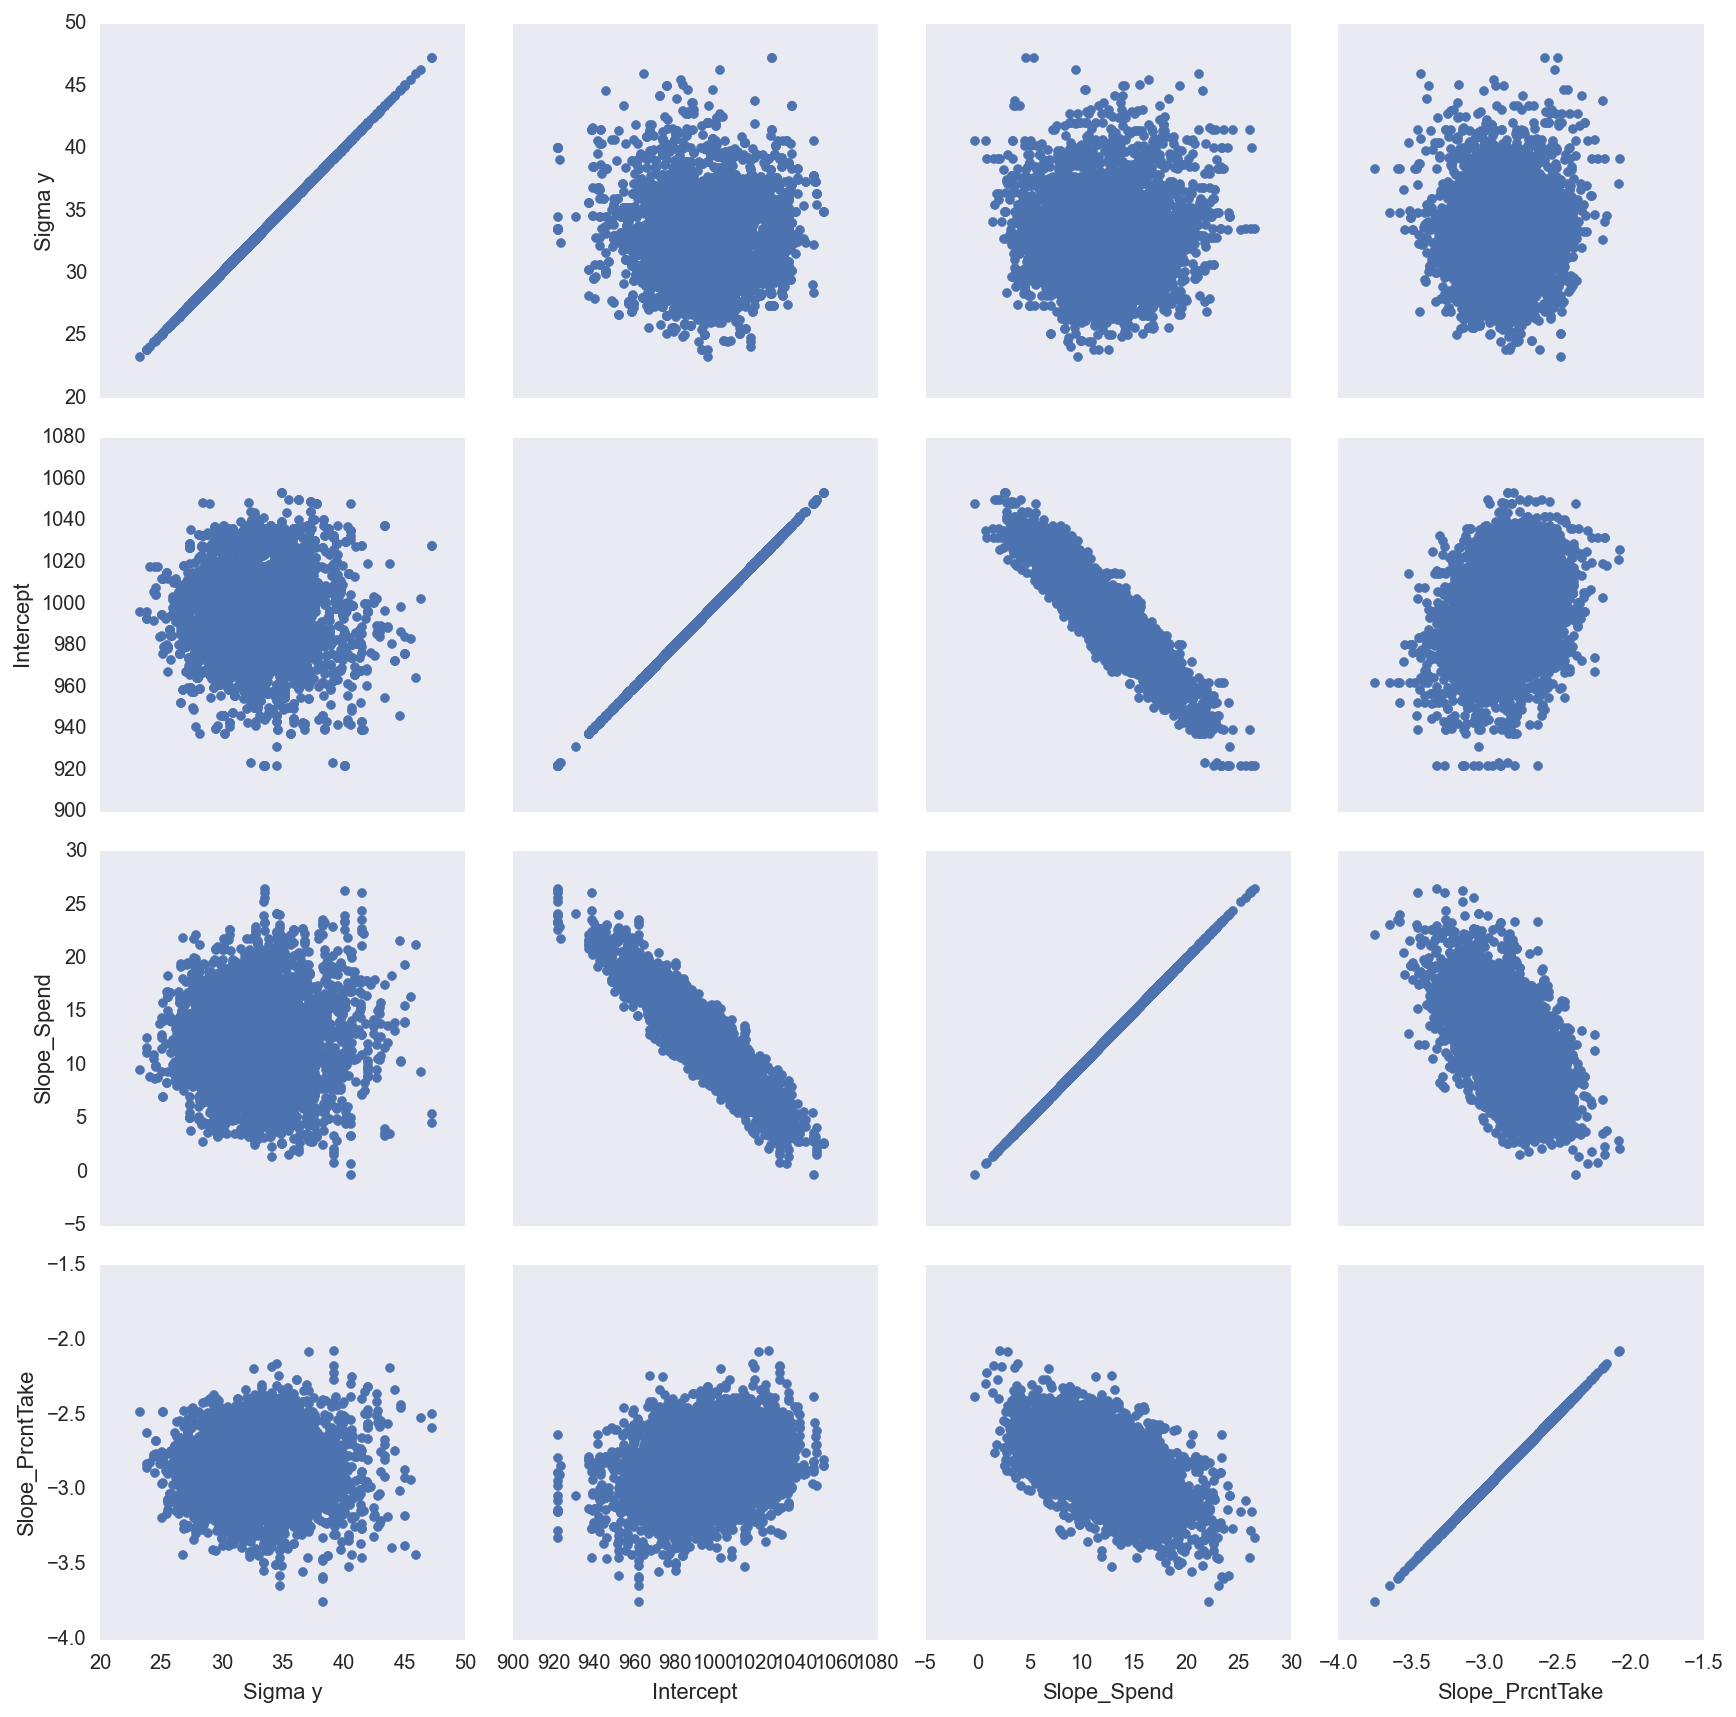

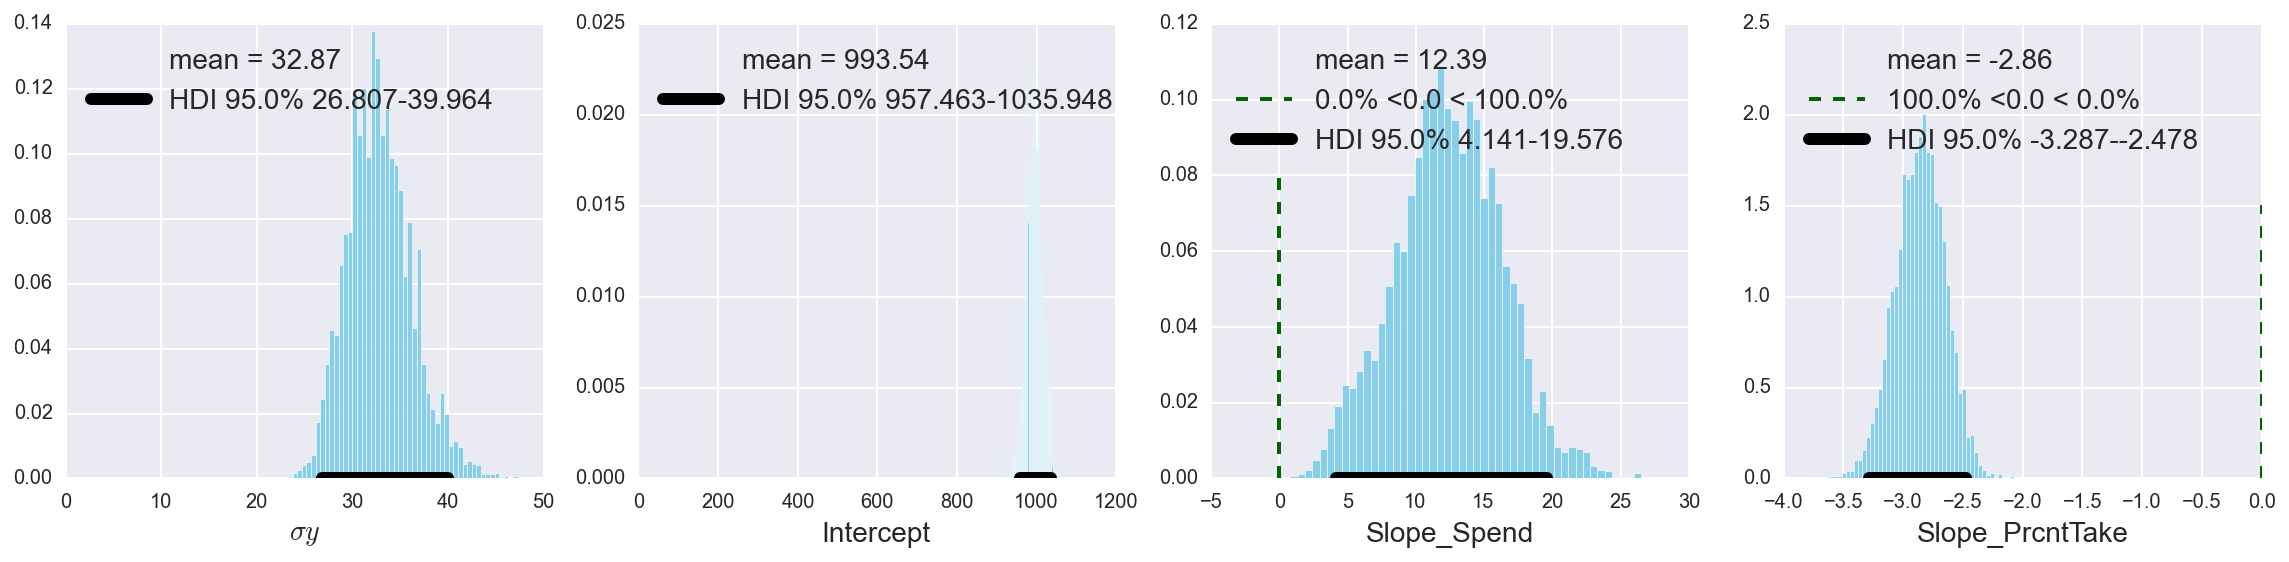

In [60]:
"""
17_MultipleLinearRegressionPyMC.py
Multiple linear regression
"""

# THE DATA.
dataSource = ["Guber1999", "McIntyre1994", "random"][0]

if dataSource == "Guber1999":
    fname = "Guber1999" # file name for saved graphs
    data = pd.read_csv(StringIO(Guber1999), sep='\s+', 
                       names = ["State","Spend","StuTchRat","Salary", "PrcntTake","SATV","SATM","SATT"])
    # Specify variables to be used in BUGS analysis:
    predictedName = "SATT"
    predictorNames = ["Spend" , "PrcntTake"]
    nData = len(data)
    y = data[predictedName]
    x = data[predictorNames]
    n_predictors = len(x.columns)


if dataSource == "McIntyre1994":
    fname = "McIntyre1994" # file name for saved graphs
    data = pd.read_csv(StringIO(McIntyre1994))
    predictedName = "CO"
    predictorNames = ["Tar","Nic","Wt"]
    nData = len(data)
    y = data[predictedName]
    x = data[predictorNames]
    nData = len(data)


if dataSource == "random":
    fname = "Random"  # file name for saved graphs
    # Generate random data.
    # True parameter values:
    beta_true = np.repeat(0, 21)
    beta_true = np.insert(beta_true, [0,0,0], [100, 1, 2])  # beta0 is first component
    n_predictors = len(beta_true) - 1
    sd_true = 2
    tau_true = 1/sd_true**2
    # Random X values:
    np.random.seed(47405)
    xM = 5
    xSD = 2
    nData = 100
    x = norm.rvs(xM, xSD, n_predictors*nData).reshape(100, -1)
    x = pd.DataFrame(x, columns=['X%s' % i for i in range(0, n_predictors)])
    # Random Y values generated from linear model with true parameter values:
    y = np.sum(x * beta_true[1:].T, axis=1) + beta_true[0] + norm.rvs(0, sd_true, nData)
    # Select which predictors to include
    includeOnly = range(0, n_predictors) # default is to include all
    #x = x.iloc[includeOnly]
    predictorNames = x.columns
    n_predictors = len(predictorNames)



# THE MODEL
with pm.Model() as model:
    # define the priors
    beta0 = pm.Normal('beta0', mu=0, tau=1.0E-12)
    beta1 = pm.Normal('beta1', mu= 0, tau=1.0E-12, shape=n_predictors)
    tau = pm.Gamma('tau', 0.01, 0.01)
    mu = beta0 + pm.dot(beta1, x.values.T)
    # define the likelihood
    yl = pm.Normal('yl', mu=mu, tau=tau, observed=y)
    # Generate a MCMC chain
    start = pm.find_MAP()
    step1 = pm.NUTS([beta1])
    step2 = pm.Metropolis([beta0, tau])
    trace = pm.sample(10000, [step1, step2], start, progressbar=False)

# EXAMINE THE RESULTS
burnin = 5000
thin = 1

# Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

# Check for mixing and autocorrelation
#pm.autocorrplot(trace[burnin::thin], vars =[mu, tau])
#pm.autocorrplot(trace, vars =[beta0])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
#pm.traceplot(trace)


# Extract chain values:
b0_samp = trace['beta0'][burnin::thin]
b_samp = trace['beta1'][burnin::thin]
Tau_samp = trace['tau'][burnin::thin]
Sigma_samp = 1 / np.sqrt(Tau_samp) # Convert precision to SD
chain_length = len(Tau_samp)

if n_predictors >= 6: # don't display if too many predictors
    n_predictors == 6

columns = ['Sigma y', 'Intercept']
[columns.append('Slope_%s' % i) for i in predictorNames[:n_predictors]]
traces = np.array([Sigma_samp, b0_samp, b_samp[:,0], b_samp[:,1]]).T
df = pd.DataFrame(traces, columns=columns)
sns.set_style('dark')
g = sns.PairGrid(df)
g.map(plt.scatter)

## Display the posterior:
sns.set_style('darkgrid')

plt.figure(figsize=(16,4))
plt.subplot(1, n_predictors+2, 1)
plot_post(Sigma_samp, xlab=r'$\sigma y$', show_mode=False, framealpha=0.5)
plt.subplot(1, n_predictors+2, 2)
plot_post(b0_samp, xlab='Intercept', show_mode=False, framealpha=0.5)

for i in range(0, n_predictors):
    plt.subplot(1, n_predictors+2, 3+i)
    plot_post(b_samp[:,i], xlab='Slope_%s' % predictorNames[i],
              show_mode=False, framealpha=0.5, comp_val=0)
plt.tight_layout()


# Posterior prediction:
# Define matrix for recording posterior predicted y values for each xPostPred.
# One row per xPostPred value, with each row holding random predicted y values.
y_post_pred = np.zeros((len(x), chain_length))
# Define matrix for recording HDI limits of posterior predicted y values:
y_HDI_lim = np.zeros((len(x), 2))
# Generate posterior predicted y values.
# This gets only one y value, at each x, for each step in the chain.
#or chain_idx in range(chain_length):
for chain_idx in range(chain_length):
    y_post_pred[:,chain_idx] = norm.rvs(loc = b0_samp[chain_idx] + np.dot(b_samp[chain_idx], x.values.T), 
                                        scale = np.repeat([Sigma_samp[chain_idx]], [len(x)]))

for x_idx in range(len(x)):
    y_HDI_lim[x_idx] = hpd(y_post_pred[x_idx])

#for i in range(len(x)):
#    print np.mean(y_post_pred, axis=1)[i], y_HDI_lim[i]

In [61]:
McDonaldSK1991="""Group Size Site
1 0.0571 OregonT                
1 0.0813 OregonT                 
1 0.0831 OregonT                 
1 0.0976 OregonT                 
1 0.0817 OregonT                 
1 0.0859 OregonT                 
1 0.0735 OregonT                 
1 0.0659 OregonT                 
1 0.0923 OregonT    
1 0.0836 OregonT     
2 0.0873 OregonN
2 0.0662 OregonN
2 0.0672 OregonN
2 0.0819 OregonN
2 0.0749 OregonN
2 0.0649 OregonN
2 0.0835 OregonN
2 0.0725 OregonN
3 0.0974 Alaska
3 0.1352 Alaska
3 0.0817 Alaska
3 0.1016 Alaska
3 0.0968 Alaska
3 0.1064 Alaska
3 0.1050 Alaska
4 0.1033 Russia
4 0.0915 Russia
4 0.0781 Russia
4 0.0685 Russia
4 0.0677 Russia
4 0.0697 Russia
4 0.0764 Russia
4 0.0689 Russia
5 0.0703 Finland
5 0.1026 Finland
5 0.0956 Finland
5 0.0973 Finland
5 0.1039 Finland
5 0.1045 Finland
"""

In [62]:
SolariLS2008="""Type Acid
1 7.12
1 7.16
1 4.57
1 3.79
1 4.20
1 5.84
1 5.56
1 5.02
1 3.69
1 2.99
1 4.99
1 2.16
2 4.42
2 5.68
2 5.15
2 3.83
2 3.30
2 4.44
2 3.51
2 4.60
2 4.85
2 4.84
2 5.45
2 4.71
3 6.49
3 8.09
3 8.79
3 8.44
3 6.11
3 5.17
3 8.13
3 7.58
3 6.47
3 5.45
3 6.18
3 4.34
4 8.07
4 2.86
4 6.84
4 6.85
4 4.12
4 3.32
4 1.74
4 1.74
4 1.57
4 3.02
4 5.08
4 4.96
5 8.05
5 5.82
5 2.47
5 3.28
5 5.38
5 3.98
5 6.08
5 6.28
5 5.72
5 2.88
5 6.40
5 4.58
6 5.09
6 4.57
6 6.06
6 4.87
6 4.52
6 5.08
6 4.29
6 6.19
6 3.45
6 5.85
6 2.51
6 4.93
7 5.87
7 5.36
7 5.85
7 6.27
7 5.96
7 4.95
7 5.85
7 4.70
7 1.53
7 3.88
7 2.88
7 2.07
8 6.57
8 5.08
8 5.95
8 7.51
8 3.79
8 4.33
8 3.70
8 5.21
8 4.48
8 5.17
8 4.69
8 2.12
9 4.13
9 7.31
9 4.47
9 2.53
9 3.96
9 5.30
9 2.66
9 4.12
9 3.54
9 2.98
9 5.08
9 5.15
"""

/Users/briann/anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


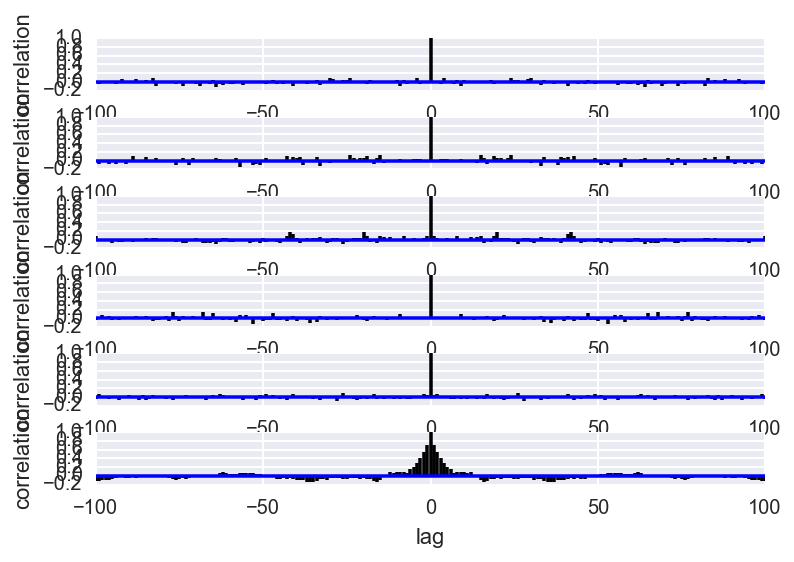

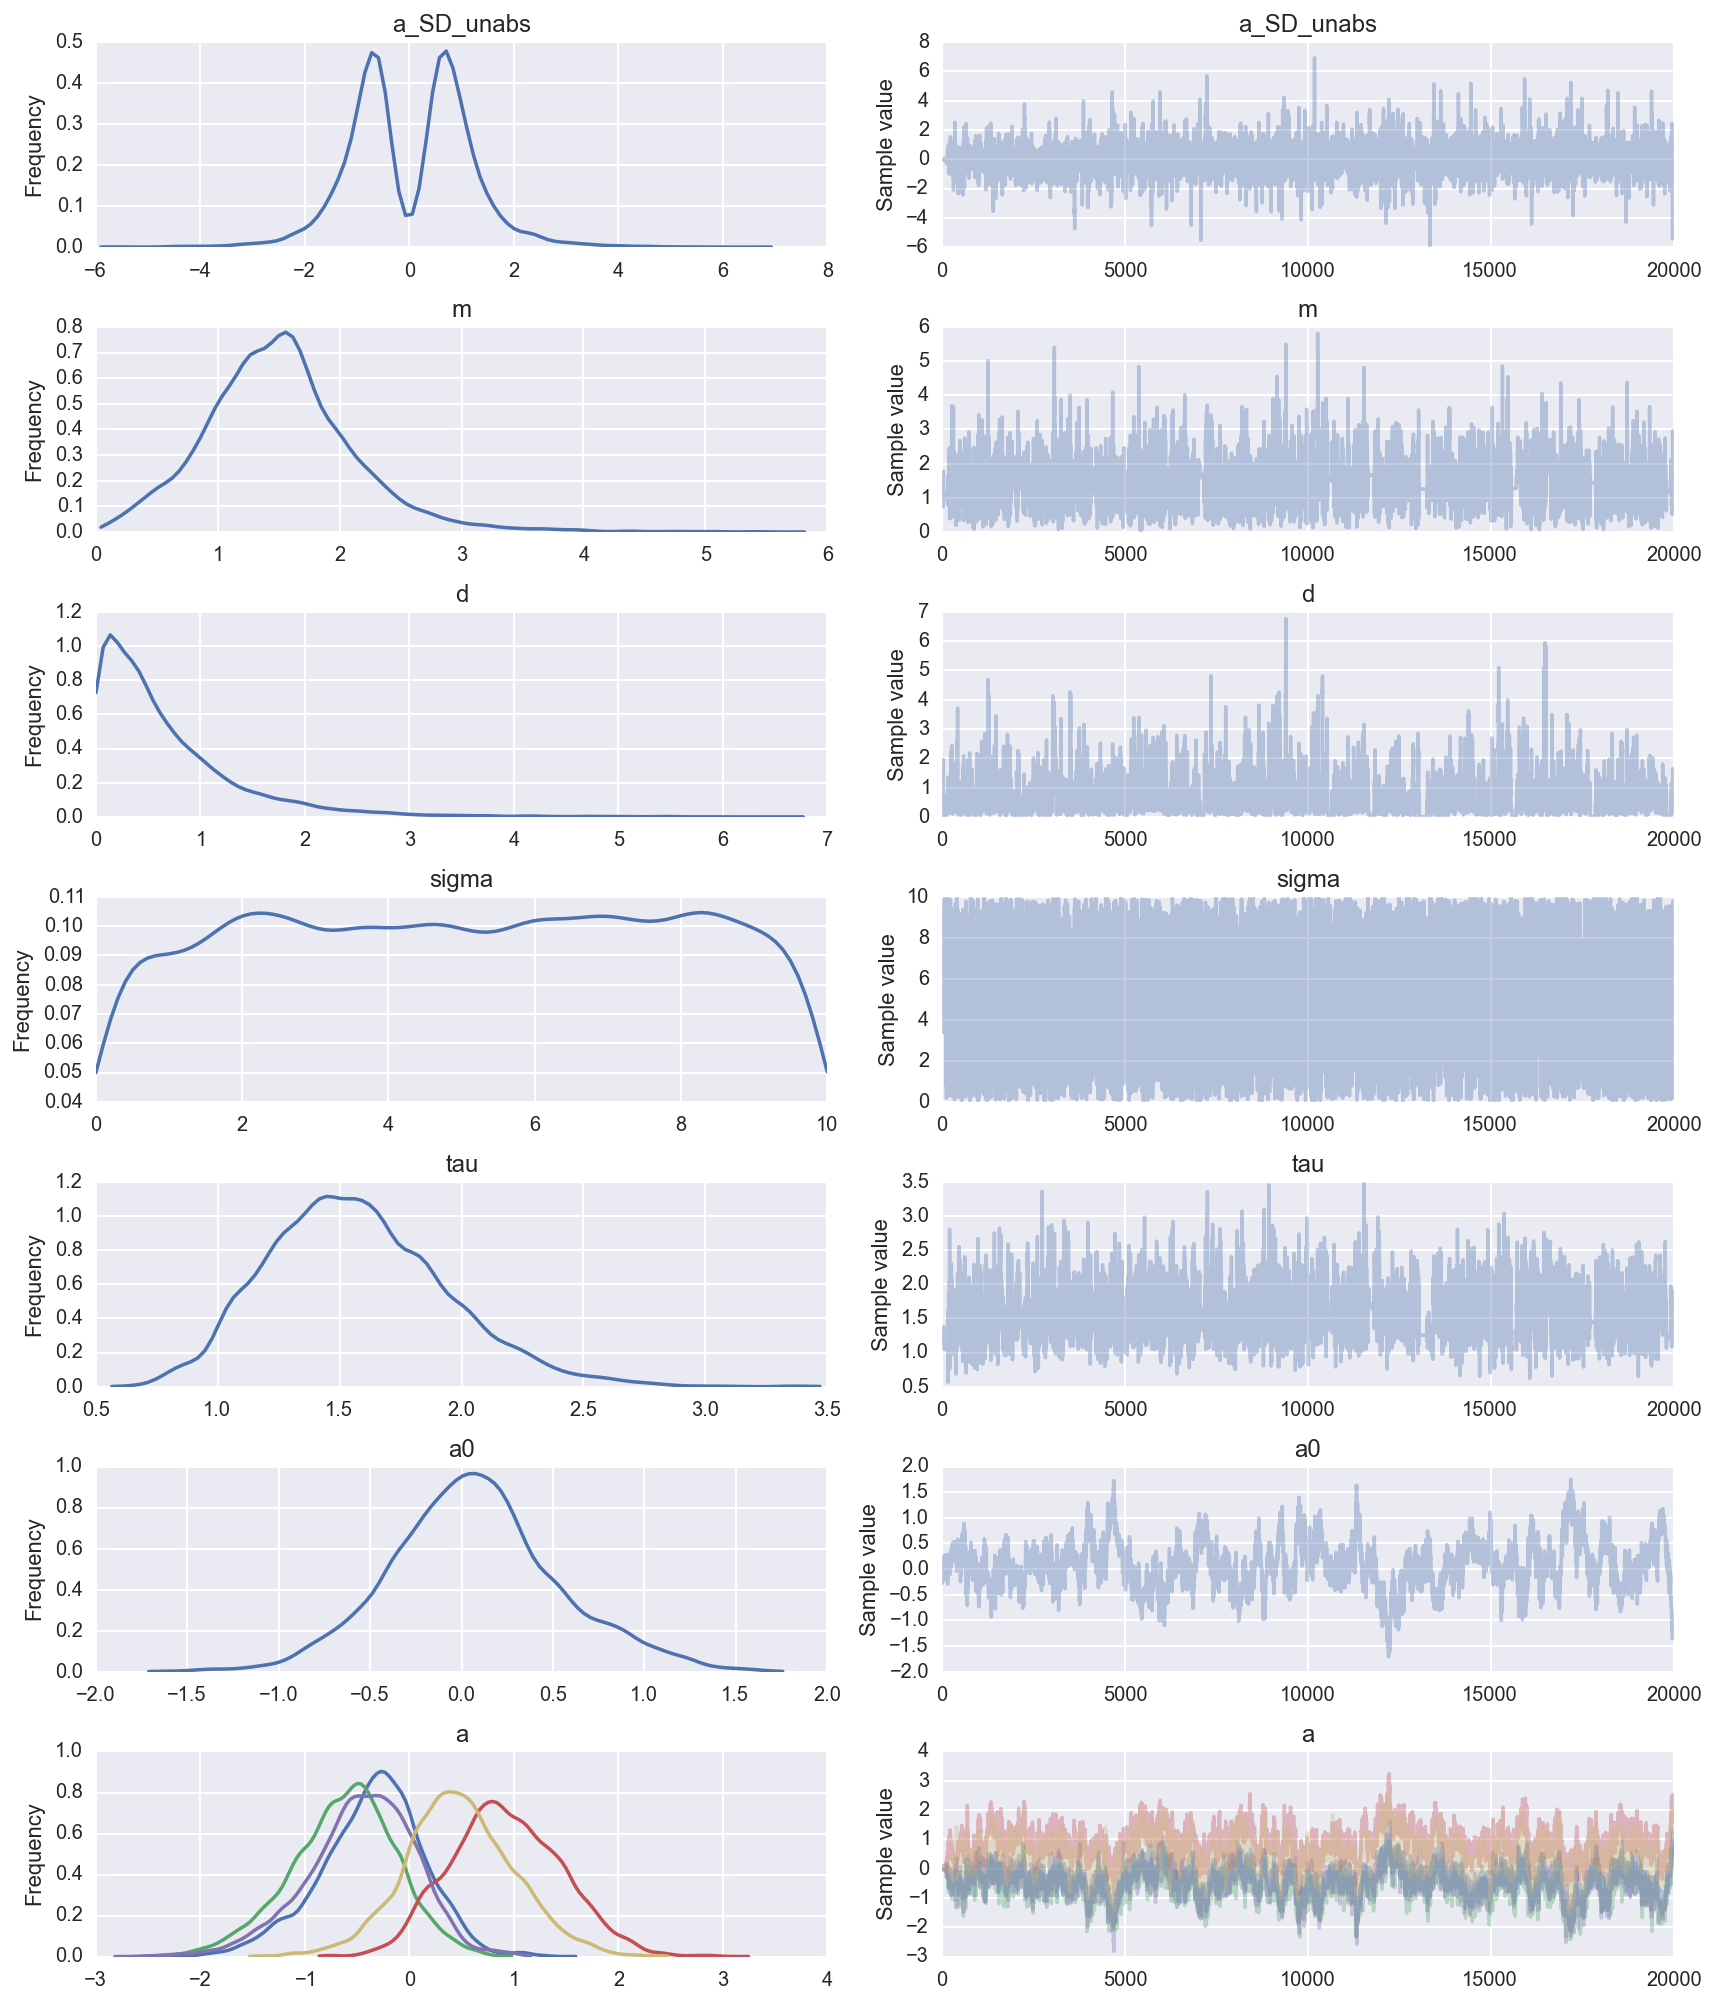

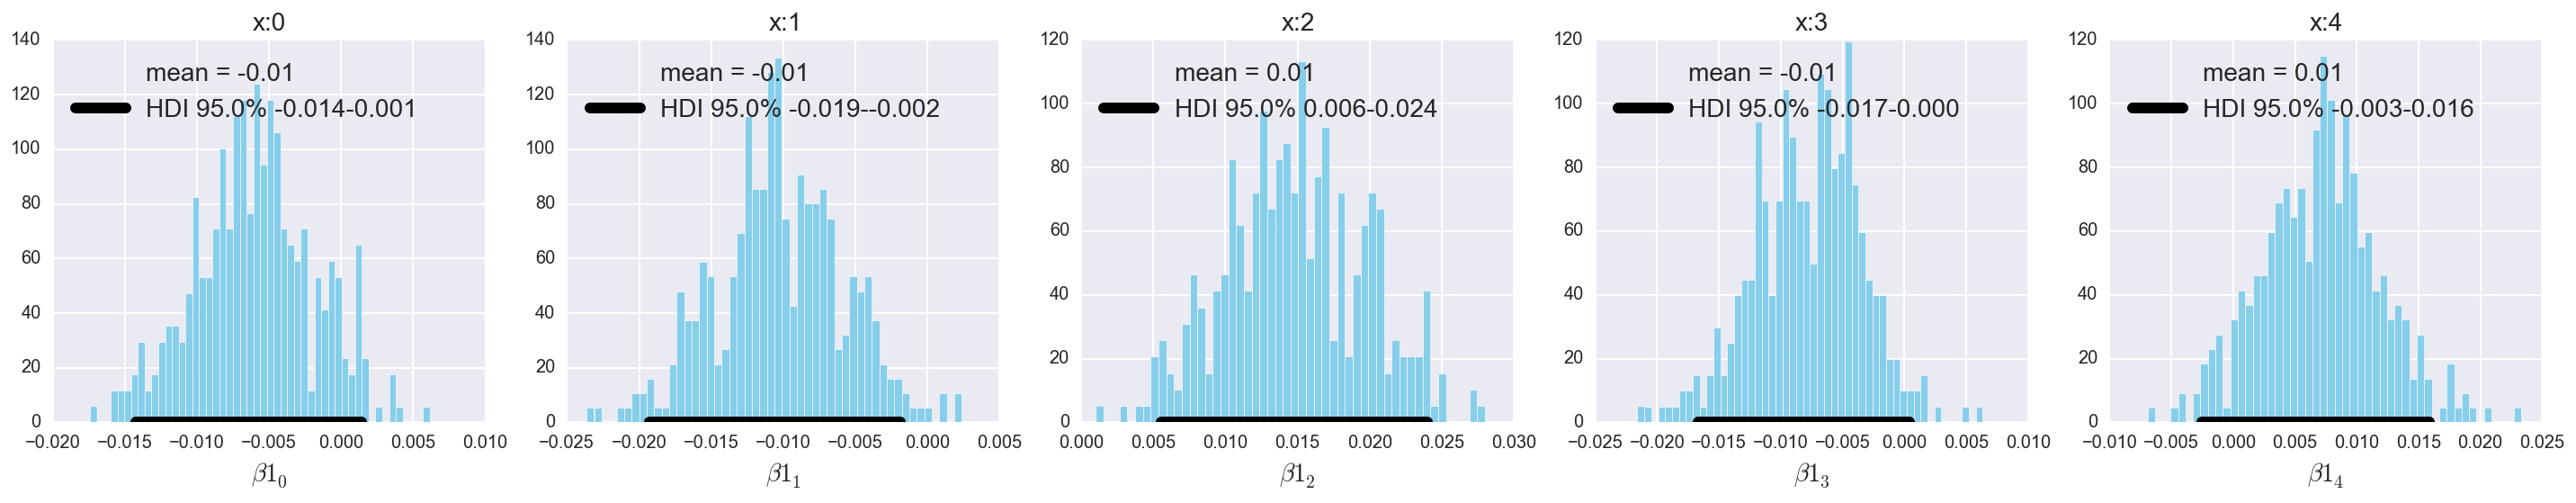

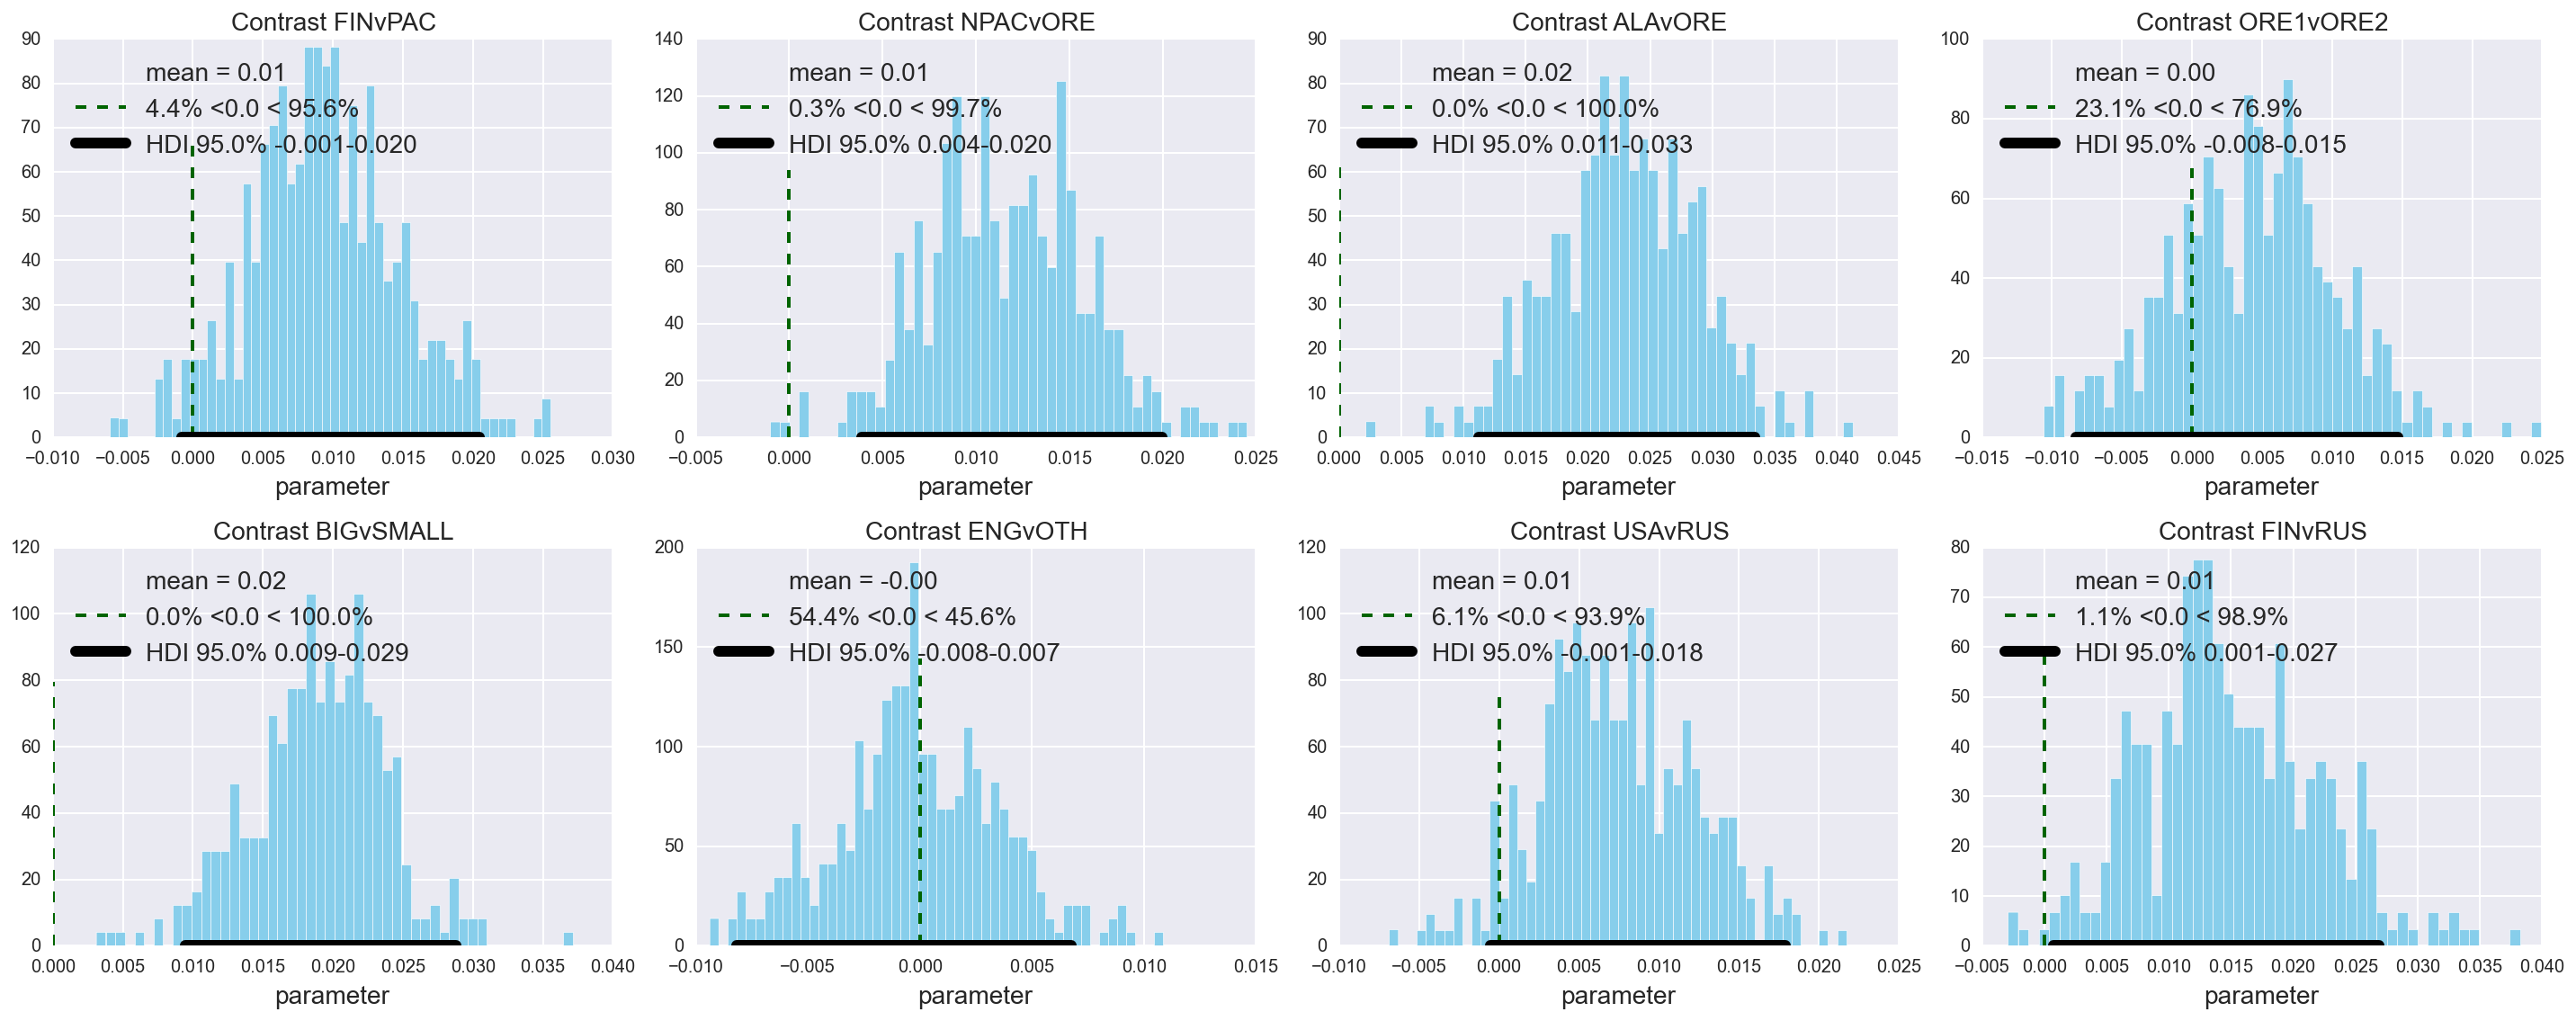

In [63]:
"""
18_ANOVAonewayNonhomogvarBrugs.py
One way BANOVA Non Homogeneous Variance
"""

# THE DATA.
# Specify data source:
dataSource = ["McDonaldSK1991" , "SolariLS2008" , "Random"][0]

# Load the data:
if dataSource == "McDonaldSK1991":
    datarecord = pd.read_csv(StringIO(McDonaldSK1991), sep='\s+')
    
    y = datarecord['Size']
    Ntotal = len(y)
    x = (datarecord['Group'] - 1).values
    xnames = pd.unique(datarecord['Site'])
    NxLvl = len(xnames)
    contrast_dict = {'BIGvSMALL':[-1/3,-1/3,1/2,-1/3,1/2],
                       'ORE1vORE2': [1,-1,0,0,0],
                       'ALAvORE':[-1/2,-1/2,1,0,0],
                       'NPACvORE':[-1/2,-1/2,1/2,1/2,0],
                       'USAvRUS':[1/3,1/3,1/3,-1,0],
                       'FINvPAC':[-1/4,-1/4,-1/4,-1/4,1],
                       'ENGvOTH':[1/3,1/3,1/3,-1/2,-1/2],
                       'FINvRUS':[0,0,0,-1,1]}


if dataSource == "SolariLS2008":
    datarecord = pd.read_csv(StringIO(SolariLS2008), sep='\s+')
    y = datarecord['Acid']
    Ntotal = len(y)
    x = (datarecord['Type'] - 1).values
    xnames = pd.unique(x)
    NxLvl = len(xnames)
    contrast_dict = {'G3vOTHER':[-1/8,-1/8,1,-1/8,-1/8,-1/8,-1/8,-1/8,-1/8]}


if dataSource == "Random":
    np.random.seed(47405)
    ysdtrue = 4.0
    a0true = 100
    atrue = [2, -2]  # sum to zero
    npercell = 8
    x = []
    y = []
    for xidx in range(len(atrue)):
        for subjidx in range(npercell):
            x.append(xidx)
            y.append(a0true + atrue[xidx] + norm.rvs(1, ysdtrue))
    Ntotal = len(y)
    NxLvl = len(set(x))
#  # Construct list of all pairwise comparisons, to compare with NHST TukeyHSD:
    contrast_dict = None
    for g1idx in range(NxLvl):
        for g2idx in range(g1idx+1, NxLvl):
            cmpVec = np.repeat(0, NxLvl)
            cmpVec[g1idx] = -1
            cmpVec[g2idx] = 1
            contrast_dict = (contrast_dict, cmpVec)


z = (y - np.mean(y))/np.std(y)


## THE MODEL.
with pm.Model() as model:
    # define the hyperpriors
    a_SD_unabs = pm.T('a_SD_unabs', mu=0, lam=0.001, nu=1)
    a_SD = abs(a_SD_unabs) + 0.1
    atau = 1 / a_SD**2
    m = pm.Gamma('m', 1, 1)
    d = pm.Gamma('d', 1, 1)
    sG = m**2 / d**2 
    rG = m / d**2 
    # define the priors
    sigma = pm.Uniform('sigma', 0, 10) # y values are assumed to be standardized
    tau = pm.Gamma('tau', sG, rG) 
    a0 = pm.Normal('a0', mu=0, tau=0.001) # y values are assumed to be standardized
    a = pm.Normal('a', mu=0 , tau=atau, shape=NxLvl)
    mu = a0 + a
    # define the likelihood
    yl = pm.Normal('yl', mu[x], tau=tau, observed=z)
    # Generate a MCMC chain
    start = pm.find_MAP()
    steps = pm.Metropolis()
    trace = pm.sample(20000, steps, start, progressbar=False)


# EXAMINE THE RESULTS
burnin = 2000
thin = 50

# Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

# Check for mixing and autocorrelation
#plt.figure(figsize=(16,6))
pm.autocorrplot(trace[burnin::thin], vars=model.unobserved_RVs[:-1])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
pm.traceplot(trace)

a0_sample = trace['a0'][burnin::thin]
a_sample = trace['a'][burnin::thin]
# Convert baseline to the original scale
m_sample = a0_sample.repeat(NxLvl).reshape(len(a0_sample), NxLvl) + a_sample
b0_sample = m_sample.mean(axis=1)
b0_sample = b0_sample * np.std(y) + np.mean(y)
# Convert baseline to the original scale
n_sample = b0_sample.repeat(NxLvl).reshape(len(b0_sample), NxLvl)
b_sample = (m_sample - n_sample)
b_sample = b_sample * np.std(y)


plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_post(b_sample[:,i], xlab=r'$\beta1_{%s}$' % i,
              show_mode=False, framealpha=0.5,
              bins=50, title='x:%s' % i)
plt.tight_layout()


nContrasts = len(contrast_dict)
if nContrasts > 0:
    plt.figure(figsize=(20, 8))
    count = 0
    for key, value in contrast_dict.items():
        contrast = np.dot(b_sample, value)
        plt.subplot(2, 4, count)
        plot_post(contrast, title='Contrast %s' % key, comp_val=0.0, 
                  show_mode=False, framealpha=0.5, 
                  bins=50)
        count += 1
    plt.tight_layout()

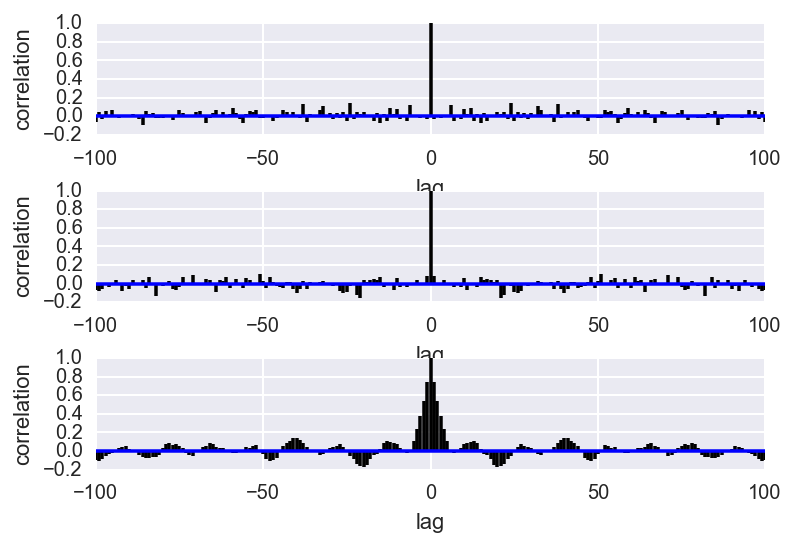

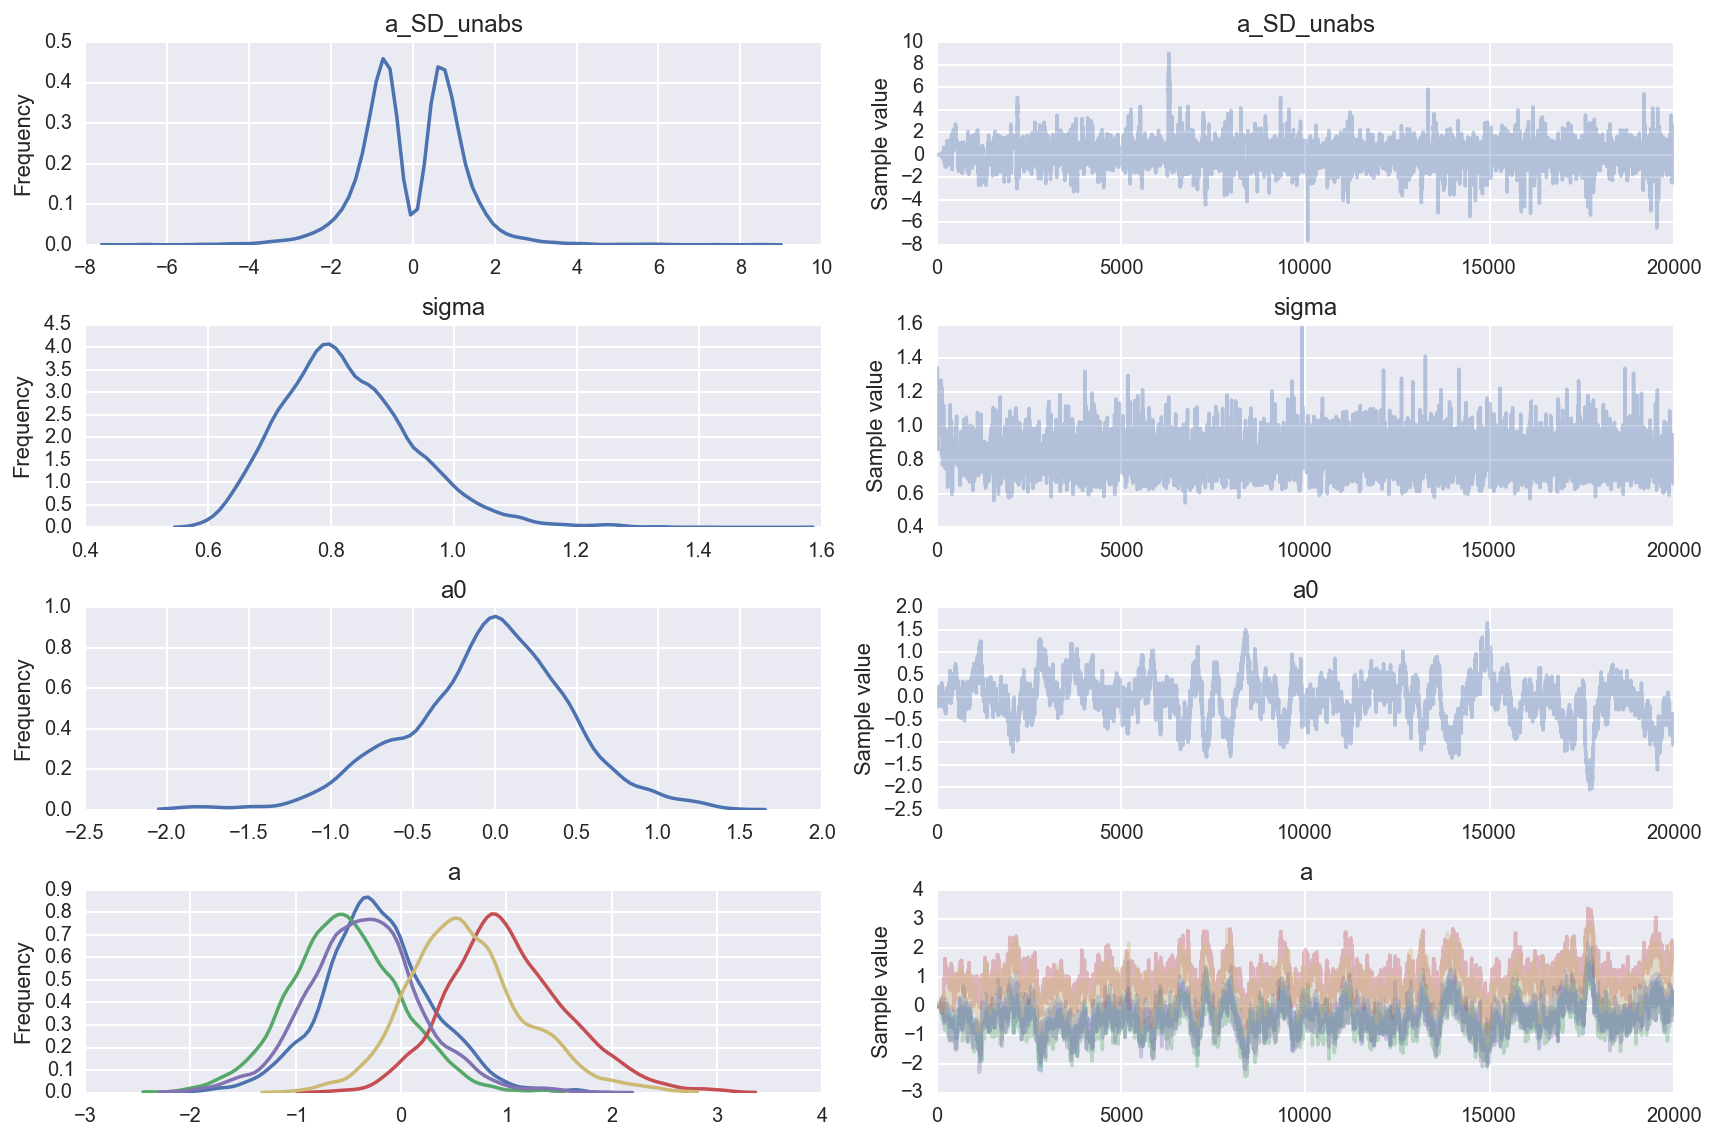

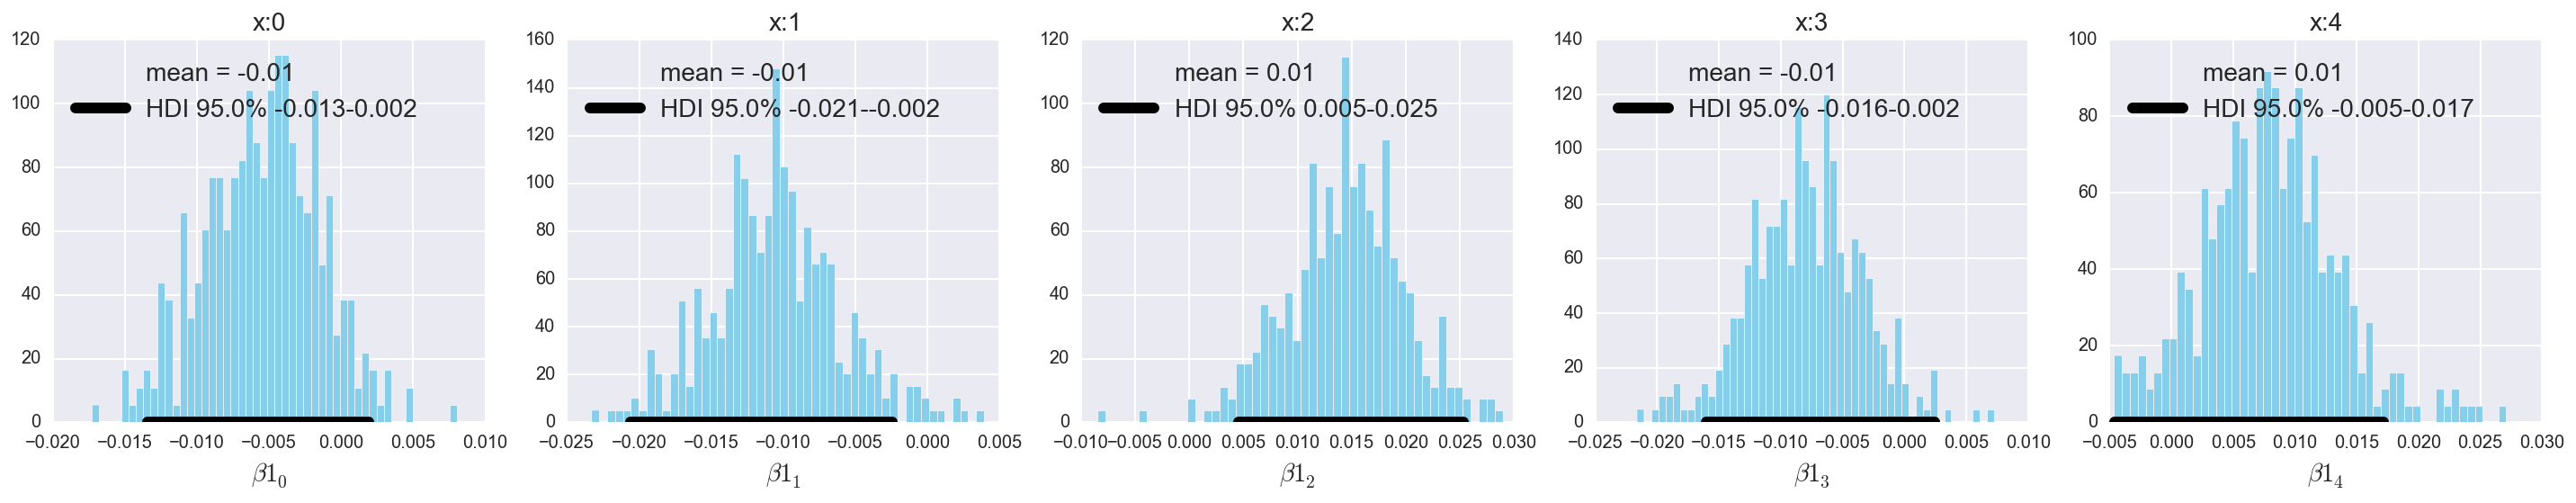

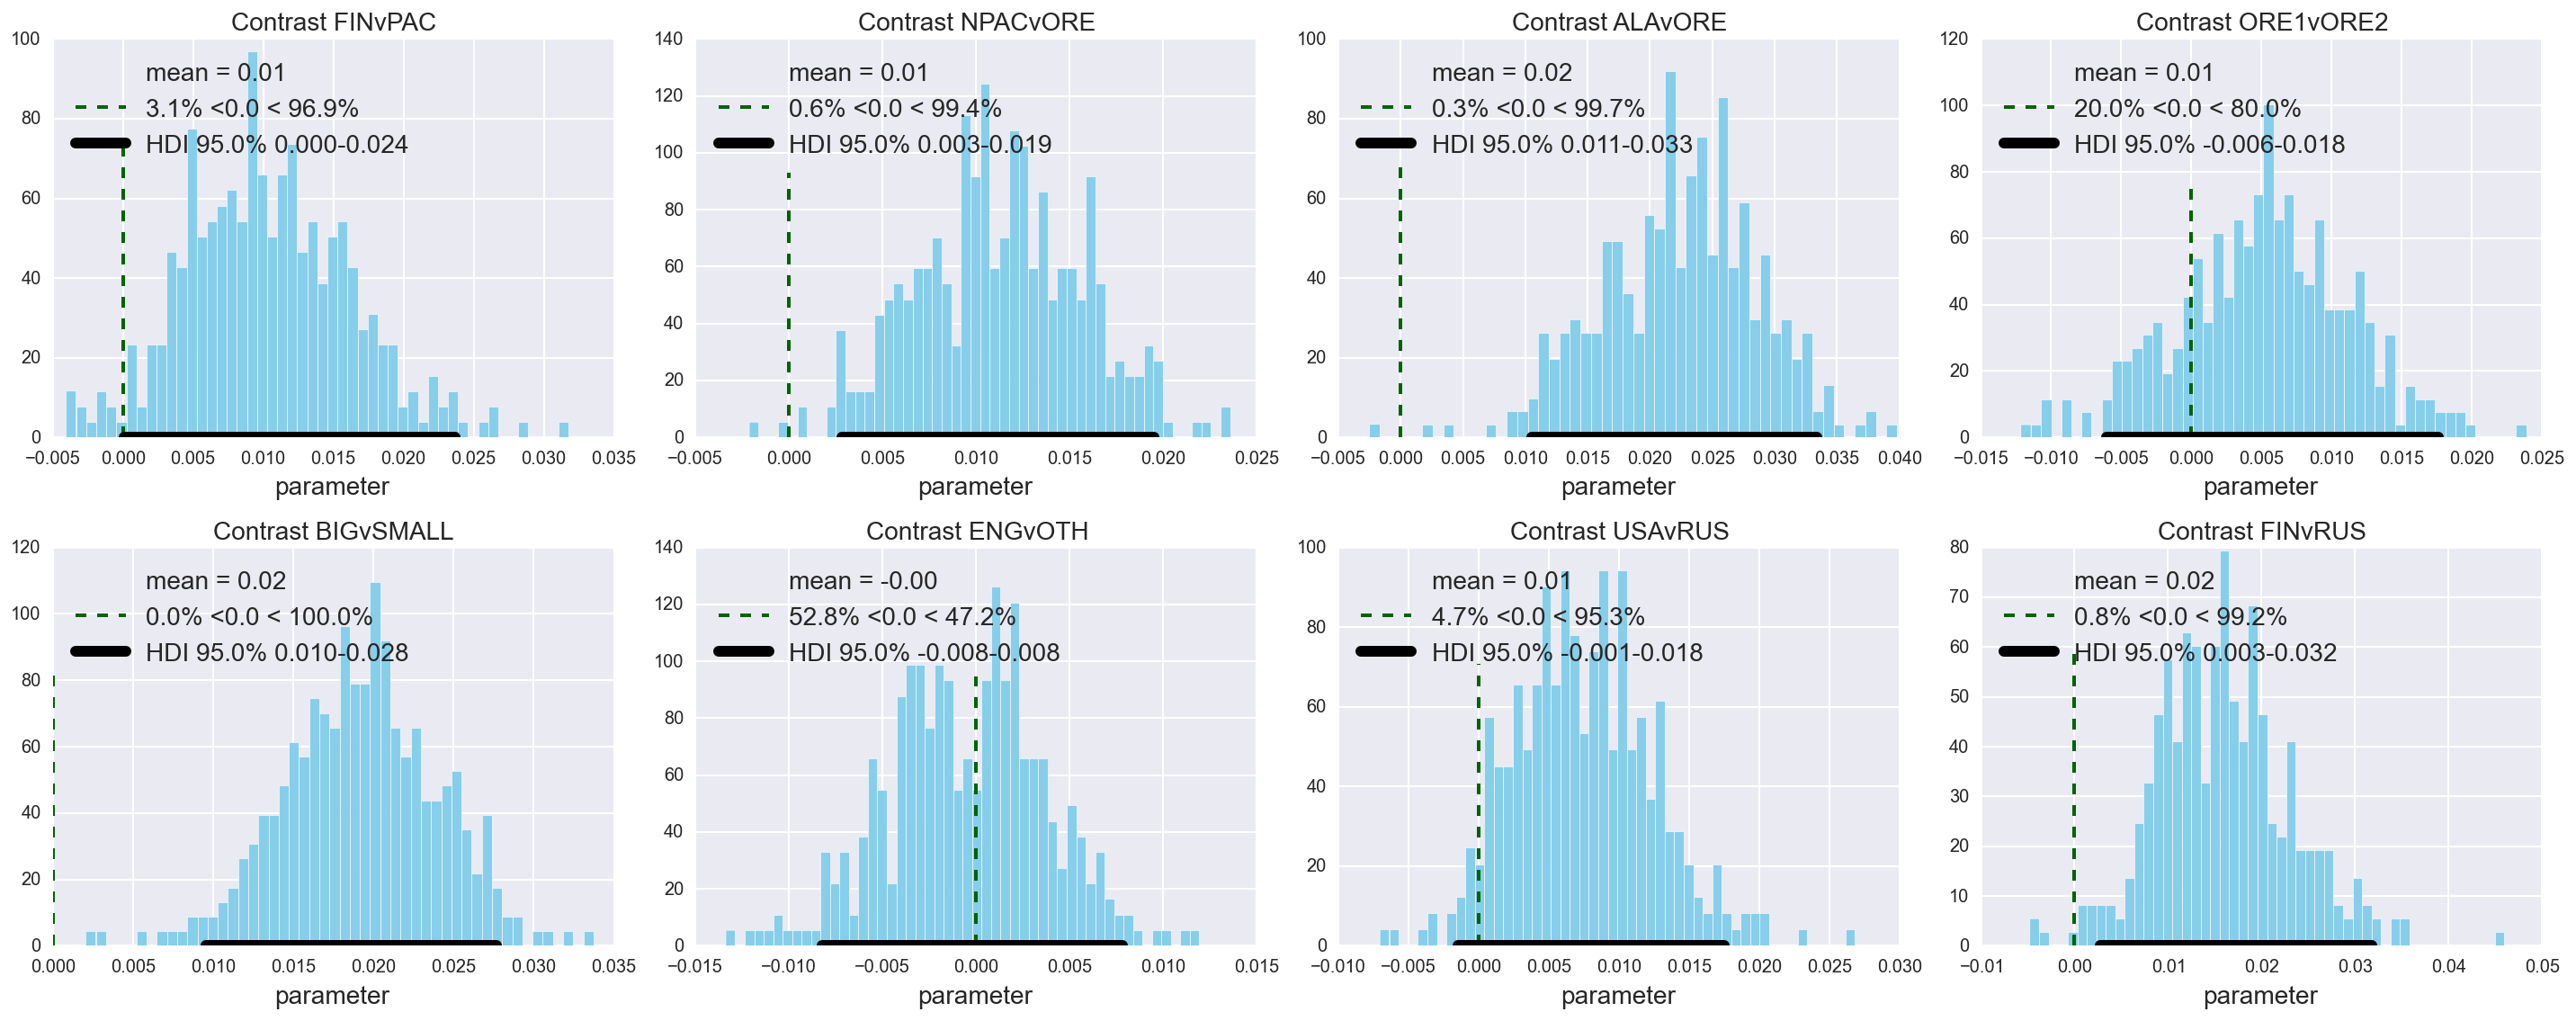

In [64]:
"""
18_ANOVAonewayPyMC.py
One way BANOVA
"""

# THE DATA.
# Specify data source:
dataSource = ["McDonaldSK1991" , "SolariLS2008" , "Random"][0]

# Load the data:
if dataSource == "McDonaldSK1991":
    datarecord = pd.read_csv(StringIO(McDonaldSK1991), sep='\s+')
    y = datarecord['Size']
    Ntotal = len(y)
    x = (datarecord['Group'] - 1).values
    xnames = pd.unique(datarecord['Site'])
    NxLvl = len(xnames)
    contrast_dict = {'BIGvSMALL':[-1/3,-1/3,1/2,-1/3,1/2],
                       'ORE1vORE2': [1,-1,0,0,0],
                       'ALAvORE':[-1/2,-1/2,1,0,0],
                       'NPACvORE':[-1/2,-1/2,1/2,1/2,0],
                       'USAvRUS':[1/3,1/3,1/3,-1,0],
                       'FINvPAC':[-1/4,-1/4,-1/4,-1/4,1],
                       'ENGvOTH':[1/3,1/3,1/3,-1/2,-1/2],
                       'FINvRUS':[0,0,0,-1,1]}


if dataSource == "SolariLS2008":
    datarecord = pd.read_csv(StringIO(SolariLS2008), sep='\s+')
    y = datarecord['Acid']
    Ntotal = len(y)
    x = (datarecord['Type'] - 1).values
    xnames = pd.unique(x)
    NxLvl = len(xnames)
    contrast_dict = {'G3vOTHER':[-1/8,-1/8,1,-1/8,-1/8,-1/8,-1/8,-1/8,-1/8]}


if dataSource == "Random":
    np.random.seed(47405)
    ysdtrue = 4.0
    a0true = 100
    atrue = [2, -2]  # sum to zero
    npercell = 8
    x = []
    y = []
    for xidx in range(len(atrue)):
        for subjidx in range(npercell):
            x.append(xidx)
            y.append(a0true + atrue[xidx] + norm.rvs(1, ysdtrue))
    Ntotal = len(y)
    NxLvl = len(set(x))
#  # Construct list of all pairwise comparisons, to compare with NHST TukeyHSD:
    contrast_dict = None
    for g1idx in range(NxLvl):
        for g2idx in range(g1idx+1, NxLvl):
            cmpVec = np.repeat(0, NxLvl)
            cmpVec[g1idx] = -1
            cmpVec[g2idx] = 1
            contrast_dict = (contrast_dict, cmpVec)


z = (y - np.mean(y))/np.std(y)


## THE MODEL.
with pm.Model() as model:
    # define the hyperpriors
    a_SD_unabs = pm.T('a_SD_unabs', mu=0, lam=0.001, nu=1)
    a_SD = abs(a_SD_unabs) + 0.1
    atau = 1 / a_SD**2
    # define the priors
    sigma = pm.Uniform('sigma', 0, 10) # y values are assumed to be standardized
    tau = 1 / sigma**2
    a0 = pm.Normal('a0', mu=0, tau=0.001) # y values are assumed to be standardized
    a = pm.Normal('a', mu=0 , tau=atau, shape=NxLvl)
    mu = a0 + a
    # define the likelihood
    yl = pm.Normal('yl', mu[x], tau=tau, observed=z)
    # Generate a MCMC chain
    start = pm.find_MAP()
    steps = pm.Metropolis()
    trace = pm.sample(20000, steps, start, progressbar=False)


# EXAMINE THE RESULTS
burnin = 2000
thin = 50

# Print summary for each trace
#pm.summary(trace[burnin::thin])
#pm.summary(trace)

# Check for mixing and autocorrelation
pm.autocorrplot(trace[burnin::thin], vars=model.unobserved_RVs[:-1])

## Plot KDE and sampled values for each parameter.
#pm.traceplot(trace[burnin::thin])
pm.traceplot(trace)

a0_sample = trace['a0'][burnin::thin]
a_sample = trace['a'][burnin::thin]
# Convert baseline to the original scale
m_sample = a0_sample.repeat(NxLvl).reshape(len(a0_sample), NxLvl) + a_sample
b0_sample = m_sample.mean(axis=1)
b0_sample = b0_sample * np.std(y) + np.mean(y)
# Convert baseline to the original scale
n_sample = b0_sample.repeat(NxLvl).reshape(len(b0_sample), NxLvl)
b_sample = (m_sample - n_sample)
b_sample = b_sample * np.std(y)



plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_post(b_sample[:,i], xlab=r'$\beta1_{%s}$' % i,
              show_mode=False, framealpha=0.5,
              bins=50, title='x:%s' % i)
plt.tight_layout()

nContrasts = len(contrast_dict)
if nContrasts > 0:
    plt.figure(figsize=(20, 8))
    count = 0
    for key, value in contrast_dict.items():
        contrast = np.dot(b_sample, value)
        plt.subplot(2, 4, count)
        plot_post(contrast, title='Contrast %s' % key, comp_val=0.0, 
                  show_mode=False, framealpha=0.5, 
                  bins=50)
        count += 1
    plt.tight_layout()
